# Introduction

This notebook contains the code neccesary to create and train the Genome autoencoder (Gencoder). Gencoder is a neural network autoencoder that takes a given 1000-bp long DNA sequence and outputs a DNA sequence with similar biological characteristics but a different sequence of nucleotides. 

Gencoder is able to preserve biological characteristics of the input DNA sequence by learning from an auxiliary neural network that can itself predict these biological characteristics. We call this auxiliary network the biological critic. In this notebook, we use a network functionally equivalent to DeepSEA (https://www.nature.com/articles/nmeth.3547), a neural network that can "predict the epigenetic state of a sequence, including transcription factors binding, DNase I sensitivities and histone marks in multiple cell types, and further utilize this capability to predict the chromatin effects of sequence variants and prioritize regulatory variants." 

We train Gencoder to minimize the loss between the output of running the DNA sequences it generates through DeepSEA and the output of running the training input sequence through DeepSEA. Thus, Gencoder learns to produce a DNA sequence with identical predicted epigenetic states, transcription factor binding sites, etc. as the input sequence.

The use case of Gencoder is to protect the DNA sequences of individuals in publicly-accessible research databases by obfuscating their DNA sequences while preserving their research utility.

# Data preprocessing

In [1]:
from Bio import SeqIO
from textwrap import wrap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pickle as pkl

In [2]:
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

We use DeepSEA as the biological critic. It's input is encoded A, G, C, T and takes in sequences of length 1000.

Here, we generate a large number of DNA sequences of length 1000, each one-hot encoded to match the input encoding of DeepSEA.

Future work will be devoted to training Gencoder on 1000-bp long chunks of real DNA sequences.

In [3]:
genome_fragments = list(SeqIO.parse("code_asd_dnarna_v3/resources/hg19_UCSC.fa", "fasta"))

In [4]:
sample_length = 1000
nucleic_acids = "AGCT"

In [5]:
import random

def generate_samples(fragments, num_samples):
  samples = []
  while len(samples) < num_samples:
    fragment_number = random.randint(0, len(fragments)-1)
    fragment = fragments[fragment_number]
    limit = len(fragment)
    start = random.randint(0, limit - sample_length)
    end = start + sample_length
    frag = fragment.seq[start:end]
    if all([c not in frag for c in ["a", "c", "t", "g", "N"]]):
      samples.append(frag.upper())
  return samples


raw_training_samples = generate_samples(genome_fragments, 50000)
raw_validation_samples = generate_samples(genome_fragments, 100)

In [6]:

# num_training_samples = 100000
# validation_samples = []
# num_validation_samples = 100

# def generate_samples(num_samples):
#   samples = []
#   for i in range(num_samples):
#     sample = ""
#     for i in range(sample_length):
#       base_selection = int(random.random()*4)
#       sample += nucleic_acids[base_selection]
#     samples.append(sample)
#   return samples

# raw_training_samples = generate_samples(num_training_samples)

# raw_validation_samples = generate_samples(num_validation_samples)

Initialize one hot encoder

In [7]:
onehot_encoder = OneHotEncoder(sparse=False)
label_encoder = LabelEncoder()

integer_encoded = label_encoder.fit_transform(list(nucleic_acids))
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(np.asarray(list(nucleic_acids)).reshape(-1, 1))

OneHotEncoder(sparse=False)

In [8]:
# One-hot encode each input string
batch_size = 100
use_channels = False

def encode_and_resize_samples(samples):
  one_hot_samples = np.array([np.array(onehot_encoder.transform(np.asarray(list(sample)).reshape(-1, 1))) for sample in samples])
  if use_channels:
    one_hot_samples2 = np.swapaxes(np.swapaxes(np.expand_dims(one_hot_samples, axis=3), 1, 2), 2, 3)
  else:
    one_hot_samples2 = np.swapaxes(np.expand_dims(one_hot_samples, axis=3), 1, 3)

  return one_hot_samples2

In [9]:
resized_training_samples = encode_and_resize_samples(raw_training_samples)
resized_validation_samples = encode_and_resize_samples(raw_validation_samples)

In [10]:
resized_training_samples[0].shape

(1, 4, 1000)

Reshape and batch one-hot encoded input sequences

In [11]:
def batchify(samples: np.ndarray, batch_size: int) -> np.ndarray:
    for i in list(range(0, len(samples), batch_size)):
      yield samples[i:i+batch_size]

In [12]:
batched_training_samples = list(batchify(resized_training_samples, batch_size))
batched_validation_samples = list(batchify(resized_validation_samples, batch_size))

In [13]:
# Convert one-hot encoded genome samples to PyTorch tensors
training_samples = torch.as_tensor(batched_training_samples).to(device, dtype=torch.float) 
validation_samples = torch.as_tensor(batched_validation_samples).to(device, dtype=torch.float) 

/tmp/ipykernel_237254/3818280843.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  training_samples = torch.as_tensor(batched_training_samples).to(device, dtype=torch.float)


# Load DeepSEA

In [14]:
import torch
import torch.nn as nn


class LambdaBase(nn.Sequential):
    def __init__(self, fn, *args):
        super(LambdaBase, self).__init__(*args)
        self.lambda_func = fn

    def forward_prepare(self, input):
        output = []
        for module in self._modules.values():
            output.append(module(input))
        return output if output else input


class Lambda(LambdaBase):
    def forward(self, input):
        return self.lambda_func(self.forward_prepare(input))


class DeepSEAasd(nn.Module):

    def __init__(self):
        super(DeepSEAasd, self).__init__()
        self.model = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(4, 320, (1, 8)),
                nn.ReLU(),
                nn.Conv2d(320, 320, (1, 8)),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.MaxPool2d((1, 4), (1, 4)),
                nn.Conv2d(320, 480, (1, 8)),
                nn.ReLU(),
                nn.Conv2d(480, 480, (1, 8)),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.MaxPool2d((1, 4), (1, 4)),
                nn.Conv2d(480, 960, (1, 8)),
                nn.ReLU(),
                nn.Conv2d(960, 960, (1, 8)),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Dropout(0.5),
                Lambda(lambda x: x.view(x.size(0), -1)),
                nn.Sequential(
                    Lambda(lambda x: x.view(1, -1)
                           if 1 == len(x.size()) else x),
                    nn.Linear(42240, 2003)
                ),
                nn.ReLU(),
                nn.Sequential(
                    Lambda(lambda x: x.view(1, -1)
                           if 1 == len(x.size()) else x),
                    nn.Linear(2003, 2002)
                ),
            ),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


def criterion():
    return nn.BCELoss()


def get_optimizer(lr):
    return (torch.optim.SGD,
            {"lr": lr, "weight_decay": 1e-6, "momentum": 0.9})


In [15]:
deepsea = DeepSEAasd().to(device)

In [16]:
ds_weights = torch.load("code_asd_dnarna_v3/models/asd_deepsea/deepsea_asd.pth")

In [17]:
# Fix misnamed weight keys
from collections import OrderedDict
ds_weights2 = OrderedDict(("model."+k, v) for k, v in ds_weights.items())

In [18]:
deepsea.load_state_dict(ds_weights2)

<All keys matched successfully>

# Gencoder

Here, we implement Gencoder simple three-layer CNN.

In [39]:
num_channels = 1  # Only one channel for genomic data
n_generator_features = 512  # Size of feature maps in generator
n_discriminator_features = 64  # Size of feature maps in discriminator
kernel_size = (4, 16)
input_size = sample_length
ngpu = 1

class Net(nn.Module):
  def __init__(self, ngpu):
    super(Net, self).__init__()
    self.ngpu = ngpu
    self.convolve = nn.Sequential(
        # First layer
        nn.Conv2d(num_channels, n_generator_features, kernel_size),
        nn.LeakyReLU(0.2 ,inplace=True),
        nn.BatchNorm2d(n_generator_features),
        # Second layer
        nn.Conv2d(n_generator_features, int(n_generator_features/2), (1,32)),
        nn.LeakyReLU(0.2 ,inplace=True),
        nn.BatchNorm2d(int(n_generator_features/2)),
        # Third layer
        nn.Conv2d(int(n_generator_features/2), int(n_generator_features/4), (1,32)), # <- This kernel size has to be 1,x for some reason
        nn.LeakyReLU(0.2 ,inplace=True),
        nn.BatchNorm2d(int(n_generator_features/4))
    )

    self.deconvolve = nn.Sequential(
        # Fifth layer
        nn.ConvTranspose2d(int(n_generator_features/4), int(n_generator_features/2), (1, 32)),
        nn.ReLU(True),
        nn.BatchNorm2d(int(n_generator_features/2)),
        # Fifth layer
        nn.ConvTranspose2d(int(n_generator_features/2), n_generator_features, (1, 32)),
        nn.ReLU(True),
        nn.BatchNorm2d(n_generator_features),
        # Output Layer
        nn.ConvTranspose2d(n_generator_features, num_channels, kernel_size),
        nn.Softmax(dim=2)
    )

  def forward(self, input):
    f = self.convolve(input)
    return self.deconvolve(f)

  def print(self, input):
    f = self.convolve(input)
    print(f.size())

In [40]:
# Instantiate our model with the detected GPU
net = Net(1).to(device)

# Print the model
print(net)

Net(
  (convolve): Sequential(
    (0): Conv2d(1, 512, kernel_size=(4, 16), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(512, 256, kernel_size=(1, 32), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(256, 128, kernel_size=(1, 32), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconvolve): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(1, 32), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(256, 512, kernel_size=(1, 32), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(512, eps=1e-05,

In [41]:
criterion = nn.L1Loss(reduction='sum')
optimizer = optim.Adam(net.parameters())

loss_log = {"val":[], "training":[]}

In [42]:
HEIGHT = batch_size
WIDTH = 1000
DEPTH = 4

num_epochs = 50
best_validation_loss = 1

for epoch in range(num_epochs):
  running_loss = 0.0
  for i, training_batch in enumerate(training_samples):
        
    net.zero_grad()
    output = net(training_batch)

    ds_ts = deepsea(training_batch.reshape((100, 4, 1, 1000)))
    ds_o = deepsea(output.reshape((100, 4, 1, 1000)))
    
    # Training loss to minimize DeepSEA distances
    criterion = nn.MSELoss(reduction='mean')

    training_loss = criterion(ds_ts, ds_o)

    training_loss.backward()
    optimizer.step()

    training_loss = training_loss.item()

    # Compute validation loss across all validation samples
    output_val = net(validation_samples[0])
    
    ds_val = deepsea(validation_samples[0].reshape((100, 4, 1, 1000)))
    ds_oval = deepsea(output_val.reshape((100, 4, 1, 1000)))

    validation_loss = criterion(ds_val, ds_oval).item()
    
    loss_log["val"].append(training_loss)
    loss_log["training"].append(validation_loss)
    
    if validation_loss < best_validation_loss:
        torch.save(net.state_dict(), 'gencoder_weights.pt')
        best_validation_loss = validation_loss
        print(f"Saving new best model w/ loss: {validation_loss}")

    print(f"Epoch {epoch}, Batch: {i}: Training Loss: {training_loss}, Validation Loss: {validation_loss}")
    
    with open("loss_log.pkl", "wb+") as log:
        pkl.dump(loss_log, log)

Saving new best model w/ loss: 0.06073909252882004
Epoch 0, Batch: 0: Training Loss: 0.09823758155107498, Validation Loss: 0.06073909252882004
Epoch 0, Batch: 1: Training Loss: 0.06629336625337601, Validation Loss: 0.08434315770864487
Epoch 0, Batch: 2: Training Loss: 0.09162230044603348, Validation Loss: 0.06810101866722107
Saving new best model w/ loss: 0.05995773524045944
Epoch 0, Batch: 3: Training Loss: 0.059809256345033646, Validation Loss: 0.05995773524045944
Epoch 0, Batch: 4: Training Loss: 0.06468682736158371, Validation Loss: 0.06025822088122368
Epoch 0, Batch: 5: Training Loss: 0.06249883770942688, Validation Loss: 0.06072044000029564
Epoch 0, Batch: 6: Training Loss: 0.06973383575677872, Validation Loss: 0.060477085411548615
Epoch 0, Batch: 7: Training Loss: 0.05830160155892372, Validation Loss: 0.06015895679593086
Saving new best model w/ loss: 0.05931432172656059
Epoch 0, Batch: 8: Training Loss: 0.060447145253419876, Validation Loss: 0.05931432172656059
Saving new best 

Epoch 0, Batch: 78: Training Loss: 0.043198470026254654, Validation Loss: 0.04317120462656021
Epoch 0, Batch: 79: Training Loss: 0.036596301943063736, Validation Loss: 0.044415611773729324
Epoch 0, Batch: 80: Training Loss: 0.044023144990205765, Validation Loss: 0.046745508909225464
Epoch 0, Batch: 81: Training Loss: 0.041492823511362076, Validation Loss: 0.04565875604748726
Epoch 0, Batch: 82: Training Loss: 0.041628655046224594, Validation Loss: 0.03793913871049881
Epoch 0, Batch: 83: Training Loss: 0.040390051901340485, Validation Loss: 0.039111386984586716
Epoch 0, Batch: 84: Training Loss: 0.03517267853021622, Validation Loss: 0.036687467247247696
Epoch 0, Batch: 85: Training Loss: 0.04283924028277397, Validation Loss: 0.03759484365582466
Saving new best model w/ loss: 0.03237546235322952
Epoch 0, Batch: 86: Training Loss: 0.04170769453048706, Validation Loss: 0.03237546235322952
Epoch 0, Batch: 87: Training Loss: 0.04747942462563515, Validation Loss: 0.03696763142943382
Epoch 0, 

Epoch 0, Batch: 163: Training Loss: 0.03525504842400551, Validation Loss: 0.03803179785609245
Epoch 0, Batch: 164: Training Loss: 0.03231438994407654, Validation Loss: 0.03855657950043678
Epoch 0, Batch: 165: Training Loss: 0.03482265770435333, Validation Loss: 0.038617249578237534
Epoch 0, Batch: 166: Training Loss: 0.03221135586500168, Validation Loss: 0.036693647503852844
Epoch 0, Batch: 167: Training Loss: 0.035088494420051575, Validation Loss: 0.03465418890118599
Epoch 0, Batch: 168: Training Loss: 0.0375545509159565, Validation Loss: 0.03651101142168045
Epoch 0, Batch: 169: Training Loss: 0.03894943371415138, Validation Loss: 0.03605504706501961
Epoch 0, Batch: 170: Training Loss: 0.037339948117733, Validation Loss: 0.03457150608301163
Epoch 0, Batch: 171: Training Loss: 0.03563569858670235, Validation Loss: 0.03876631334424019
Epoch 0, Batch: 172: Training Loss: 0.032235607504844666, Validation Loss: 0.036039743572473526
Epoch 0, Batch: 173: Training Loss: 0.03448181599378586, V

Epoch 0, Batch: 250: Training Loss: 0.03652716800570488, Validation Loss: 0.037029799073934555
Epoch 0, Batch: 251: Training Loss: 0.032830409705638885, Validation Loss: 0.037768542766571045
Epoch 0, Batch: 252: Training Loss: 0.03509853780269623, Validation Loss: 0.037977106869220734
Epoch 0, Batch: 253: Training Loss: 0.03504034876823425, Validation Loss: 0.03726319223642349
Epoch 0, Batch: 254: Training Loss: 0.032598964869976044, Validation Loss: 0.039512429386377335
Epoch 0, Batch: 255: Training Loss: 0.03645698353648186, Validation Loss: 0.03847692906856537
Epoch 0, Batch: 256: Training Loss: 0.04157322272658348, Validation Loss: 0.04009182006120682
Epoch 0, Batch: 257: Training Loss: 0.04024922847747803, Validation Loss: 0.03976575285196304
Epoch 0, Batch: 258: Training Loss: 0.03877578303217888, Validation Loss: 0.03699431195855141
Epoch 0, Batch: 259: Training Loss: 0.03255511447787285, Validation Loss: 0.03591567650437355
Epoch 0, Batch: 260: Training Loss: 0.0329254493117332

Epoch 0, Batch: 337: Training Loss: 0.03640354052186012, Validation Loss: 0.03636828809976578
Epoch 0, Batch: 338: Training Loss: 0.03777438402175903, Validation Loss: 0.03417973965406418
Epoch 0, Batch: 339: Training Loss: 0.036633703857660294, Validation Loss: 0.036881137639284134
Epoch 0, Batch: 340: Training Loss: 0.03773990273475647, Validation Loss: 0.03884318098425865
Epoch 0, Batch: 341: Training Loss: 0.035068534314632416, Validation Loss: 0.035994093865156174
Epoch 0, Batch: 342: Training Loss: 0.041977811604738235, Validation Loss: 0.03822001814842224
Epoch 0, Batch: 343: Training Loss: 0.03731321543455124, Validation Loss: 0.03647283464670181
Epoch 0, Batch: 344: Training Loss: 0.036759793758392334, Validation Loss: 0.03426104784011841
Epoch 0, Batch: 345: Training Loss: 0.03716275468468666, Validation Loss: 0.03470008075237274
Epoch 0, Batch: 346: Training Loss: 0.03582476079463959, Validation Loss: 0.03484347090125084
Epoch 0, Batch: 347: Training Loss: 0.0397380366921424

Epoch 0, Batch: 424: Training Loss: 0.03975813835859299, Validation Loss: 0.035922519862651825
Epoch 0, Batch: 425: Training Loss: 0.035441841930150986, Validation Loss: 0.03508198633790016
Epoch 0, Batch: 426: Training Loss: 0.034038033336400986, Validation Loss: 0.032456111162900925
Epoch 0, Batch: 427: Training Loss: 0.03299504518508911, Validation Loss: 0.03341829031705856
Epoch 0, Batch: 428: Training Loss: 0.035778630524873734, Validation Loss: 0.032759517431259155
Epoch 0, Batch: 429: Training Loss: 0.02962326630949974, Validation Loss: 0.03416658565402031
Epoch 0, Batch: 430: Training Loss: 0.031748540699481964, Validation Loss: 0.035048287361860275
Epoch 0, Batch: 431: Training Loss: 0.03207484260201454, Validation Loss: 0.03477955609560013
Epoch 0, Batch: 432: Training Loss: 0.03589348867535591, Validation Loss: 0.03550194948911667
Epoch 0, Batch: 433: Training Loss: 0.03711003437638283, Validation Loss: 0.03431824594736099
Epoch 0, Batch: 434: Training Loss: 0.03556553274393

Epoch 1, Batch: 11: Training Loss: 0.03381842374801636, Validation Loss: 0.032826993614435196
Epoch 1, Batch: 12: Training Loss: 0.03521464392542839, Validation Loss: 0.032358862459659576
Epoch 1, Batch: 13: Training Loss: 0.03311366215348244, Validation Loss: 0.03091748245060444
Epoch 1, Batch: 14: Training Loss: 0.03565632179379463, Validation Loss: 0.03452848270535469
Epoch 1, Batch: 15: Training Loss: 0.04155822470784187, Validation Loss: 0.031901489943265915
Epoch 1, Batch: 16: Training Loss: 0.03676836937665939, Validation Loss: 0.03612670674920082
Epoch 1, Batch: 17: Training Loss: 0.026409145444631577, Validation Loss: 0.031699348241090775
Epoch 1, Batch: 18: Training Loss: 0.029385097324848175, Validation Loss: 0.03250829130411148
Epoch 1, Batch: 19: Training Loss: 0.02658754773437977, Validation Loss: 0.033506378531455994
Epoch 1, Batch: 20: Training Loss: 0.031020544469356537, Validation Loss: 0.032292596995830536
Epoch 1, Batch: 21: Training Loss: 0.03513051196932793, Valid

Epoch 1, Batch: 98: Training Loss: 0.034023746848106384, Validation Loss: 0.03271356597542763
Epoch 1, Batch: 99: Training Loss: 0.036336544901132584, Validation Loss: 0.031483449041843414
Epoch 1, Batch: 100: Training Loss: 0.03367554396390915, Validation Loss: 0.034676045179367065
Epoch 1, Batch: 101: Training Loss: 0.03180703893303871, Validation Loss: 0.034221816807985306
Epoch 1, Batch: 102: Training Loss: 0.03108825720846653, Validation Loss: 0.03263739123940468
Epoch 1, Batch: 103: Training Loss: 0.03459062799811363, Validation Loss: 0.03082759492099285
Epoch 1, Batch: 104: Training Loss: 0.03168083727359772, Validation Loss: 0.03388736769556999
Epoch 1, Batch: 105: Training Loss: 0.029567169025540352, Validation Loss: 0.030981402844190598
Epoch 1, Batch: 106: Training Loss: 0.03559226542711258, Validation Loss: 0.03518032282590866
Epoch 1, Batch: 107: Training Loss: 0.032453589141368866, Validation Loss: 0.03334526717662811
Epoch 1, Batch: 108: Training Loss: 0.0319365262985229

Epoch 1, Batch: 184: Training Loss: 0.038159340620040894, Validation Loss: 0.032805055379867554
Epoch 1, Batch: 185: Training Loss: 0.038303494453430176, Validation Loss: 0.030304353684186935
Epoch 1, Batch: 186: Training Loss: 0.03143683075904846, Validation Loss: 0.03178488835692406
Epoch 1, Batch: 187: Training Loss: 0.03773784264922142, Validation Loss: 0.032751359045505524
Epoch 1, Batch: 188: Training Loss: 0.033358603715896606, Validation Loss: 0.03293692693114281
Epoch 1, Batch: 189: Training Loss: 0.030441930517554283, Validation Loss: 0.03392939642071724
Epoch 1, Batch: 190: Training Loss: 0.034669723361730576, Validation Loss: 0.032340701669454575
Epoch 1, Batch: 191: Training Loss: 0.033561769872903824, Validation Loss: 0.030442742630839348
Epoch 1, Batch: 192: Training Loss: 0.03378196060657501, Validation Loss: 0.029766405001282692
Epoch 1, Batch: 193: Training Loss: 0.02945658750832081, Validation Loss: 0.03304090350866318
Epoch 1, Batch: 194: Training Loss: 0.0348042435

Epoch 1, Batch: 271: Training Loss: 0.024072598665952682, Validation Loss: 0.030332382768392563
Epoch 1, Batch: 272: Training Loss: 0.030379092320799828, Validation Loss: 0.03209349513053894
Epoch 1, Batch: 273: Training Loss: 0.030311938375234604, Validation Loss: 0.03247366473078728
Epoch 1, Batch: 274: Training Loss: 0.03479517251253128, Validation Loss: 0.03221018239855766
Epoch 1, Batch: 275: Training Loss: 0.03355890139937401, Validation Loss: 0.03263508528470993
Epoch 1, Batch: 276: Training Loss: 0.031059149652719498, Validation Loss: 0.03130737692117691
Epoch 1, Batch: 277: Training Loss: 0.030287984758615494, Validation Loss: 0.03232961893081665
Epoch 1, Batch: 278: Training Loss: 0.03269733488559723, Validation Loss: 0.034438036382198334
Epoch 1, Batch: 279: Training Loss: 0.03185081109404564, Validation Loss: 0.02889004535973072
Epoch 1, Batch: 280: Training Loss: 0.030250439420342445, Validation Loss: 0.033023200929164886
Epoch 1, Batch: 281: Training Loss: 0.0326337069272

Epoch 1, Batch: 358: Training Loss: 0.037671491503715515, Validation Loss: 0.031170370057225227
Epoch 1, Batch: 359: Training Loss: 0.03448719158768654, Validation Loss: 0.030135786160826683
Epoch 1, Batch: 360: Training Loss: 0.031281229108572006, Validation Loss: 0.031821928918361664
Epoch 1, Batch: 361: Training Loss: 0.03089664876461029, Validation Loss: 0.03023355081677437
Epoch 1, Batch: 362: Training Loss: 0.029636656865477562, Validation Loss: 0.03070995584130287
Epoch 1, Batch: 363: Training Loss: 0.035057611763477325, Validation Loss: 0.03038799576461315
Epoch 1, Batch: 364: Training Loss: 0.0299394391477108, Validation Loss: 0.032621290534734726
Epoch 1, Batch: 365: Training Loss: 0.029814576730132103, Validation Loss: 0.03297043219208717
Epoch 1, Batch: 366: Training Loss: 0.03097127005457878, Validation Loss: 0.031356438994407654
Epoch 1, Batch: 367: Training Loss: 0.029035605490207672, Validation Loss: 0.03332630917429924
Epoch 1, Batch: 368: Training Loss: 0.025047710165

Epoch 1, Batch: 445: Training Loss: 0.029275033622980118, Validation Loss: 0.03291761875152588
Epoch 1, Batch: 446: Training Loss: 0.031284399330616, Validation Loss: 0.034176722168922424
Epoch 1, Batch: 447: Training Loss: 0.02992088347673416, Validation Loss: 0.0313822366297245
Epoch 1, Batch: 448: Training Loss: 0.03057609312236309, Validation Loss: 0.03318493068218231
Epoch 1, Batch: 449: Training Loss: 0.03493403643369675, Validation Loss: 0.03558863326907158
Epoch 1, Batch: 450: Training Loss: 0.03632026165723801, Validation Loss: 0.03202185779809952
Epoch 1, Batch: 451: Training Loss: 0.031376130878925323, Validation Loss: 0.035305205732584
Epoch 1, Batch: 452: Training Loss: 0.034960873425006866, Validation Loss: 0.032664790749549866
Epoch 1, Batch: 453: Training Loss: 0.03422779217362404, Validation Loss: 0.033699195832014084
Epoch 1, Batch: 454: Training Loss: 0.028029927983880043, Validation Loss: 0.03741515427827835
Epoch 1, Batch: 455: Training Loss: 0.03121325932443142, V

Epoch 2, Batch: 32: Training Loss: 0.028944697231054306, Validation Loss: 0.030636195093393326
Epoch 2, Batch: 33: Training Loss: 0.028504949063062668, Validation Loss: 0.028265085071325302
Epoch 2, Batch: 34: Training Loss: 0.028353217989206314, Validation Loss: 0.031042063608765602
Epoch 2, Batch: 35: Training Loss: 0.030754776671528816, Validation Loss: 0.029129644855856895
Epoch 2, Batch: 36: Training Loss: 0.025429945439100266, Validation Loss: 0.03087138570845127
Epoch 2, Batch: 37: Training Loss: 0.02703765407204628, Validation Loss: 0.03116353042423725
Epoch 2, Batch: 38: Training Loss: 0.03178470581769943, Validation Loss: 0.032754529267549515
Epoch 2, Batch: 39: Training Loss: 0.03197330981492996, Validation Loss: 0.032405830919742584
Epoch 2, Batch: 40: Training Loss: 0.036742206662893295, Validation Loss: 0.03093893453478813
Epoch 2, Batch: 41: Training Loss: 0.0318140983581543, Validation Loss: 0.030824387446045876
Epoch 2, Batch: 42: Training Loss: 0.0310945063829422, Val

Epoch 2, Batch: 120: Training Loss: 0.032963793724775314, Validation Loss: 0.03140982612967491
Epoch 2, Batch: 121: Training Loss: 0.03322847560048103, Validation Loss: 0.0318731814622879
Epoch 2, Batch: 122: Training Loss: 0.035097476094961166, Validation Loss: 0.0315670371055603
Epoch 2, Batch: 123: Training Loss: 0.0339304581284523, Validation Loss: 0.030515173450112343
Epoch 2, Batch: 124: Training Loss: 0.03244564309716225, Validation Loss: 0.03499016538262367
Epoch 2, Batch: 125: Training Loss: 0.02905268594622612, Validation Loss: 0.034025926142930984
Epoch 2, Batch: 126: Training Loss: 0.03127295896410942, Validation Loss: 0.03406115993857384
Epoch 2, Batch: 127: Training Loss: 0.031048063188791275, Validation Loss: 0.035580892115831375
Epoch 2, Batch: 128: Training Loss: 0.033059049397706985, Validation Loss: 0.036096177995204926
Epoch 2, Batch: 129: Training Loss: 0.030367357656359673, Validation Loss: 0.03511863946914673
Epoch 2, Batch: 130: Training Loss: 0.0333802811801433

Epoch 2, Batch: 207: Training Loss: 0.0327150858938694, Validation Loss: 0.031189415603876114
Epoch 2, Batch: 208: Training Loss: 0.030541332438588142, Validation Loss: 0.031834352761507034
Epoch 2, Batch: 209: Training Loss: 0.032290127128362656, Validation Loss: 0.030964625999331474
Epoch 2, Batch: 210: Training Loss: 0.028322651982307434, Validation Loss: 0.02996029146015644
Epoch 2, Batch: 211: Training Loss: 0.033526308834552765, Validation Loss: 0.03231819346547127
Epoch 2, Batch: 212: Training Loss: 0.028406910598278046, Validation Loss: 0.0325496681034565
Epoch 2, Batch: 213: Training Loss: 0.0381251685321331, Validation Loss: 0.030218416824936867
Epoch 2, Batch: 214: Training Loss: 0.028038524091243744, Validation Loss: 0.03231348469853401
Epoch 2, Batch: 215: Training Loss: 0.030564995482563972, Validation Loss: 0.031033780425786972
Epoch 2, Batch: 216: Training Loss: 0.028556711971759796, Validation Loss: 0.03552401065826416
Epoch 2, Batch: 217: Training Loss: 0.030653325840

Epoch 2, Batch: 294: Training Loss: 0.03370245546102524, Validation Loss: 0.029845625162124634
Epoch 2, Batch: 295: Training Loss: 0.0284416526556015, Validation Loss: 0.03102205879986286
Epoch 2, Batch: 296: Training Loss: 0.031511642038822174, Validation Loss: 0.029277753084897995
Epoch 2, Batch: 297: Training Loss: 0.031139319762587547, Validation Loss: 0.03210999071598053
Epoch 2, Batch: 298: Training Loss: 0.03040136583149433, Validation Loss: 0.03244825452566147
Epoch 2, Batch: 299: Training Loss: 0.027214687317609787, Validation Loss: 0.03136800602078438
Epoch 2, Batch: 300: Training Loss: 0.030566003173589706, Validation Loss: 0.029827691614627838
Epoch 2, Batch: 301: Training Loss: 0.03454549238085747, Validation Loss: 0.02954837866127491
Epoch 2, Batch: 302: Training Loss: 0.030221497640013695, Validation Loss: 0.02980569750070572
Epoch 2, Batch: 303: Training Loss: 0.027697190642356873, Validation Loss: 0.02924748882651329
Epoch 2, Batch: 304: Training Loss: 0.03131152316927

Epoch 2, Batch: 380: Training Loss: 0.0332358293235302, Validation Loss: 0.02856932394206524
Epoch 2, Batch: 381: Training Loss: 0.03160663694143295, Validation Loss: 0.02752992883324623
Epoch 2, Batch: 382: Training Loss: 0.03238743543624878, Validation Loss: 0.02722540870308876
Epoch 2, Batch: 383: Training Loss: 0.028681805357336998, Validation Loss: 0.028803329914808273
Epoch 2, Batch: 384: Training Loss: 0.030793091282248497, Validation Loss: 0.02736690081655979
Epoch 2, Batch: 385: Training Loss: 0.030845655128359795, Validation Loss: 0.026889599859714508
Epoch 2, Batch: 386: Training Loss: 0.02851935848593712, Validation Loss: 0.026188528165221214
Epoch 2, Batch: 387: Training Loss: 0.031425945460796356, Validation Loss: 0.027835708111524582
Epoch 2, Batch: 388: Training Loss: 0.03080105409026146, Validation Loss: 0.02811296097934246
Epoch 2, Batch: 389: Training Loss: 0.03213497996330261, Validation Loss: 0.028759341686964035
Epoch 2, Batch: 390: Training Loss: 0.02748150750994

Epoch 2, Batch: 467: Training Loss: 0.03728567808866501, Validation Loss: 0.02914881892502308
Epoch 2, Batch: 468: Training Loss: 0.03521706908941269, Validation Loss: 0.027527062222361565
Epoch 2, Batch: 469: Training Loss: 0.02899167500436306, Validation Loss: 0.02918383851647377
Epoch 2, Batch: 470: Training Loss: 0.02774074487388134, Validation Loss: 0.0331689789891243
Epoch 2, Batch: 471: Training Loss: 0.03120369277894497, Validation Loss: 0.0307545717805624
Epoch 2, Batch: 472: Training Loss: 0.0348714180290699, Validation Loss: 0.030496563762426376
Epoch 2, Batch: 473: Training Loss: 0.028299463912844658, Validation Loss: 0.030754538252949715
Epoch 2, Batch: 474: Training Loss: 0.028695493936538696, Validation Loss: 0.030712218955159187
Epoch 2, Batch: 475: Training Loss: 0.029414556920528412, Validation Loss: 0.03387895226478577
Epoch 2, Batch: 476: Training Loss: 0.0327318049967289, Validation Loss: 0.029492946341633797
Epoch 2, Batch: 477: Training Loss: 0.03485593572258949,

Epoch 3, Batch: 54: Training Loss: 0.029243052005767822, Validation Loss: 0.032130707055330276
Epoch 3, Batch: 55: Training Loss: 0.031008483842015266, Validation Loss: 0.030932346358895302
Epoch 3, Batch: 56: Training Loss: 0.032458994537591934, Validation Loss: 0.03151457756757736
Epoch 3, Batch: 57: Training Loss: 0.024604711681604385, Validation Loss: 0.0312831774353981
Epoch 3, Batch: 58: Training Loss: 0.030127190053462982, Validation Loss: 0.03346765413880348
Epoch 3, Batch: 59: Training Loss: 0.025016730651259422, Validation Loss: 0.029462678357958794
Epoch 3, Batch: 60: Training Loss: 0.03237473964691162, Validation Loss: 0.032775431871414185
Epoch 3, Batch: 61: Training Loss: 0.03656025975942612, Validation Loss: 0.0320018008351326
Epoch 3, Batch: 62: Training Loss: 0.031047619879245758, Validation Loss: 0.030640561133623123
Epoch 3, Batch: 63: Training Loss: 0.03503166884183884, Validation Loss: 0.028721444308757782
Epoch 3, Batch: 64: Training Loss: 0.02987942285835743, Val

Epoch 3, Batch: 141: Training Loss: 0.0323614776134491, Validation Loss: 0.029856186360120773
Epoch 3, Batch: 142: Training Loss: 0.03158644959330559, Validation Loss: 0.027801210060715675
Epoch 3, Batch: 143: Training Loss: 0.030953682959079742, Validation Loss: 0.02972385659813881
Epoch 3, Batch: 144: Training Loss: 0.0287286639213562, Validation Loss: 0.028829745948314667
Epoch 3, Batch: 145: Training Loss: 0.030721094459295273, Validation Loss: 0.02986104227602482
Epoch 3, Batch: 146: Training Loss: 0.03226313367486, Validation Loss: 0.02938194014132023
Epoch 3, Batch: 147: Training Loss: 0.0312609001994133, Validation Loss: 0.029823698103427887
Epoch 3, Batch: 148: Training Loss: 0.03287377208471298, Validation Loss: 0.03166084364056587
Epoch 3, Batch: 149: Training Loss: 0.034353017807006836, Validation Loss: 0.029612403362989426
Epoch 3, Batch: 150: Training Loss: 0.03095877170562744, Validation Loss: 0.02684415876865387
Epoch 3, Batch: 151: Training Loss: 0.027385704219341278, 

Epoch 3, Batch: 228: Training Loss: 0.029805447906255722, Validation Loss: 0.03259766474366188
Epoch 3, Batch: 229: Training Loss: 0.031579334288835526, Validation Loss: 0.031243309378623962
Epoch 3, Batch: 230: Training Loss: 0.03113754838705063, Validation Loss: 0.03194791451096535
Epoch 3, Batch: 231: Training Loss: 0.03454628959298134, Validation Loss: 0.031209707260131836
Epoch 3, Batch: 232: Training Loss: 0.03674931824207306, Validation Loss: 0.029271502047777176
Epoch 3, Batch: 233: Training Loss: 0.029973307624459267, Validation Loss: 0.0288410447537899
Epoch 3, Batch: 234: Training Loss: 0.03303752839565277, Validation Loss: 0.03163343295454979
Epoch 3, Batch: 235: Training Loss: 0.036984581500291824, Validation Loss: 0.0292553398758173
Epoch 3, Batch: 236: Training Loss: 0.03501070663332939, Validation Loss: 0.028688298538327217
Epoch 3, Batch: 237: Training Loss: 0.02932756580412388, Validation Loss: 0.028685782104730606
Epoch 3, Batch: 238: Training Loss: 0.035804633051157

Epoch 3, Batch: 315: Training Loss: 0.03282851353287697, Validation Loss: 0.02907259203493595
Epoch 3, Batch: 316: Training Loss: 0.029652392491698265, Validation Loss: 0.02831961028277874
Epoch 3, Batch: 317: Training Loss: 0.029124515131115913, Validation Loss: 0.0267013106495142
Epoch 3, Batch: 318: Training Loss: 0.02884874865412712, Validation Loss: 0.027137335389852524
Saving new best model w/ loss: 0.024705709889531136
Epoch 3, Batch: 319: Training Loss: 0.03009830415248871, Validation Loss: 0.024705709889531136
Epoch 3, Batch: 320: Training Loss: 0.02930022031068802, Validation Loss: 0.025746064260601997
Epoch 3, Batch: 321: Training Loss: 0.02539614960551262, Validation Loss: 0.026482827961444855
Epoch 3, Batch: 322: Training Loss: 0.02750435099005699, Validation Loss: 0.02512049861252308
Epoch 3, Batch: 323: Training Loss: 0.028998691588640213, Validation Loss: 0.02570934407413006
Epoch 3, Batch: 324: Training Loss: 0.03387410193681717, Validation Loss: 0.02616060897707939
Ep

Epoch 3, Batch: 401: Training Loss: 0.027536330744624138, Validation Loss: 0.029584087431430817
Epoch 3, Batch: 402: Training Loss: 0.02616121619939804, Validation Loss: 0.029922788962721825
Epoch 3, Batch: 403: Training Loss: 0.03535046800971031, Validation Loss: 0.028927944600582123
Epoch 3, Batch: 404: Training Loss: 0.029867876321077347, Validation Loss: 0.02958986721932888
Epoch 3, Batch: 405: Training Loss: 0.026961328461766243, Validation Loss: 0.030494943261146545
Epoch 3, Batch: 406: Training Loss: 0.03177203983068466, Validation Loss: 0.030328402295708656
Epoch 3, Batch: 407: Training Loss: 0.029448863118886948, Validation Loss: 0.02973652072250843
Epoch 3, Batch: 408: Training Loss: 0.02680274285376072, Validation Loss: 0.030292095616459846
Epoch 3, Batch: 409: Training Loss: 0.03432762622833252, Validation Loss: 0.024972403421998024
Epoch 3, Batch: 410: Training Loss: 0.03307963162660599, Validation Loss: 0.03063473105430603
Epoch 3, Batch: 411: Training Loss: 0.03011641837

Epoch 3, Batch: 488: Training Loss: 0.028961585834622383, Validation Loss: 0.03183484077453613
Epoch 3, Batch: 489: Training Loss: 0.02910761535167694, Validation Loss: 0.030400168150663376
Epoch 3, Batch: 490: Training Loss: 0.03025560826063156, Validation Loss: 0.03241905942559242
Epoch 3, Batch: 491: Training Loss: 0.029086029157042503, Validation Loss: 0.029341571033000946
Epoch 3, Batch: 492: Training Loss: 0.03041895106434822, Validation Loss: 0.029092280194163322
Epoch 3, Batch: 493: Training Loss: 0.02888864278793335, Validation Loss: 0.03099815733730793
Epoch 3, Batch: 494: Training Loss: 0.03491613641381264, Validation Loss: 0.031403347849845886
Epoch 3, Batch: 495: Training Loss: 0.029898567125201225, Validation Loss: 0.02898307703435421
Epoch 3, Batch: 496: Training Loss: 0.027035241946578026, Validation Loss: 0.02891729772090912
Epoch 3, Batch: 497: Training Loss: 0.025625521317124367, Validation Loss: 0.027665793895721436
Epoch 3, Batch: 498: Training Loss: 0.029307825490

Epoch 4, Batch: 76: Training Loss: 0.025327542796730995, Validation Loss: 0.02903617173433304
Epoch 4, Batch: 77: Training Loss: 0.0344325453042984, Validation Loss: 0.030514484271407127
Epoch 4, Batch: 78: Training Loss: 0.033632852137088776, Validation Loss: 0.029941530898213387
Epoch 4, Batch: 79: Training Loss: 0.026118773967027664, Validation Loss: 0.029317112639546394
Epoch 4, Batch: 80: Training Loss: 0.02719440869987011, Validation Loss: 0.0265515074133873
Epoch 4, Batch: 81: Training Loss: 0.03131578862667084, Validation Loss: 0.030555645003914833
Epoch 4, Batch: 82: Training Loss: 0.03099835477769375, Validation Loss: 0.031153008341789246
Epoch 4, Batch: 83: Training Loss: 0.027351664379239082, Validation Loss: 0.033065419644117355
Epoch 4, Batch: 84: Training Loss: 0.03355308622121811, Validation Loss: 0.0316140353679657
Epoch 4, Batch: 85: Training Loss: 0.028571385890245438, Validation Loss: 0.03011634759604931
Epoch 4, Batch: 86: Training Loss: 0.030830401927232742, Valid

Epoch 4, Batch: 163: Training Loss: 0.027999229729175568, Validation Loss: 0.030918961390852928
Epoch 4, Batch: 164: Training Loss: 0.02956373617053032, Validation Loss: 0.028539741411805153
Epoch 4, Batch: 165: Training Loss: 0.033477045595645905, Validation Loss: 0.03333001583814621
Epoch 4, Batch: 166: Training Loss: 0.029761165380477905, Validation Loss: 0.03186619654297829
Epoch 4, Batch: 167: Training Loss: 0.025393623858690262, Validation Loss: 0.03417133912444115
Epoch 4, Batch: 168: Training Loss: 0.036027830094099045, Validation Loss: 0.030594350770115852
Epoch 4, Batch: 169: Training Loss: 0.03227093815803528, Validation Loss: 0.03218043968081474
Epoch 4, Batch: 170: Training Loss: 0.03231377154588699, Validation Loss: 0.028729498386383057
Epoch 4, Batch: 171: Training Loss: 0.030714411288499832, Validation Loss: 0.03003225289285183
Epoch 4, Batch: 172: Training Loss: 0.028012234717607498, Validation Loss: 0.030805248767137527
Epoch 4, Batch: 173: Training Loss: 0.0285180881

Epoch 4, Batch: 250: Training Loss: 0.02872079238295555, Validation Loss: 0.027441568672657013
Epoch 4, Batch: 251: Training Loss: 0.027734627947211266, Validation Loss: 0.03090703673660755
Epoch 4, Batch: 252: Training Loss: 0.032353006303310394, Validation Loss: 0.028422174975275993
Epoch 4, Batch: 253: Training Loss: 0.03515992313623428, Validation Loss: 0.028804603964090347
Epoch 4, Batch: 254: Training Loss: 0.02609173022210598, Validation Loss: 0.027574729174375534
Epoch 4, Batch: 255: Training Loss: 0.023798422887921333, Validation Loss: 0.025764796882867813
Epoch 4, Batch: 256: Training Loss: 0.03184468299150467, Validation Loss: 0.027943965047597885
Epoch 4, Batch: 257: Training Loss: 0.035359758883714676, Validation Loss: 0.0282472912222147
Epoch 4, Batch: 258: Training Loss: 0.027216186746954918, Validation Loss: 0.02916618064045906
Epoch 4, Batch: 259: Training Loss: 0.028167834505438805, Validation Loss: 0.028111686930060387
Epoch 4, Batch: 260: Training Loss: 0.0319117307

Epoch 4, Batch: 337: Training Loss: 0.02717634290456772, Validation Loss: 0.028878403827548027
Epoch 4, Batch: 338: Training Loss: 0.03027432970702648, Validation Loss: 0.026517657563090324
Epoch 4, Batch: 339: Training Loss: 0.026626773178577423, Validation Loss: 0.02437509223818779
Epoch 4, Batch: 340: Training Loss: 0.02439422532916069, Validation Loss: 0.02509603463113308
Epoch 4, Batch: 341: Training Loss: 0.027022331953048706, Validation Loss: 0.027898453176021576
Epoch 4, Batch: 342: Training Loss: 0.02820940501987934, Validation Loss: 0.028605367988348007
Epoch 4, Batch: 343: Training Loss: 0.028229258954524994, Validation Loss: 0.028329458087682724
Epoch 4, Batch: 344: Training Loss: 0.026353761553764343, Validation Loss: 0.026838142424821854
Epoch 4, Batch: 345: Training Loss: 0.02570304088294506, Validation Loss: 0.02842453122138977
Epoch 4, Batch: 346: Training Loss: 0.029277542605996132, Validation Loss: 0.02636520192027092
Epoch 4, Batch: 347: Training Loss: 0.02747071161

Epoch 4, Batch: 424: Training Loss: 0.03180322051048279, Validation Loss: 0.0299055278301239
Epoch 4, Batch: 425: Training Loss: 0.023340750485658646, Validation Loss: 0.027907254174351692
Epoch 4, Batch: 426: Training Loss: 0.02921571582555771, Validation Loss: 0.026656661182641983
Epoch 4, Batch: 427: Training Loss: 0.02964385226368904, Validation Loss: 0.027623357251286507
Epoch 4, Batch: 428: Training Loss: 0.028193894773721695, Validation Loss: 0.02766421064734459
Epoch 4, Batch: 429: Training Loss: 0.025989916175603867, Validation Loss: 0.030188994482159615
Epoch 4, Batch: 430: Training Loss: 0.025675062090158463, Validation Loss: 0.030644819140434265
Epoch 4, Batch: 431: Training Loss: 0.031127354130148888, Validation Loss: 0.027495043352246284
Epoch 4, Batch: 432: Training Loss: 0.03147682920098305, Validation Loss: 0.02628396265208721
Epoch 4, Batch: 433: Training Loss: 0.029637053608894348, Validation Loss: 0.0279195848852396
Epoch 4, Batch: 434: Training Loss: 0.029757518321

Epoch 5, Batch: 11: Training Loss: 0.03534498065710068, Validation Loss: 0.02705034613609314
Epoch 5, Batch: 12: Training Loss: 0.02880152128636837, Validation Loss: 0.0266132690012455
Epoch 5, Batch: 13: Training Loss: 0.03131139278411865, Validation Loss: 0.029411807656288147
Epoch 5, Batch: 14: Training Loss: 0.0306899044662714, Validation Loss: 0.027454305440187454
Epoch 5, Batch: 15: Training Loss: 0.029443714767694473, Validation Loss: 0.028041543439030647
Epoch 5, Batch: 16: Training Loss: 0.02964121289551258, Validation Loss: 0.026977045461535454
Epoch 5, Batch: 17: Training Loss: 0.02516012452542782, Validation Loss: 0.02767043747007847
Epoch 5, Batch: 18: Training Loss: 0.02892514131963253, Validation Loss: 0.028181608766317368
Epoch 5, Batch: 19: Training Loss: 0.025835145264863968, Validation Loss: 0.028364861384034157
Epoch 5, Batch: 20: Training Loss: 0.031117716804146767, Validation Loss: 0.029744477942585945
Epoch 5, Batch: 21: Training Loss: 0.029284073039889336, Valid

Epoch 5, Batch: 99: Training Loss: 0.028251899406313896, Validation Loss: 0.028395697474479675
Epoch 5, Batch: 100: Training Loss: 0.0263522956520319, Validation Loss: 0.028152329847216606
Epoch 5, Batch: 101: Training Loss: 0.027589231729507446, Validation Loss: 0.028086911886930466
Epoch 5, Batch: 102: Training Loss: 0.027869906276464462, Validation Loss: 0.027018669992685318
Epoch 5, Batch: 103: Training Loss: 0.032849784940481186, Validation Loss: 0.027419406920671463
Epoch 5, Batch: 104: Training Loss: 0.023197602480649948, Validation Loss: 0.026335934177041054
Epoch 5, Batch: 105: Training Loss: 0.028363008052110672, Validation Loss: 0.02709444984793663
Epoch 5, Batch: 106: Training Loss: 0.029841551557183266, Validation Loss: 0.026164397597312927
Epoch 5, Batch: 107: Training Loss: 0.029876209795475006, Validation Loss: 0.026096666231751442
Epoch 5, Batch: 108: Training Loss: 0.027053164318203926, Validation Loss: 0.025639750063419342
Epoch 5, Batch: 109: Training Loss: 0.032147

Epoch 5, Batch: 186: Training Loss: 0.02445320226252079, Validation Loss: 0.03330329433083534
Epoch 5, Batch: 187: Training Loss: 0.025179585441946983, Validation Loss: 0.03235189616680145
Epoch 5, Batch: 188: Training Loss: 0.03390521556138992, Validation Loss: 0.03088224306702614
Epoch 5, Batch: 189: Training Loss: 0.025060925632715225, Validation Loss: 0.031299468129873276
Epoch 5, Batch: 190: Training Loss: 0.028776757419109344, Validation Loss: 0.030744826421141624
Epoch 5, Batch: 191: Training Loss: 0.03318660333752632, Validation Loss: 0.03392794728279114
Epoch 5, Batch: 192: Training Loss: 0.02715448848903179, Validation Loss: 0.03160897642374039
Epoch 5, Batch: 193: Training Loss: 0.03248227387666702, Validation Loss: 0.0328957624733448
Epoch 5, Batch: 194: Training Loss: 0.03430432826280594, Validation Loss: 0.029124844819307327
Epoch 5, Batch: 195: Training Loss: 0.030860116705298424, Validation Loss: 0.03030184842646122
Epoch 5, Batch: 196: Training Loss: 0.0289862845093011

Epoch 5, Batch: 273: Training Loss: 0.025181859731674194, Validation Loss: 0.02801961451768875
Epoch 5, Batch: 274: Training Loss: 0.030067915096879005, Validation Loss: 0.027529194951057434
Epoch 5, Batch: 275: Training Loss: 0.025524063035845757, Validation Loss: 0.029771221801638603
Epoch 5, Batch: 276: Training Loss: 0.029676983132958412, Validation Loss: 0.028440946713089943
Epoch 5, Batch: 277: Training Loss: 0.025890816003084183, Validation Loss: 0.028703637421131134
Epoch 5, Batch: 278: Training Loss: 0.02913387306034565, Validation Loss: 0.02881891280412674
Epoch 5, Batch: 279: Training Loss: 0.027443693950772285, Validation Loss: 0.030028941109776497
Epoch 5, Batch: 280: Training Loss: 0.02599334716796875, Validation Loss: 0.03067939355969429
Epoch 5, Batch: 281: Training Loss: 0.029154539108276367, Validation Loss: 0.03158700466156006
Epoch 5, Batch: 282: Training Loss: 0.027928147464990616, Validation Loss: 0.031304530799388885
Epoch 5, Batch: 283: Training Loss: 0.02682392

Epoch 5, Batch: 360: Training Loss: 0.02537827380001545, Validation Loss: 0.029977945610880852
Epoch 5, Batch: 361: Training Loss: 0.02857154980301857, Validation Loss: 0.028558092191815376
Epoch 5, Batch: 362: Training Loss: 0.026233192533254623, Validation Loss: 0.030656911432743073
Epoch 5, Batch: 363: Training Loss: 0.03116821125149727, Validation Loss: 0.02615046128630638
Epoch 5, Batch: 364: Training Loss: 0.027060072869062424, Validation Loss: 0.028583750128746033
Epoch 5, Batch: 365: Training Loss: 0.030389897525310516, Validation Loss: 0.029040038585662842
Epoch 5, Batch: 366: Training Loss: 0.028824497014284134, Validation Loss: 0.029245972633361816
Epoch 5, Batch: 367: Training Loss: 0.02732636034488678, Validation Loss: 0.03232249617576599
Epoch 5, Batch: 368: Training Loss: 0.026683824136853218, Validation Loss: 0.02866092137992382
Epoch 5, Batch: 369: Training Loss: 0.029842939227819443, Validation Loss: 0.031747959554195404
Epoch 5, Batch: 370: Training Loss: 0.031631160

Epoch 5, Batch: 447: Training Loss: 0.0292854942381382, Validation Loss: 0.02560552768409252
Epoch 5, Batch: 448: Training Loss: 0.022931423038244247, Validation Loss: 0.025352763012051582
Epoch 5, Batch: 449: Training Loss: 0.02682666853070259, Validation Loss: 0.024495039135217667
Epoch 5, Batch: 450: Training Loss: 0.02615487203001976, Validation Loss: 0.02444685436785221
Epoch 5, Batch: 451: Training Loss: 0.02989969216287136, Validation Loss: 0.0248417928814888
Epoch 5, Batch: 452: Training Loss: 0.0274443868547678, Validation Loss: 0.027912922203540802
Epoch 5, Batch: 453: Training Loss: 0.028139570727944374, Validation Loss: 0.024508865550160408
Epoch 5, Batch: 454: Training Loss: 0.027125410735607147, Validation Loss: 0.027236415073275566
Epoch 5, Batch: 455: Training Loss: 0.02399636059999466, Validation Loss: 0.026204727590084076
Epoch 5, Batch: 456: Training Loss: 0.026596365496516228, Validation Loss: 0.028157906606793404
Epoch 5, Batch: 457: Training Loss: 0.02617240697145

Epoch 6, Batch: 34: Training Loss: 0.024029329419136047, Validation Loss: 0.02977217547595501
Epoch 6, Batch: 35: Training Loss: 0.030238734558224678, Validation Loss: 0.02935226820409298
Epoch 6, Batch: 36: Training Loss: 0.02585994079709053, Validation Loss: 0.02972748875617981
Epoch 6, Batch: 37: Training Loss: 0.022537218406796455, Validation Loss: 0.0266976747661829
Epoch 6, Batch: 38: Training Loss: 0.03108277916908264, Validation Loss: 0.0284015741199255
Epoch 6, Batch: 39: Training Loss: 0.03000476583838463, Validation Loss: 0.030036108568310738
Epoch 6, Batch: 40: Training Loss: 0.029061222448945045, Validation Loss: 0.02949422039091587
Epoch 6, Batch: 41: Training Loss: 0.026061663404107094, Validation Loss: 0.030288362875580788
Epoch 6, Batch: 42: Training Loss: 0.028079217299818993, Validation Loss: 0.02777772955596447
Epoch 6, Batch: 43: Training Loss: 0.02568906731903553, Validation Loss: 0.028560694307088852
Epoch 6, Batch: 44: Training Loss: 0.02812907099723816, Validat

Epoch 6, Batch: 121: Training Loss: 0.02563377469778061, Validation Loss: 0.02564137801527977
Epoch 6, Batch: 122: Training Loss: 0.026243068277835846, Validation Loss: 0.030481910333037376
Epoch 6, Batch: 123: Training Loss: 0.02699887938797474, Validation Loss: 0.025091396644711494
Epoch 6, Batch: 124: Training Loss: 0.027252664789557457, Validation Loss: 0.027780814096331596
Epoch 6, Batch: 125: Training Loss: 0.026184888556599617, Validation Loss: 0.02585543319582939
Epoch 6, Batch: 126: Training Loss: 0.02614840492606163, Validation Loss: 0.02783607505261898
Epoch 6, Batch: 127: Training Loss: 0.02816079556941986, Validation Loss: 0.027546923607587814
Epoch 6, Batch: 128: Training Loss: 0.029760414734482765, Validation Loss: 0.026195263490080833
Epoch 6, Batch: 129: Training Loss: 0.02748130075633526, Validation Loss: 0.02604685351252556
Epoch 6, Batch: 130: Training Loss: 0.027018316090106964, Validation Loss: 0.02625008299946785
Epoch 6, Batch: 131: Training Loss: 0.027895903214

Epoch 6, Batch: 208: Training Loss: 0.02671295404434204, Validation Loss: 0.0266619510948658
Epoch 6, Batch: 209: Training Loss: 0.028193913400173187, Validation Loss: 0.029701193794608116
Epoch 6, Batch: 210: Training Loss: 0.03147495165467262, Validation Loss: 0.027516135945916176
Epoch 6, Batch: 211: Training Loss: 0.029186749830842018, Validation Loss: 0.023579027503728867
Epoch 6, Batch: 212: Training Loss: 0.029069289565086365, Validation Loss: 0.028522716835141182
Epoch 6, Batch: 213: Training Loss: 0.02725474163889885, Validation Loss: 0.026582587510347366
Epoch 6, Batch: 214: Training Loss: 0.025442082434892654, Validation Loss: 0.029112858697772026
Epoch 6, Batch: 215: Training Loss: 0.029412422329187393, Validation Loss: 0.026859663426876068
Epoch 6, Batch: 216: Training Loss: 0.025942929089069366, Validation Loss: 0.027702899649739265
Epoch 6, Batch: 217: Training Loss: 0.031166406348347664, Validation Loss: 0.03099443018436432
Epoch 6, Batch: 218: Training Loss: 0.02701321

Epoch 6, Batch: 295: Training Loss: 0.024260997772216797, Validation Loss: 0.02711731381714344
Epoch 6, Batch: 296: Training Loss: 0.028489485383033752, Validation Loss: 0.027825331315398216
Epoch 6, Batch: 297: Training Loss: 0.027720995247364044, Validation Loss: 0.026724357157945633
Epoch 6, Batch: 298: Training Loss: 0.03164251148700714, Validation Loss: 0.02514246664941311
Epoch 6, Batch: 299: Training Loss: 0.027315223589539528, Validation Loss: 0.02851833589375019
Epoch 6, Batch: 300: Training Loss: 0.026944056153297424, Validation Loss: 0.025360846891999245
Epoch 6, Batch: 301: Training Loss: 0.026601517572999, Validation Loss: 0.029786212369799614
Epoch 6, Batch: 302: Training Loss: 0.02566087618470192, Validation Loss: 0.026431003585457802
Epoch 6, Batch: 303: Training Loss: 0.02728092670440674, Validation Loss: 0.026872672140598297
Epoch 6, Batch: 304: Training Loss: 0.02507738396525383, Validation Loss: 0.02880558930337429
Epoch 6, Batch: 305: Training Loss: 0.0213342569768

Epoch 6, Batch: 382: Training Loss: 0.0313500352203846, Validation Loss: 0.027190497145056725
Epoch 6, Batch: 383: Training Loss: 0.029013164341449738, Validation Loss: 0.027231376618146896
Epoch 6, Batch: 384: Training Loss: 0.028091229498386383, Validation Loss: 0.0285731703042984
Epoch 6, Batch: 385: Training Loss: 0.027260953560471535, Validation Loss: 0.02789975143969059
Epoch 6, Batch: 386: Training Loss: 0.026499852538108826, Validation Loss: 0.02565010078251362
Epoch 6, Batch: 387: Training Loss: 0.03154602274298668, Validation Loss: 0.027841323986649513
Epoch 6, Batch: 388: Training Loss: 0.02749759517610073, Validation Loss: 0.02697480283677578
Epoch 6, Batch: 389: Training Loss: 0.0321691669523716, Validation Loss: 0.02609420381486416
Epoch 6, Batch: 390: Training Loss: 0.024619944393634796, Validation Loss: 0.026029475033283234
Epoch 6, Batch: 391: Training Loss: 0.027777232229709625, Validation Loss: 0.025096651166677475
Epoch 6, Batch: 392: Training Loss: 0.02645895816385

Epoch 6, Batch: 468: Training Loss: 0.029324352741241455, Validation Loss: 0.025567250326275826
Epoch 6, Batch: 469: Training Loss: 0.02561993896961212, Validation Loss: 0.0266959797590971
Epoch 6, Batch: 470: Training Loss: 0.027116037905216217, Validation Loss: 0.028335707262158394
Epoch 6, Batch: 471: Training Loss: 0.028954077512025833, Validation Loss: 0.027552025392651558
Epoch 6, Batch: 472: Training Loss: 0.030859576538205147, Validation Loss: 0.029051460325717926
Epoch 6, Batch: 473: Training Loss: 0.02287072315812111, Validation Loss: 0.02700081467628479
Epoch 6, Batch: 474: Training Loss: 0.02643364481627941, Validation Loss: 0.028053410351276398
Epoch 6, Batch: 475: Training Loss: 0.02826118841767311, Validation Loss: 0.02818717435002327
Epoch 6, Batch: 476: Training Loss: 0.025984516367316246, Validation Loss: 0.027594109997153282
Epoch 6, Batch: 477: Training Loss: 0.030593810603022575, Validation Loss: 0.02993694320321083
Epoch 6, Batch: 478: Training Loss: 0.02673136815

Epoch 7, Batch: 55: Training Loss: 0.027323350310325623, Validation Loss: 0.02932359091937542
Epoch 7, Batch: 56: Training Loss: 0.024941079318523407, Validation Loss: 0.027687951922416687
Epoch 7, Batch: 57: Training Loss: 0.026911940425634384, Validation Loss: 0.027198055759072304
Epoch 7, Batch: 58: Training Loss: 0.031120650470256805, Validation Loss: 0.026833832263946533
Epoch 7, Batch: 59: Training Loss: 0.026425758376717567, Validation Loss: 0.026885725557804108
Epoch 7, Batch: 60: Training Loss: 0.025448497384786606, Validation Loss: 0.025931553915143013
Epoch 7, Batch: 61: Training Loss: 0.031312741339206696, Validation Loss: 0.026501255109906197
Epoch 7, Batch: 62: Training Loss: 0.027740759775042534, Validation Loss: 0.0287364199757576
Epoch 7, Batch: 63: Training Loss: 0.031829945743083954, Validation Loss: 0.027640454471111298
Epoch 7, Batch: 64: Training Loss: 0.02578430064022541, Validation Loss: 0.029635529965162277
Epoch 7, Batch: 65: Training Loss: 0.03141101077198982

Epoch 7, Batch: 142: Training Loss: 0.024839917197823524, Validation Loss: 0.0276167094707489
Epoch 7, Batch: 143: Training Loss: 0.029847485944628716, Validation Loss: 0.02590535208582878
Epoch 7, Batch: 144: Training Loss: 0.026762815192341805, Validation Loss: 0.026101129129529
Epoch 7, Batch: 145: Training Loss: 0.023776507005095482, Validation Loss: 0.028339320793747902
Epoch 7, Batch: 146: Training Loss: 0.024547263979911804, Validation Loss: 0.029673021286725998
Epoch 7, Batch: 147: Training Loss: 0.02773708663880825, Validation Loss: 0.027940360829234123
Epoch 7, Batch: 148: Training Loss: 0.02564220502972603, Validation Loss: 0.02821703627705574
Epoch 7, Batch: 149: Training Loss: 0.02850564382970333, Validation Loss: 0.028350558131933212
Epoch 7, Batch: 150: Training Loss: 0.02656899020075798, Validation Loss: 0.027489207684993744
Epoch 7, Batch: 151: Training Loss: 0.028089730069041252, Validation Loss: 0.025869084522128105
Epoch 7, Batch: 152: Training Loss: 0.0275297276675

Epoch 7, Batch: 229: Training Loss: 0.026358621194958687, Validation Loss: 0.026366855949163437
Epoch 7, Batch: 230: Training Loss: 0.02471492812037468, Validation Loss: 0.028921466320753098
Epoch 7, Batch: 231: Training Loss: 0.03654191642999649, Validation Loss: 0.028108663856983185
Epoch 7, Batch: 232: Training Loss: 0.030818572267889977, Validation Loss: 0.02828548289835453
Epoch 7, Batch: 233: Training Loss: 0.02443641982972622, Validation Loss: 0.03016943484544754
Epoch 7, Batch: 234: Training Loss: 0.030733665451407433, Validation Loss: 0.027122512459754944
Epoch 7, Batch: 235: Training Loss: 0.033409614115953445, Validation Loss: 0.029137708246707916
Epoch 7, Batch: 236: Training Loss: 0.029566502198576927, Validation Loss: 0.028835687786340714
Epoch 7, Batch: 237: Training Loss: 0.027753598988056183, Validation Loss: 0.027652500197291374
Epoch 7, Batch: 238: Training Loss: 0.026856765151023865, Validation Loss: 0.026287604123353958
Epoch 7, Batch: 239: Training Loss: 0.0290040

Epoch 7, Batch: 315: Training Loss: 0.024909475818276405, Validation Loss: 0.027863118797540665
Epoch 7, Batch: 316: Training Loss: 0.024204730987548828, Validation Loss: 0.03001968190073967
Epoch 7, Batch: 317: Training Loss: 0.02467544563114643, Validation Loss: 0.02894796058535576
Epoch 7, Batch: 318: Training Loss: 0.024802671745419502, Validation Loss: 0.026758678257465363
Epoch 7, Batch: 319: Training Loss: 0.027024565264582634, Validation Loss: 0.028328321874141693
Epoch 7, Batch: 320: Training Loss: 0.026996392756700516, Validation Loss: 0.02733905240893364
Epoch 7, Batch: 321: Training Loss: 0.022586163133382797, Validation Loss: 0.02976125478744507
Epoch 7, Batch: 322: Training Loss: 0.02734009176492691, Validation Loss: 0.031331103295087814
Epoch 7, Batch: 323: Training Loss: 0.028666973114013672, Validation Loss: 0.030148444697260857
Epoch 7, Batch: 324: Training Loss: 0.02913486957550049, Validation Loss: 0.029085418209433556
Epoch 7, Batch: 325: Training Loss: 0.025003591

Epoch 7, Batch: 401: Training Loss: 0.025760259479284286, Validation Loss: 0.0276047233492136
Epoch 7, Batch: 402: Training Loss: 0.024420544505119324, Validation Loss: 0.026674531400203705
Epoch 7, Batch: 403: Training Loss: 0.0338936522603035, Validation Loss: 0.03053843043744564
Epoch 7, Batch: 404: Training Loss: 0.024814002215862274, Validation Loss: 0.029050715267658234
Epoch 7, Batch: 405: Training Loss: 0.030575424432754517, Validation Loss: 0.027189387008547783
Epoch 7, Batch: 406: Training Loss: 0.02429022826254368, Validation Loss: 0.028649168089032173
Epoch 7, Batch: 407: Training Loss: 0.025517908856272697, Validation Loss: 0.024145210161805153
Epoch 7, Batch: 408: Training Loss: 0.025908436626195908, Validation Loss: 0.02633238397538662
Epoch 7, Batch: 409: Training Loss: 0.025166509672999382, Validation Loss: 0.027615899220108986
Epoch 7, Batch: 410: Training Loss: 0.02522294968366623, Validation Loss: 0.026834342628717422
Epoch 7, Batch: 411: Training Loss: 0.0258010812

Epoch 7, Batch: 487: Training Loss: 0.026352111250162125, Validation Loss: 0.02438150905072689
Epoch 7, Batch: 488: Training Loss: 0.028193216770887375, Validation Loss: 0.02410244196653366
Epoch 7, Batch: 489: Training Loss: 0.029512066394090652, Validation Loss: 0.024221271276474
Epoch 7, Batch: 490: Training Loss: 0.026150455698370934, Validation Loss: 0.023365510627627373
Epoch 7, Batch: 491: Training Loss: 0.02537456341087818, Validation Loss: 0.022313321009278297
Epoch 7, Batch: 492: Training Loss: 0.028960194438695908, Validation Loss: 0.024914147332310677
Epoch 7, Batch: 493: Training Loss: 0.02692083828151226, Validation Loss: 0.02374057099223137
Epoch 7, Batch: 494: Training Loss: 0.029436398297548294, Validation Loss: 0.02445594221353531
Epoch 7, Batch: 495: Training Loss: 0.024979135021567345, Validation Loss: 0.024962168186903
Epoch 7, Batch: 496: Training Loss: 0.028041120618581772, Validation Loss: 0.02560814656317234
Epoch 7, Batch: 497: Training Loss: 0.027681460604071

Epoch 8, Batch: 75: Training Loss: 0.022006914019584656, Validation Loss: 0.026478726416826248
Epoch 8, Batch: 76: Training Loss: 0.023655153810977936, Validation Loss: 0.024768561124801636
Epoch 8, Batch: 77: Training Loss: 0.03241850808262825, Validation Loss: 0.02726575918495655
Epoch 8, Batch: 78: Training Loss: 0.034241024404764175, Validation Loss: 0.02620554529130459
Epoch 8, Batch: 79: Training Loss: 0.024853022769093513, Validation Loss: 0.026386400684714317
Epoch 8, Batch: 80: Training Loss: 0.026822244748473167, Validation Loss: 0.026240162551403046
Epoch 8, Batch: 81: Training Loss: 0.03281162306666374, Validation Loss: 0.030156176537275314
Epoch 8, Batch: 82: Training Loss: 0.02855110727250576, Validation Loss: 0.02660634182393551
Epoch 8, Batch: 83: Training Loss: 0.03236408159136772, Validation Loss: 0.026159968227148056
Epoch 8, Batch: 84: Training Loss: 0.02677970379590988, Validation Loss: 0.025340737774968147
Epoch 8, Batch: 85: Training Loss: 0.026653818786144257, V

Epoch 8, Batch: 162: Training Loss: 0.029201773926615715, Validation Loss: 0.030775083228945732
Epoch 8, Batch: 163: Training Loss: 0.025324596092104912, Validation Loss: 0.029432354494929314
Epoch 8, Batch: 164: Training Loss: 0.022911107167601585, Validation Loss: 0.026670441031455994
Epoch 8, Batch: 165: Training Loss: 0.02704182080924511, Validation Loss: 0.03037089854478836
Epoch 8, Batch: 166: Training Loss: 0.025493554770946503, Validation Loss: 0.028111008927226067
Epoch 8, Batch: 167: Training Loss: 0.027825672179460526, Validation Loss: 0.02733682282269001
Epoch 8, Batch: 168: Training Loss: 0.02644766867160797, Validation Loss: 0.026973869651556015
Epoch 8, Batch: 169: Training Loss: 0.0268552266061306, Validation Loss: 0.02805407904088497
Epoch 8, Batch: 170: Training Loss: 0.02492004632949829, Validation Loss: 0.027958501130342484
Epoch 8, Batch: 171: Training Loss: 0.02616223134100437, Validation Loss: 0.027903156355023384
Epoch 8, Batch: 172: Training Loss: 0.02361467108

Epoch 8, Batch: 249: Training Loss: 0.027273191139101982, Validation Loss: 0.027400821447372437
Epoch 8, Batch: 250: Training Loss: 0.025924935936927795, Validation Loss: 0.029523303732275963
Epoch 8, Batch: 251: Training Loss: 0.023298164829611778, Validation Loss: 0.031235216185450554
Epoch 8, Batch: 252: Training Loss: 0.02596060372889042, Validation Loss: 0.02741323783993721
Epoch 8, Batch: 253: Training Loss: 0.030896125361323357, Validation Loss: 0.026588499546051025
Epoch 8, Batch: 254: Training Loss: 0.024517469108104706, Validation Loss: 0.030207214877009392
Epoch 8, Batch: 255: Training Loss: 0.028905581682920456, Validation Loss: 0.028610870242118835
Epoch 8, Batch: 256: Training Loss: 0.0325455404818058, Validation Loss: 0.030068807303905487
Epoch 8, Batch: 257: Training Loss: 0.027712974697351456, Validation Loss: 0.027301572263240814
Epoch 8, Batch: 258: Training Loss: 0.029919246211647987, Validation Loss: 0.027242174372076988
Epoch 8, Batch: 259: Training Loss: 0.028287

Epoch 8, Batch: 335: Training Loss: 0.02708202414214611, Validation Loss: 0.030038246884942055
Epoch 8, Batch: 336: Training Loss: 0.028918689116835594, Validation Loss: 0.03142896667122841
Epoch 8, Batch: 337: Training Loss: 0.021414605900645256, Validation Loss: 0.02914283610880375
Epoch 8, Batch: 338: Training Loss: 0.027428124099969864, Validation Loss: 0.030457569286227226
Epoch 8, Batch: 339: Training Loss: 0.02496081218123436, Validation Loss: 0.03177424892783165
Epoch 8, Batch: 340: Training Loss: 0.026833096519112587, Validation Loss: 0.029884524643421173
Epoch 8, Batch: 341: Training Loss: 0.02549009397625923, Validation Loss: 0.029889296740293503
Epoch 8, Batch: 342: Training Loss: 0.027301611378788948, Validation Loss: 0.0296187624335289
Epoch 8, Batch: 343: Training Loss: 0.02125011943280697, Validation Loss: 0.03135202080011368
Epoch 8, Batch: 344: Training Loss: 0.028343353420495987, Validation Loss: 0.029209909960627556
Epoch 8, Batch: 345: Training Loss: 0.027160415425

Epoch 8, Batch: 422: Training Loss: 0.030469201505184174, Validation Loss: 0.028442541137337685
Epoch 8, Batch: 423: Training Loss: 0.026438415050506592, Validation Loss: 0.02971830777823925
Epoch 8, Batch: 424: Training Loss: 0.02732609212398529, Validation Loss: 0.03263380005955696
Epoch 8, Batch: 425: Training Loss: 0.029272865504026413, Validation Loss: 0.029471825808286667
Epoch 8, Batch: 426: Training Loss: 0.02833540365099907, Validation Loss: 0.028880231082439423
Epoch 8, Batch: 427: Training Loss: 0.028180649504065514, Validation Loss: 0.02904919721186161
Epoch 8, Batch: 428: Training Loss: 0.024318544194102287, Validation Loss: 0.030510714277625084
Epoch 8, Batch: 429: Training Loss: 0.025305362418293953, Validation Loss: 0.030474886298179626
Epoch 8, Batch: 430: Training Loss: 0.02414628304541111, Validation Loss: 0.029043110087513924
Epoch 8, Batch: 431: Training Loss: 0.029132995754480362, Validation Loss: 0.03142537176609039
Epoch 8, Batch: 432: Training Loss: 0.031736519

Epoch 9, Batch: 9: Training Loss: 0.02760372683405876, Validation Loss: 0.02603812702000141
Epoch 9, Batch: 10: Training Loss: 0.027983510866761208, Validation Loss: 0.025585731491446495
Epoch 9, Batch: 11: Training Loss: 0.02954893186688423, Validation Loss: 0.02590654231607914
Epoch 9, Batch: 12: Training Loss: 0.02835245616734028, Validation Loss: 0.0259123295545578
Epoch 9, Batch: 13: Training Loss: 0.0279455054551363, Validation Loss: 0.026312366127967834
Epoch 9, Batch: 14: Training Loss: 0.02820405550301075, Validation Loss: 0.026815999299287796
Epoch 9, Batch: 15: Training Loss: 0.02594558522105217, Validation Loss: 0.02562173828482628
Epoch 9, Batch: 16: Training Loss: 0.02783849835395813, Validation Loss: 0.026589425280690193
Epoch 9, Batch: 17: Training Loss: 0.026719320565462112, Validation Loss: 0.02726995199918747
Epoch 9, Batch: 18: Training Loss: 0.027639688923954964, Validation Loss: 0.026362380012869835
Epoch 9, Batch: 19: Training Loss: 0.027209674939513206, Validati

Epoch 9, Batch: 97: Training Loss: 0.02851450815796852, Validation Loss: 0.02566014602780342
Epoch 9, Batch: 98: Training Loss: 0.02709384821355343, Validation Loss: 0.026228751987218857
Epoch 9, Batch: 99: Training Loss: 0.027198348194360733, Validation Loss: 0.027971386909484863
Epoch 9, Batch: 100: Training Loss: 0.026667026802897453, Validation Loss: 0.026828505098819733
Epoch 9, Batch: 101: Training Loss: 0.025888800621032715, Validation Loss: 0.026531724259257317
Epoch 9, Batch: 102: Training Loss: 0.024296078830957413, Validation Loss: 0.024690208956599236
Epoch 9, Batch: 103: Training Loss: 0.029320036992430687, Validation Loss: 0.02584073878824711
Epoch 9, Batch: 104: Training Loss: 0.027168773114681244, Validation Loss: 0.025256818160414696
Epoch 9, Batch: 105: Training Loss: 0.02988811396062374, Validation Loss: 0.025388672947883606
Epoch 9, Batch: 106: Training Loss: 0.02991161122918129, Validation Loss: 0.02596159651875496
Epoch 9, Batch: 107: Training Loss: 0.031616572290

Epoch 9, Batch: 184: Training Loss: 0.02617737650871277, Validation Loss: 0.027948373928666115
Epoch 9, Batch: 185: Training Loss: 0.03017754666507244, Validation Loss: 0.029965810477733612
Epoch 9, Batch: 186: Training Loss: 0.0269822645932436, Validation Loss: 0.027905263006687164
Epoch 9, Batch: 187: Training Loss: 0.024076703935861588, Validation Loss: 0.0279034785926342
Epoch 9, Batch: 188: Training Loss: 0.028375115245580673, Validation Loss: 0.029880022630095482
Epoch 9, Batch: 189: Training Loss: 0.02733631059527397, Validation Loss: 0.029211919754743576
Epoch 9, Batch: 190: Training Loss: 0.023840470239520073, Validation Loss: 0.027407070621848106
Epoch 9, Batch: 191: Training Loss: 0.027559811249375343, Validation Loss: 0.026422366499900818
Epoch 9, Batch: 192: Training Loss: 0.026578182354569435, Validation Loss: 0.027999192476272583
Epoch 9, Batch: 193: Training Loss: 0.029503537341952324, Validation Loss: 0.02859613485634327
Epoch 9, Batch: 194: Training Loss: 0.0284097101

Epoch 9, Batch: 271: Training Loss: 0.024001311510801315, Validation Loss: 0.025535304099321365
Epoch 9, Batch: 272: Training Loss: 0.027376705780625343, Validation Loss: 0.028096169233322144
Epoch 9, Batch: 273: Training Loss: 0.026452405378222466, Validation Loss: 0.02580222487449646
Epoch 9, Batch: 274: Training Loss: 0.027177514508366585, Validation Loss: 0.02810675837099552
Epoch 9, Batch: 275: Training Loss: 0.027721626684069633, Validation Loss: 0.028055008500814438
Epoch 9, Batch: 276: Training Loss: 0.026200173422694206, Validation Loss: 0.027138983830809593
Epoch 9, Batch: 277: Training Loss: 0.0208459310233593, Validation Loss: 0.027936501428484917
Epoch 9, Batch: 278: Training Loss: 0.024178672581911087, Validation Loss: 0.026390597224235535
Epoch 9, Batch: 279: Training Loss: 0.027306195348501205, Validation Loss: 0.02441505156457424
Epoch 9, Batch: 280: Training Loss: 0.0268404483795166, Validation Loss: 0.027864156290888786
Epoch 9, Batch: 281: Training Loss: 0.025909120

Epoch 9, Batch: 357: Training Loss: 0.0235290490090847, Validation Loss: 0.02999071218073368
Epoch 9, Batch: 358: Training Loss: 0.03281403332948685, Validation Loss: 0.02782033383846283
Epoch 9, Batch: 359: Training Loss: 0.02720818668603897, Validation Loss: 0.0299159437417984
Epoch 9, Batch: 360: Training Loss: 0.029429003596305847, Validation Loss: 0.02782977558672428
Epoch 9, Batch: 361: Training Loss: 0.025811070576310158, Validation Loss: 0.028789818286895752
Epoch 9, Batch: 362: Training Loss: 0.027972090989351273, Validation Loss: 0.029623912647366524
Epoch 9, Batch: 363: Training Loss: 0.03422698751091957, Validation Loss: 0.03224290907382965
Epoch 9, Batch: 364: Training Loss: 0.028943922370672226, Validation Loss: 0.027598023414611816
Epoch 9, Batch: 365: Training Loss: 0.02809622511267662, Validation Loss: 0.029965952038764954
Epoch 9, Batch: 366: Training Loss: 0.030668573454022408, Validation Loss: 0.0295492485165596
Epoch 9, Batch: 367: Training Loss: 0.0248916503041982

Epoch 9, Batch: 444: Training Loss: 0.022387832403182983, Validation Loss: 0.029774073511362076
Epoch 9, Batch: 445: Training Loss: 0.022786637768149376, Validation Loss: 0.02729465253651142
Epoch 9, Batch: 446: Training Loss: 0.03282849118113518, Validation Loss: 0.02694619819521904
Epoch 9, Batch: 447: Training Loss: 0.02736295387148857, Validation Loss: 0.027681516483426094
Epoch 9, Batch: 448: Training Loss: 0.027342818677425385, Validation Loss: 0.026936283335089684
Epoch 9, Batch: 449: Training Loss: 0.024073945358395576, Validation Loss: 0.027152525261044502
Epoch 9, Batch: 450: Training Loss: 0.02714531123638153, Validation Loss: 0.027345895767211914
Epoch 9, Batch: 451: Training Loss: 0.028945639729499817, Validation Loss: 0.027095159515738487
Epoch 9, Batch: 452: Training Loss: 0.029953893274068832, Validation Loss: 0.029419956728816032
Epoch 9, Batch: 453: Training Loss: 0.025766761973500252, Validation Loss: 0.02655240148305893
Epoch 9, Batch: 454: Training Loss: 0.02800591

Epoch 10, Batch: 31: Training Loss: 0.028493542224168777, Validation Loss: 0.02740395814180374
Epoch 10, Batch: 32: Training Loss: 0.025149615481495857, Validation Loss: 0.028137682005763054
Epoch 10, Batch: 33: Training Loss: 0.02899930626153946, Validation Loss: 0.03170980513095856
Epoch 10, Batch: 34: Training Loss: 0.027176136150956154, Validation Loss: 0.02869890257716179
Epoch 10, Batch: 35: Training Loss: 0.029660463333129883, Validation Loss: 0.02538587898015976
Epoch 10, Batch: 36: Training Loss: 0.02378406748175621, Validation Loss: 0.02685704082250595
Epoch 10, Batch: 37: Training Loss: 0.02609875425696373, Validation Loss: 0.025911342352628708
Epoch 10, Batch: 38: Training Loss: 0.027419626712799072, Validation Loss: 0.028182437643408775
Epoch 10, Batch: 39: Training Loss: 0.026867737993597984, Validation Loss: 0.023401997983455658
Epoch 10, Batch: 40: Training Loss: 0.028498414903879166, Validation Loss: 0.02479381114244461
Epoch 10, Batch: 41: Training Loss: 0.02796788327

Epoch 10, Batch: 117: Training Loss: 0.026594458147883415, Validation Loss: 0.02527209371328354
Epoch 10, Batch: 118: Training Loss: 0.023910339921712875, Validation Loss: 0.026534227654337883
Epoch 10, Batch: 119: Training Loss: 0.024514494463801384, Validation Loss: 0.025106867775321007
Epoch 10, Batch: 120: Training Loss: 0.023121550679206848, Validation Loss: 0.025844359770417213
Epoch 10, Batch: 121: Training Loss: 0.02746020257472992, Validation Loss: 0.02559794671833515
Epoch 10, Batch: 122: Training Loss: 0.026902055367827415, Validation Loss: 0.025788025930523872
Epoch 10, Batch: 123: Training Loss: 0.026472516357898712, Validation Loss: 0.023648813366889954
Epoch 10, Batch: 124: Training Loss: 0.02533869259059429, Validation Loss: 0.025076881051063538
Epoch 10, Batch: 125: Training Loss: 0.020864691585302353, Validation Loss: 0.024415120482444763
Epoch 10, Batch: 126: Training Loss: 0.026602111756801605, Validation Loss: 0.027878517284989357
Epoch 10, Batch: 127: Training Los

Epoch 10, Batch: 202: Training Loss: 0.028753040358424187, Validation Loss: 0.026698710396885872
Epoch 10, Batch: 203: Training Loss: 0.027685318142175674, Validation Loss: 0.023934215307235718
Epoch 10, Batch: 204: Training Loss: 0.02501433528959751, Validation Loss: 0.022972652688622475
Epoch 10, Batch: 205: Training Loss: 0.0309833325445652, Validation Loss: 0.023349957540631294
Epoch 10, Batch: 206: Training Loss: 0.02788589708507061, Validation Loss: 0.02292385883629322
Epoch 10, Batch: 207: Training Loss: 0.026126660406589508, Validation Loss: 0.02568543516099453
Epoch 10, Batch: 208: Training Loss: 0.02600827068090439, Validation Loss: 0.025700489059090614
Epoch 10, Batch: 209: Training Loss: 0.022986045107245445, Validation Loss: 0.025212163105607033
Epoch 10, Batch: 210: Training Loss: 0.03114594891667366, Validation Loss: 0.026986518874764442
Epoch 10, Batch: 211: Training Loss: 0.026801250874996185, Validation Loss: 0.02642481029033661
Epoch 10, Batch: 212: Training Loss: 0.

Epoch 10, Batch: 288: Training Loss: 0.023970112204551697, Validation Loss: 0.030447466298937798
Epoch 10, Batch: 289: Training Loss: 0.03128775954246521, Validation Loss: 0.025890996679663658
Epoch 10, Batch: 290: Training Loss: 0.02742333523929119, Validation Loss: 0.027502965182065964
Epoch 10, Batch: 291: Training Loss: 0.025708762928843498, Validation Loss: 0.027888910844922066
Epoch 10, Batch: 292: Training Loss: 0.027812646701931953, Validation Loss: 0.029077831655740738
Epoch 10, Batch: 293: Training Loss: 0.028653016313910484, Validation Loss: 0.02741323597729206
Epoch 10, Batch: 294: Training Loss: 0.027492545545101166, Validation Loss: 0.03025847114622593
Epoch 10, Batch: 295: Training Loss: 0.02771807834506035, Validation Loss: 0.02876894362270832
Epoch 10, Batch: 296: Training Loss: 0.025087924674153328, Validation Loss: 0.029132628813385963
Epoch 10, Batch: 297: Training Loss: 0.029928036034107208, Validation Loss: 0.02778693474829197
Epoch 10, Batch: 298: Training Loss: 

Epoch 10, Batch: 374: Training Loss: 0.023697949945926666, Validation Loss: 0.024471916258335114
Epoch 10, Batch: 375: Training Loss: 0.03130356967449188, Validation Loss: 0.026781020686030388
Epoch 10, Batch: 376: Training Loss: 0.024457797408103943, Validation Loss: 0.02714676968753338
Epoch 10, Batch: 377: Training Loss: 0.0253404900431633, Validation Loss: 0.02575831301510334
Epoch 10, Batch: 378: Training Loss: 0.024738892912864685, Validation Loss: 0.026633283123373985
Epoch 10, Batch: 379: Training Loss: 0.0234674159437418, Validation Loss: 0.02482619322836399
Epoch 10, Batch: 380: Training Loss: 0.027919599786400795, Validation Loss: 0.026938023045659065
Epoch 10, Batch: 381: Training Loss: 0.02465122938156128, Validation Loss: 0.026228992268443108
Epoch 10, Batch: 382: Training Loss: 0.02865694835782051, Validation Loss: 0.025912771001458168
Epoch 10, Batch: 383: Training Loss: 0.02688674069941044, Validation Loss: 0.028942180797457695
Epoch 10, Batch: 384: Training Loss: 0.02

Epoch 10, Batch: 460: Training Loss: 0.023415107280015945, Validation Loss: 0.024288559332489967
Epoch 10, Batch: 461: Training Loss: 0.025628508999943733, Validation Loss: 0.028100688010454178
Epoch 10, Batch: 462: Training Loss: 0.02382192574441433, Validation Loss: 0.026615718379616737
Epoch 10, Batch: 463: Training Loss: 0.025585388764739037, Validation Loss: 0.025913890451192856
Epoch 10, Batch: 464: Training Loss: 0.02329922281205654, Validation Loss: 0.02557525411248207
Epoch 10, Batch: 465: Training Loss: 0.023811981081962585, Validation Loss: 0.02554204873740673
Epoch 10, Batch: 466: Training Loss: 0.021381860598921776, Validation Loss: 0.026244573295116425
Epoch 10, Batch: 467: Training Loss: 0.03278086706995964, Validation Loss: 0.025606794282794
Epoch 10, Batch: 468: Training Loss: 0.02983366698026657, Validation Loss: 0.02576802857220173
Epoch 10, Batch: 469: Training Loss: 0.027411090210080147, Validation Loss: 0.026020260527729988
Epoch 10, Batch: 470: Training Loss: 0.0

Epoch 11, Batch: 46: Training Loss: 0.027244532480835915, Validation Loss: 0.024260500445961952
Epoch 11, Batch: 47: Training Loss: 0.025833116844296455, Validation Loss: 0.025166120380163193
Epoch 11, Batch: 48: Training Loss: 0.031076332554221153, Validation Loss: 0.02407838962972164
Epoch 11, Batch: 49: Training Loss: 0.02556188404560089, Validation Loss: 0.02594674378633499
Epoch 11, Batch: 50: Training Loss: 0.024547332897782326, Validation Loss: 0.029027095064520836
Epoch 11, Batch: 51: Training Loss: 0.026822810992598534, Validation Loss: 0.02569827437400818
Epoch 11, Batch: 52: Training Loss: 0.02403789944946766, Validation Loss: 0.026951143518090248
Epoch 11, Batch: 53: Training Loss: 0.024076087400317192, Validation Loss: 0.024921493604779243
Epoch 11, Batch: 54: Training Loss: 0.025177588686347008, Validation Loss: 0.024991577491164207
Epoch 11, Batch: 55: Training Loss: 0.02209099382162094, Validation Loss: 0.028593657538294792
Epoch 11, Batch: 56: Training Loss: 0.03049931

Epoch 11, Batch: 130: Training Loss: 0.02903558313846588, Validation Loss: 0.02594323828816414
Epoch 11, Batch: 131: Training Loss: 0.02306692861020565, Validation Loss: 0.025310812518000603
Epoch 11, Batch: 132: Training Loss: 0.022588320076465607, Validation Loss: 0.02653142437338829
Epoch 11, Batch: 133: Training Loss: 0.024453721940517426, Validation Loss: 0.027677984908223152
Epoch 11, Batch: 134: Training Loss: 0.021554743871092796, Validation Loss: 0.02590705081820488
Epoch 11, Batch: 135: Training Loss: 0.02382155880331993, Validation Loss: 0.026260336861014366
Epoch 11, Batch: 136: Training Loss: 0.024521851912140846, Validation Loss: 0.026609187945723534
Epoch 11, Batch: 137: Training Loss: 0.021881233900785446, Validation Loss: 0.02464808151125908
Epoch 11, Batch: 138: Training Loss: 0.02516046352684498, Validation Loss: 0.0255868062376976
Epoch 11, Batch: 139: Training Loss: 0.021272804588079453, Validation Loss: 0.026384752243757248
Epoch 11, Batch: 140: Training Loss: 0.0

Epoch 11, Batch: 215: Training Loss: 0.026273032650351524, Validation Loss: 0.022736938670277596
Epoch 11, Batch: 216: Training Loss: 0.02482074499130249, Validation Loss: 0.0266626738011837
Epoch 11, Batch: 217: Training Loss: 0.023176060989499092, Validation Loss: 0.024362346157431602
Epoch 11, Batch: 218: Training Loss: 0.022816499695181847, Validation Loss: 0.022550877183675766
Epoch 11, Batch: 219: Training Loss: 0.026877807453274727, Validation Loss: 0.023759838193655014
Epoch 11, Batch: 220: Training Loss: 0.023072628304362297, Validation Loss: 0.023782916367053986
Epoch 11, Batch: 221: Training Loss: 0.027473757043480873, Validation Loss: 0.025437813252210617
Epoch 11, Batch: 222: Training Loss: 0.02354242466390133, Validation Loss: 0.02503449097275734
Epoch 11, Batch: 223: Training Loss: 0.02405972220003605, Validation Loss: 0.02587764896452427
Epoch 11, Batch: 224: Training Loss: 0.025130238384008408, Validation Loss: 0.02538626454770565
Epoch 11, Batch: 225: Training Loss: 0

Epoch 11, Batch: 301: Training Loss: 0.02275705710053444, Validation Loss: 0.024619068950414658
Epoch 11, Batch: 302: Training Loss: 0.019131286069750786, Validation Loss: 0.026500213891267776
Epoch 11, Batch: 303: Training Loss: 0.02375168912112713, Validation Loss: 0.025233447551727295
Epoch 11, Batch: 304: Training Loss: 0.022266382351517677, Validation Loss: 0.02500140853226185
Epoch 11, Batch: 305: Training Loss: 0.020998215302824974, Validation Loss: 0.02643837407231331
Epoch 11, Batch: 306: Training Loss: 0.024161875247955322, Validation Loss: 0.026741717010736465
Epoch 11, Batch: 307: Training Loss: 0.020190637558698654, Validation Loss: 0.026938922703266144
Epoch 11, Batch: 308: Training Loss: 0.024214934557676315, Validation Loss: 0.024986961856484413
Epoch 11, Batch: 309: Training Loss: 0.023779869079589844, Validation Loss: 0.024887511506676674
Epoch 11, Batch: 310: Training Loss: 0.02399962767958641, Validation Loss: 0.02372145839035511
Epoch 11, Batch: 311: Training Loss:

Epoch 11, Batch: 387: Training Loss: 0.022070029750466347, Validation Loss: 0.02549021691083908
Epoch 11, Batch: 388: Training Loss: 0.02530066855251789, Validation Loss: 0.026248114183545113
Epoch 11, Batch: 389: Training Loss: 0.02708735503256321, Validation Loss: 0.025883717462420464
Epoch 11, Batch: 390: Training Loss: 0.024197682738304138, Validation Loss: 0.025296766310930252
Epoch 11, Batch: 391: Training Loss: 0.024531451985239983, Validation Loss: 0.025342362001538277
Epoch 11, Batch: 392: Training Loss: 0.02291676588356495, Validation Loss: 0.027806714177131653
Epoch 11, Batch: 393: Training Loss: 0.026311732828617096, Validation Loss: 0.02381272055208683
Epoch 11, Batch: 394: Training Loss: 0.02225933037698269, Validation Loss: 0.026844214648008347
Epoch 11, Batch: 395: Training Loss: 0.022195594385266304, Validation Loss: 0.024088306352496147
Epoch 11, Batch: 396: Training Loss: 0.02679702639579773, Validation Loss: 0.023911822587251663
Epoch 11, Batch: 397: Training Loss: 

Epoch 11, Batch: 473: Training Loss: 0.022540772333741188, Validation Loss: 0.02441515028476715
Epoch 11, Batch: 474: Training Loss: 0.019061755388975143, Validation Loss: 0.026069341227412224
Epoch 11, Batch: 475: Training Loss: 0.028354745358228683, Validation Loss: 0.024377858266234398
Epoch 11, Batch: 476: Training Loss: 0.024024398997426033, Validation Loss: 0.02893659844994545
Epoch 11, Batch: 477: Training Loss: 0.026078611612319946, Validation Loss: 0.028029292821884155
Epoch 11, Batch: 478: Training Loss: 0.024074938148260117, Validation Loss: 0.027182254940271378
Epoch 11, Batch: 479: Training Loss: 0.023733358830213547, Validation Loss: 0.02659257873892784
Epoch 11, Batch: 480: Training Loss: 0.029916968196630478, Validation Loss: 0.026149487122893333
Epoch 11, Batch: 481: Training Loss: 0.02480147033929825, Validation Loss: 0.027530459687113762
Epoch 11, Batch: 482: Training Loss: 0.02839597314596176, Validation Loss: 0.028532862663269043
Epoch 11, Batch: 483: Training Loss

Epoch 12, Batch: 59: Training Loss: 0.021787526085972786, Validation Loss: 0.02339390479028225
Epoch 12, Batch: 60: Training Loss: 0.022056907415390015, Validation Loss: 0.027111709117889404
Epoch 12, Batch: 61: Training Loss: 0.030064361169934273, Validation Loss: 0.027590636163949966
Epoch 12, Batch: 62: Training Loss: 0.026376238092780113, Validation Loss: 0.026464808732271194
Epoch 12, Batch: 63: Training Loss: 0.026164619252085686, Validation Loss: 0.029101284220814705
Epoch 12, Batch: 64: Training Loss: 0.025138400495052338, Validation Loss: 0.025293128564953804
Epoch 12, Batch: 65: Training Loss: 0.025267846882343292, Validation Loss: 0.026096893474459648
Epoch 12, Batch: 66: Training Loss: 0.023695843294262886, Validation Loss: 0.025072922930121422
Epoch 12, Batch: 67: Training Loss: 0.02115894854068756, Validation Loss: 0.024171942844986916
Epoch 12, Batch: 68: Training Loss: 0.02498014084994793, Validation Loss: 0.02675924450159073
Epoch 12, Batch: 69: Training Loss: 0.024317

Epoch 12, Batch: 145: Training Loss: 0.021164007484912872, Validation Loss: 0.022743191570043564
Epoch 12, Batch: 146: Training Loss: 0.023578615859150887, Validation Loss: 0.022672224789857864
Epoch 12, Batch: 147: Training Loss: 0.024485576897859573, Validation Loss: 0.023747755214571953
Epoch 12, Batch: 148: Training Loss: 0.025139857083559036, Validation Loss: 0.02529987134039402
Epoch 12, Batch: 149: Training Loss: 0.026951119303703308, Validation Loss: 0.023548549041152
Epoch 12, Batch: 150: Training Loss: 0.027601836249232292, Validation Loss: 0.02319965325295925
Epoch 12, Batch: 151: Training Loss: 0.027522815391421318, Validation Loss: 0.023584716022014618
Epoch 12, Batch: 152: Training Loss: 0.025227952748537064, Validation Loss: 0.02575135976076126
Epoch 12, Batch: 153: Training Loss: 0.028126217424869537, Validation Loss: 0.024662436917424202
Epoch 12, Batch: 154: Training Loss: 0.02505887672305107, Validation Loss: 0.02451809123158455
Epoch 12, Batch: 155: Training Loss: 0

Epoch 12, Batch: 231: Training Loss: 0.026764124631881714, Validation Loss: 0.025477616116404533
Epoch 12, Batch: 232: Training Loss: 0.027593079954385757, Validation Loss: 0.027982257306575775
Epoch 12, Batch: 233: Training Loss: 0.02362871542572975, Validation Loss: 0.025049906224012375
Epoch 12, Batch: 234: Training Loss: 0.02629033476114273, Validation Loss: 0.027951525524258614
Epoch 12, Batch: 235: Training Loss: 0.02618510089814663, Validation Loss: 0.028673946857452393
Epoch 12, Batch: 236: Training Loss: 0.026184940710663795, Validation Loss: 0.030142098665237427
Epoch 12, Batch: 237: Training Loss: 0.02648475021123886, Validation Loss: 0.027319904416799545
Epoch 12, Batch: 238: Training Loss: 0.026971548795700073, Validation Loss: 0.025450339540839195
Epoch 12, Batch: 239: Training Loss: 0.02630922943353653, Validation Loss: 0.028965763747692108
Epoch 12, Batch: 240: Training Loss: 0.0253598652780056, Validation Loss: 0.028025344014167786
Epoch 12, Batch: 241: Training Loss: 

Epoch 12, Batch: 317: Training Loss: 0.022659093141555786, Validation Loss: 0.025579601526260376
Epoch 12, Batch: 318: Training Loss: 0.02336050197482109, Validation Loss: 0.024260595440864563
Epoch 12, Batch: 319: Training Loss: 0.024449575692415237, Validation Loss: 0.02673862688243389
Epoch 12, Batch: 320: Training Loss: 0.02524893544614315, Validation Loss: 0.02703399769961834
Epoch 12, Batch: 321: Training Loss: 0.026233134791254997, Validation Loss: 0.02444748394191265
Epoch 12, Batch: 322: Training Loss: 0.021878257393836975, Validation Loss: 0.02602277509868145
Epoch 12, Batch: 323: Training Loss: 0.02445913664996624, Validation Loss: 0.023911938071250916
Epoch 12, Batch: 324: Training Loss: 0.02451474778354168, Validation Loss: 0.024647168815135956
Epoch 12, Batch: 325: Training Loss: 0.02497108094394207, Validation Loss: 0.025189505890011787
Epoch 12, Batch: 326: Training Loss: 0.026889165863394737, Validation Loss: 0.02508113719522953
Epoch 12, Batch: 327: Training Loss: 0.0

Epoch 12, Batch: 403: Training Loss: 0.026475343853235245, Validation Loss: 0.024319777265191078
Epoch 12, Batch: 404: Training Loss: 0.021334027871489525, Validation Loss: 0.024486921727657318
Epoch 12, Batch: 405: Training Loss: 0.02456546016037464, Validation Loss: 0.023302122950553894
Epoch 12, Batch: 406: Training Loss: 0.022415826097130775, Validation Loss: 0.02340659312903881
Epoch 12, Batch: 407: Training Loss: 0.021305348724126816, Validation Loss: 0.023489005863666534
Epoch 12, Batch: 408: Training Loss: 0.020613983273506165, Validation Loss: 0.022215325385332108
Epoch 12, Batch: 409: Training Loss: 0.023805877193808556, Validation Loss: 0.022686973214149475
Epoch 12, Batch: 410: Training Loss: 0.024100903421640396, Validation Loss: 0.02484162524342537
Epoch 12, Batch: 411: Training Loss: 0.02459319867193699, Validation Loss: 0.024887362495064735
Epoch 12, Batch: 412: Training Loss: 0.026917310431599617, Validation Loss: 0.022998670116066933
Epoch 12, Batch: 413: Training Los

Epoch 12, Batch: 489: Training Loss: 0.02999039553105831, Validation Loss: 0.025155724957585335
Epoch 12, Batch: 490: Training Loss: 0.027081485837697983, Validation Loss: 0.025928566232323647
Epoch 12, Batch: 491: Training Loss: 0.02293507196009159, Validation Loss: 0.027040425688028336
Epoch 12, Batch: 492: Training Loss: 0.028315408155322075, Validation Loss: 0.02501099929213524
Epoch 12, Batch: 493: Training Loss: 0.028904074802994728, Validation Loss: 0.02455345168709755
Epoch 12, Batch: 494: Training Loss: 0.028198067098855972, Validation Loss: 0.026071898639202118
Epoch 12, Batch: 495: Training Loss: 0.027796689420938492, Validation Loss: 0.025267578661441803
Epoch 12, Batch: 496: Training Loss: 0.02274012565612793, Validation Loss: 0.025296423584222794
Epoch 12, Batch: 497: Training Loss: 0.02445034496486187, Validation Loss: 0.02499631978571415
Epoch 12, Batch: 498: Training Loss: 0.022677786648273468, Validation Loss: 0.026796869933605194
Epoch 12, Batch: 499: Training Loss: 

Epoch 13, Batch: 75: Training Loss: 0.020421920344233513, Validation Loss: 0.026964958757162094
Epoch 13, Batch: 76: Training Loss: 0.021037278696894646, Validation Loss: 0.02590930089354515
Epoch 13, Batch: 77: Training Loss: 0.026686597615480423, Validation Loss: 0.026551727205514908
Epoch 13, Batch: 78: Training Loss: 0.02410268411040306, Validation Loss: 0.026482965797185898
Epoch 13, Batch: 79: Training Loss: 0.02493100054562092, Validation Loss: 0.024933606386184692
Epoch 13, Batch: 80: Training Loss: 0.02312658168375492, Validation Loss: 0.026004409417510033
Epoch 13, Batch: 81: Training Loss: 0.026424508541822433, Validation Loss: 0.027775051072239876
Epoch 13, Batch: 82: Training Loss: 0.024670762941241264, Validation Loss: 0.026996269822120667
Epoch 13, Batch: 83: Training Loss: 0.025132501497864723, Validation Loss: 0.026964476332068443
Epoch 13, Batch: 84: Training Loss: 0.026762494817376137, Validation Loss: 0.027212852612137794
Epoch 13, Batch: 85: Training Loss: 0.020505

Epoch 13, Batch: 161: Training Loss: 0.021588684991002083, Validation Loss: 0.024235837161540985
Epoch 13, Batch: 162: Training Loss: 0.02221991866827011, Validation Loss: 0.023650845512747765
Epoch 13, Batch: 163: Training Loss: 0.019729139283299446, Validation Loss: 0.025682032108306885
Epoch 13, Batch: 164: Training Loss: 0.02208043821156025, Validation Loss: 0.023990577086806297
Epoch 13, Batch: 165: Training Loss: 0.02165110968053341, Validation Loss: 0.0247303768992424
Epoch 13, Batch: 166: Training Loss: 0.0246629249304533, Validation Loss: 0.02425643615424633
Epoch 13, Batch: 167: Training Loss: 0.02691398374736309, Validation Loss: 0.022679027169942856
Epoch 13, Batch: 168: Training Loss: 0.024558305740356445, Validation Loss: 0.027705373242497444
Epoch 13, Batch: 169: Training Loss: 0.021391620859503746, Validation Loss: 0.026547148823738098
Epoch 13, Batch: 170: Training Loss: 0.023107115179300308, Validation Loss: 0.029180562123656273
Epoch 13, Batch: 171: Training Loss: 0.

Epoch 13, Batch: 247: Training Loss: 0.024551261216402054, Validation Loss: 0.025093283504247665
Epoch 13, Batch: 248: Training Loss: 0.02383984625339508, Validation Loss: 0.021757999435067177
Epoch 13, Batch: 249: Training Loss: 0.021569978445768356, Validation Loss: 0.024245988577604294
Epoch 13, Batch: 250: Training Loss: 0.020933102816343307, Validation Loss: 0.02632611244916916
Epoch 13, Batch: 251: Training Loss: 0.024971308186650276, Validation Loss: 0.025657648220658302
Epoch 13, Batch: 252: Training Loss: 0.02458270639181137, Validation Loss: 0.02639993466436863
Epoch 13, Batch: 253: Training Loss: 0.025211984291672707, Validation Loss: 0.025571800768375397
Epoch 13, Batch: 254: Training Loss: 0.021481355652213097, Validation Loss: 0.026464173570275307
Epoch 13, Batch: 255: Training Loss: 0.026402628049254417, Validation Loss: 0.02401449903845787
Epoch 13, Batch: 256: Training Loss: 0.026178795844316483, Validation Loss: 0.026624644175171852
Epoch 13, Batch: 257: Training Loss

Epoch 13, Batch: 333: Training Loss: 0.02350221574306488, Validation Loss: 0.024339115247130394
Epoch 13, Batch: 334: Training Loss: 0.02216140553355217, Validation Loss: 0.024682775139808655
Epoch 13, Batch: 335: Training Loss: 0.020570747554302216, Validation Loss: 0.02738046832382679
Epoch 13, Batch: 336: Training Loss: 0.02490786463022232, Validation Loss: 0.024867277592420578
Epoch 13, Batch: 337: Training Loss: 0.019274456426501274, Validation Loss: 0.0241929329931736
Epoch 13, Batch: 338: Training Loss: 0.02430667169392109, Validation Loss: 0.027253316715359688
Epoch 13, Batch: 339: Training Loss: 0.019985076040029526, Validation Loss: 0.023897357285022736
Epoch 13, Batch: 340: Training Loss: 0.022865047678351402, Validation Loss: 0.02554040588438511
Epoch 13, Batch: 341: Training Loss: 0.022013645619153976, Validation Loss: 0.02420210652053356
Epoch 13, Batch: 342: Training Loss: 0.022598909214138985, Validation Loss: 0.024910764768719673
Epoch 13, Batch: 343: Training Loss: 0.

Epoch 13, Batch: 419: Training Loss: 0.022876042872667313, Validation Loss: 0.025066690519452095
Epoch 13, Batch: 420: Training Loss: 0.027092531323432922, Validation Loss: 0.023709736764431
Epoch 13, Batch: 421: Training Loss: 0.025468505918979645, Validation Loss: 0.02277923747897148
Epoch 13, Batch: 422: Training Loss: 0.024425242096185684, Validation Loss: 0.02411867119371891
Epoch 13, Batch: 423: Training Loss: 0.029828771948814392, Validation Loss: 0.024213287979364395
Epoch 13, Batch: 424: Training Loss: 0.02374987304210663, Validation Loss: 0.024785742163658142
Epoch 13, Batch: 425: Training Loss: 0.02459983341395855, Validation Loss: 0.026254858821630478
Epoch 13, Batch: 426: Training Loss: 0.021975558251142502, Validation Loss: 0.026067979633808136
Epoch 13, Batch: 427: Training Loss: 0.02504481002688408, Validation Loss: 0.025529853999614716
Epoch 13, Batch: 428: Training Loss: 0.022533506155014038, Validation Loss: 0.028295625001192093
Epoch 13, Batch: 429: Training Loss: 0

Epoch 14, Batch: 5: Training Loss: 0.023182600736618042, Validation Loss: 0.025158172473311424
Epoch 14, Batch: 6: Training Loss: 0.023698067292571068, Validation Loss: 0.024799296632409096
Epoch 14, Batch: 7: Training Loss: 0.024693338200449944, Validation Loss: 0.022371426224708557
Epoch 14, Batch: 8: Training Loss: 0.02160116471350193, Validation Loss: 0.022215962409973145
Epoch 14, Batch: 9: Training Loss: 0.022385967895388603, Validation Loss: 0.02227473258972168
Epoch 14, Batch: 10: Training Loss: 0.024481074884533882, Validation Loss: 0.02243739925324917
Epoch 14, Batch: 11: Training Loss: 0.02287503518164158, Validation Loss: 0.023178251460194588
Epoch 14, Batch: 12: Training Loss: 0.023371759802103043, Validation Loss: 0.02409517765045166
Epoch 14, Batch: 13: Training Loss: 0.027777666226029396, Validation Loss: 0.023639338091015816
Epoch 14, Batch: 14: Training Loss: 0.02332122251391411, Validation Loss: 0.02495359256863594
Epoch 14, Batch: 15: Training Loss: 0.02559593692421

Epoch 14, Batch: 92: Training Loss: 0.027111569419503212, Validation Loss: 0.026300622150301933
Epoch 14, Batch: 93: Training Loss: 0.027319513261318207, Validation Loss: 0.02520732581615448
Epoch 14, Batch: 94: Training Loss: 0.026505719870328903, Validation Loss: 0.0263509638607502
Epoch 14, Batch: 95: Training Loss: 0.02369687147438526, Validation Loss: 0.024975037202239037
Epoch 14, Batch: 96: Training Loss: 0.023184679448604584, Validation Loss: 0.024664398282766342
Epoch 14, Batch: 97: Training Loss: 0.026259582489728928, Validation Loss: 0.026610074564814568
Epoch 14, Batch: 98: Training Loss: 0.025030534714460373, Validation Loss: 0.026670491322875023
Epoch 14, Batch: 99: Training Loss: 0.02376687154173851, Validation Loss: 0.023904358968138695
Epoch 14, Batch: 100: Training Loss: 0.026486460119485855, Validation Loss: 0.024630412459373474
Epoch 14, Batch: 101: Training Loss: 0.02171275019645691, Validation Loss: 0.023068176582455635
Epoch 14, Batch: 102: Training Loss: 0.02330

Epoch 14, Batch: 178: Training Loss: 0.027580153197050095, Validation Loss: 0.026520077139139175
Epoch 14, Batch: 179: Training Loss: 0.021543914452195168, Validation Loss: 0.024611718952655792
Epoch 14, Batch: 180: Training Loss: 0.026740888133645058, Validation Loss: 0.025790756568312645
Epoch 14, Batch: 181: Training Loss: 0.02678229846060276, Validation Loss: 0.024940861389040947
Epoch 14, Batch: 182: Training Loss: 0.02927807718515396, Validation Loss: 0.02203310653567314
Epoch 14, Batch: 183: Training Loss: 0.02479678951203823, Validation Loss: 0.023625558242201805
Epoch 14, Batch: 184: Training Loss: 0.022335557267069817, Validation Loss: 0.024602947756648064
Epoch 14, Batch: 185: Training Loss: 0.025024449452757835, Validation Loss: 0.02326967380940914
Epoch 14, Batch: 186: Training Loss: 0.02284710668027401, Validation Loss: 0.022324861958622932
Epoch 14, Batch: 187: Training Loss: 0.024567946791648865, Validation Loss: 0.02315448597073555
Epoch 14, Batch: 188: Training Loss: 

Epoch 14, Batch: 264: Training Loss: 0.02269713394343853, Validation Loss: 0.02495240978896618
Epoch 14, Batch: 265: Training Loss: 0.026074152439832687, Validation Loss: 0.025922279804944992
Epoch 14, Batch: 266: Training Loss: 0.021322663873434067, Validation Loss: 0.022364046424627304
Epoch 14, Batch: 267: Training Loss: 0.020382273942232132, Validation Loss: 0.024446379393339157
Epoch 14, Batch: 268: Training Loss: 0.021342255175113678, Validation Loss: 0.022468721494078636
Epoch 14, Batch: 269: Training Loss: 0.025868745520710945, Validation Loss: 0.021305670961737633
Epoch 14, Batch: 270: Training Loss: 0.022482285276055336, Validation Loss: 0.023858459666371346
Epoch 14, Batch: 271: Training Loss: 0.021432576701045036, Validation Loss: 0.022703872993588448
Epoch 14, Batch: 272: Training Loss: 0.024898696690797806, Validation Loss: 0.023090269416570663
Epoch 14, Batch: 273: Training Loss: 0.024668661877512932, Validation Loss: 0.022114451974630356
Epoch 14, Batch: 274: Training L

Epoch 14, Batch: 349: Training Loss: 0.029167858883738518, Validation Loss: 0.024794185534119606
Epoch 14, Batch: 350: Training Loss: 0.02370467595756054, Validation Loss: 0.02553413435816765
Epoch 14, Batch: 351: Training Loss: 0.029313860461115837, Validation Loss: 0.02335377037525177
Epoch 14, Batch: 352: Training Loss: 0.02391720563173294, Validation Loss: 0.02550632692873478
Epoch 14, Batch: 353: Training Loss: 0.024761473760008812, Validation Loss: 0.023600773885846138
Epoch 14, Batch: 354: Training Loss: 0.026464158669114113, Validation Loss: 0.024523211643099785
Epoch 14, Batch: 355: Training Loss: 0.022197162732481956, Validation Loss: 0.025246737524867058
Epoch 14, Batch: 356: Training Loss: 0.02476496435701847, Validation Loss: 0.024499619379639626
Epoch 14, Batch: 357: Training Loss: 0.02210868149995804, Validation Loss: 0.025395724922418594
Epoch 14, Batch: 358: Training Loss: 0.02305055595934391, Validation Loss: 0.025663720443844795
Epoch 14, Batch: 359: Training Loss: 0

Epoch 14, Batch: 435: Training Loss: 0.02364041842520237, Validation Loss: 0.024353601038455963
Epoch 14, Batch: 436: Training Loss: 0.023996436968445778, Validation Loss: 0.026487097144126892
Epoch 14, Batch: 437: Training Loss: 0.021433299407362938, Validation Loss: 0.025059161707758904
Epoch 14, Batch: 438: Training Loss: 0.02409246936440468, Validation Loss: 0.02413288876414299
Epoch 14, Batch: 439: Training Loss: 0.01958652399480343, Validation Loss: 0.025831574574112892
Epoch 14, Batch: 440: Training Loss: 0.028374958783388138, Validation Loss: 0.026556679978966713
Epoch 14, Batch: 441: Training Loss: 0.022025523707270622, Validation Loss: 0.026080334559082985
Epoch 14, Batch: 442: Training Loss: 0.02615971863269806, Validation Loss: 0.025141654536128044
Epoch 14, Batch: 443: Training Loss: 0.020842408761382103, Validation Loss: 0.02328411489725113
Epoch 14, Batch: 444: Training Loss: 0.02340352162718773, Validation Loss: 0.025280771777033806
Epoch 14, Batch: 445: Training Loss: 

Epoch 15, Batch: 21: Training Loss: 0.023674514144659042, Validation Loss: 0.024174965918064117
Epoch 15, Batch: 22: Training Loss: 0.02332681603729725, Validation Loss: 0.02369232103228569
Epoch 15, Batch: 23: Training Loss: 0.024211052805185318, Validation Loss: 0.02423175983130932
Epoch 15, Batch: 24: Training Loss: 0.026996489614248276, Validation Loss: 0.023264579474925995
Epoch 15, Batch: 25: Training Loss: 0.022127022966742516, Validation Loss: 0.026519613340497017
Epoch 15, Batch: 26: Training Loss: 0.025704892352223396, Validation Loss: 0.02494356967508793
Epoch 15, Batch: 27: Training Loss: 0.02576434798538685, Validation Loss: 0.02440510131418705
Epoch 15, Batch: 28: Training Loss: 0.026066455990076065, Validation Loss: 0.0242040753364563
Epoch 15, Batch: 29: Training Loss: 0.023532258346676826, Validation Loss: 0.026023421436548233
Epoch 15, Batch: 30: Training Loss: 0.02130332589149475, Validation Loss: 0.02392595447599888
Epoch 15, Batch: 31: Training Loss: 0.025829974561

Epoch 15, Batch: 108: Training Loss: 0.022030990570783615, Validation Loss: 0.02598126046359539
Epoch 15, Batch: 109: Training Loss: 0.024314960464835167, Validation Loss: 0.025600571185350418
Epoch 15, Batch: 110: Training Loss: 0.028868576511740685, Validation Loss: 0.026081981137394905
Epoch 15, Batch: 111: Training Loss: 0.023324329406023026, Validation Loss: 0.02728402428328991
Epoch 15, Batch: 112: Training Loss: 0.022804686799645424, Validation Loss: 0.023600377142429352
Epoch 15, Batch: 113: Training Loss: 0.022973211482167244, Validation Loss: 0.025009164586663246
Epoch 15, Batch: 114: Training Loss: 0.02242240123450756, Validation Loss: 0.024420054629445076
Epoch 15, Batch: 115: Training Loss: 0.025520728901028633, Validation Loss: 0.022127198055386543
Epoch 15, Batch: 116: Training Loss: 0.022562429308891296, Validation Loss: 0.025678128004074097
Epoch 15, Batch: 117: Training Loss: 0.026448700577020645, Validation Loss: 0.025638602674007416
Epoch 15, Batch: 118: Training Lo

Epoch 15, Batch: 194: Training Loss: 0.024766772985458374, Validation Loss: 0.023601753637194633
Epoch 15, Batch: 195: Training Loss: 0.023568185046315193, Validation Loss: 0.024031205102801323
Epoch 15, Batch: 196: Training Loss: 0.02339610643684864, Validation Loss: 0.025098826736211777
Epoch 15, Batch: 197: Training Loss: 0.02135966345667839, Validation Loss: 0.024359794333577156
Epoch 15, Batch: 198: Training Loss: 0.020524762570858, Validation Loss: 0.02286725491285324
Epoch 15, Batch: 199: Training Loss: 0.022984249517321587, Validation Loss: 0.028072532266378403
Epoch 15, Batch: 200: Training Loss: 0.019842687994241714, Validation Loss: 0.023249413818120956
Epoch 15, Batch: 201: Training Loss: 0.024695074185729027, Validation Loss: 0.02600417658686638
Epoch 15, Batch: 202: Training Loss: 0.024877656251192093, Validation Loss: 0.025502992793917656
Epoch 15, Batch: 203: Training Loss: 0.023471649736166, Validation Loss: 0.025384437292814255
Epoch 15, Batch: 204: Training Loss: 0.0

Epoch 15, Batch: 280: Training Loss: 0.01873967982828617, Validation Loss: 0.02351371757686138
Epoch 15, Batch: 281: Training Loss: 0.023291638121008873, Validation Loss: 0.024064702913165092
Epoch 15, Batch: 282: Training Loss: 0.022846020758152008, Validation Loss: 0.026932500302791595
Epoch 15, Batch: 283: Training Loss: 0.024707648903131485, Validation Loss: 0.025456124916672707
Epoch 15, Batch: 284: Training Loss: 0.02446628548204899, Validation Loss: 0.024854136630892754
Epoch 15, Batch: 285: Training Loss: 0.02351328358054161, Validation Loss: 0.022969208657741547
Epoch 15, Batch: 286: Training Loss: 0.02674710936844349, Validation Loss: 0.023981796577572823
Epoch 15, Batch: 287: Training Loss: 0.022786524146795273, Validation Loss: 0.024982525035738945
Epoch 15, Batch: 288: Training Loss: 0.025583259761333466, Validation Loss: 0.025210049003362656
Epoch 15, Batch: 289: Training Loss: 0.025375688448548317, Validation Loss: 0.023240799084305763
Epoch 15, Batch: 290: Training Loss

Epoch 15, Batch: 366: Training Loss: 0.027524087578058243, Validation Loss: 0.029476428404450417
Epoch 15, Batch: 367: Training Loss: 0.021185923367738724, Validation Loss: 0.027248995378613472
Epoch 15, Batch: 368: Training Loss: 0.021062364801764488, Validation Loss: 0.025866510346531868
Epoch 15, Batch: 369: Training Loss: 0.02437714673578739, Validation Loss: 0.02598302625119686
Epoch 15, Batch: 370: Training Loss: 0.024894841015338898, Validation Loss: 0.026495421305298805
Epoch 15, Batch: 371: Training Loss: 0.024459265172481537, Validation Loss: 0.02806076779961586
Epoch 15, Batch: 372: Training Loss: 0.024874670431017876, Validation Loss: 0.025705305859446526
Epoch 15, Batch: 373: Training Loss: 0.025044139474630356, Validation Loss: 0.027942705899477005
Epoch 15, Batch: 374: Training Loss: 0.024792533367872238, Validation Loss: 0.024286823347210884
Epoch 15, Batch: 375: Training Loss: 0.024277791380882263, Validation Loss: 0.023226402699947357
Epoch 15, Batch: 376: Training Lo

Epoch 15, Batch: 452: Training Loss: 0.028486939147114754, Validation Loss: 0.023362062871456146
Epoch 15, Batch: 453: Training Loss: 0.028383061289787292, Validation Loss: 0.024254383519291878
Epoch 15, Batch: 454: Training Loss: 0.02474183216691017, Validation Loss: 0.024084104225039482
Epoch 15, Batch: 455: Training Loss: 0.022948598489165306, Validation Loss: 0.02221927046775818
Epoch 15, Batch: 456: Training Loss: 0.02304888516664505, Validation Loss: 0.02220720611512661
Epoch 15, Batch: 457: Training Loss: 0.02331913448870182, Validation Loss: 0.022833026945590973
Epoch 15, Batch: 458: Training Loss: 0.01875833421945572, Validation Loss: 0.022502684965729713
Epoch 15, Batch: 459: Training Loss: 0.02762773633003235, Validation Loss: 0.02295338362455368
Epoch 15, Batch: 460: Training Loss: 0.022131584584712982, Validation Loss: 0.025438187643885612
Epoch 15, Batch: 461: Training Loss: 0.02075209654867649, Validation Loss: 0.026863722130656242
Epoch 15, Batch: 462: Training Loss: 0.

Epoch 16, Batch: 38: Training Loss: 0.027350300922989845, Validation Loss: 0.02762337401509285
Epoch 16, Batch: 39: Training Loss: 0.025603093206882477, Validation Loss: 0.025937270373106003
Epoch 16, Batch: 40: Training Loss: 0.025863749906420708, Validation Loss: 0.026775337755680084
Epoch 16, Batch: 41: Training Loss: 0.02586933970451355, Validation Loss: 0.026159407570958138
Epoch 16, Batch: 42: Training Loss: 0.020922871306538582, Validation Loss: 0.024269724264740944
Epoch 16, Batch: 43: Training Loss: 0.019367074593901634, Validation Loss: 0.026318954303860664
Epoch 16, Batch: 44: Training Loss: 0.024774126708507538, Validation Loss: 0.025121470913290977
Epoch 16, Batch: 45: Training Loss: 0.023270197212696075, Validation Loss: 0.026980416849255562
Epoch 16, Batch: 46: Training Loss: 0.025025075301527977, Validation Loss: 0.025138206779956818
Epoch 16, Batch: 47: Training Loss: 0.026984138414263725, Validation Loss: 0.026250960305333138
Epoch 16, Batch: 48: Training Loss: 0.0291

Epoch 16, Batch: 124: Training Loss: 0.019809212535619736, Validation Loss: 0.02441755309700966
Epoch 16, Batch: 125: Training Loss: 0.02405600994825363, Validation Loss: 0.02441374585032463
Epoch 16, Batch: 126: Training Loss: 0.024344025179743767, Validation Loss: 0.024287024512887
Epoch 16, Batch: 127: Training Loss: 0.02271658554673195, Validation Loss: 0.022805703803896904
Epoch 16, Batch: 128: Training Loss: 0.023417392745614052, Validation Loss: 0.02238166332244873
Epoch 16, Batch: 129: Training Loss: 0.021428102627396584, Validation Loss: 0.024195116013288498
Epoch 16, Batch: 130: Training Loss: 0.024734286591410637, Validation Loss: 0.02435363456606865
Epoch 16, Batch: 131: Training Loss: 0.023389950394630432, Validation Loss: 0.026961877942085266
Epoch 16, Batch: 132: Training Loss: 0.023405645042657852, Validation Loss: 0.022376205772161484
Epoch 16, Batch: 133: Training Loss: 0.024136066436767578, Validation Loss: 0.023208754137158394
Epoch 16, Batch: 134: Training Loss: 0.

Epoch 16, Batch: 210: Training Loss: 0.02684139274060726, Validation Loss: 0.024537617340683937
Epoch 16, Batch: 211: Training Loss: 0.02343744784593582, Validation Loss: 0.024454504251480103
Epoch 16, Batch: 212: Training Loss: 0.02177131175994873, Validation Loss: 0.023087117820978165
Epoch 16, Batch: 213: Training Loss: 0.02346002124249935, Validation Loss: 0.02625163458287716
Epoch 16, Batch: 214: Training Loss: 0.02070709317922592, Validation Loss: 0.02524411305785179
Epoch 16, Batch: 215: Training Loss: 0.025043847039341927, Validation Loss: 0.02634209766983986
Epoch 16, Batch: 216: Training Loss: 0.022030191496014595, Validation Loss: 0.0241814237087965
Epoch 16, Batch: 217: Training Loss: 0.028276653960347176, Validation Loss: 0.022475991398096085
Epoch 16, Batch: 218: Training Loss: 0.022678138688206673, Validation Loss: 0.02323838509619236
Epoch 16, Batch: 219: Training Loss: 0.0233854278922081, Validation Loss: 0.02166217938065529
Epoch 16, Batch: 220: Training Loss: 0.02271

Epoch 16, Batch: 296: Training Loss: 0.02181546948850155, Validation Loss: 0.02323433943092823
Epoch 16, Batch: 297: Training Loss: 0.023899171501398087, Validation Loss: 0.02286093309521675
Epoch 16, Batch: 298: Training Loss: 0.023466747254133224, Validation Loss: 0.02382580190896988
Epoch 16, Batch: 299: Training Loss: 0.020419416949152946, Validation Loss: 0.021191252395510674
Epoch 16, Batch: 300: Training Loss: 0.02572840265929699, Validation Loss: 0.022615060210227966
Epoch 16, Batch: 301: Training Loss: 0.020461643114686012, Validation Loss: 0.023677630349993706
Epoch 16, Batch: 302: Training Loss: 0.020968591794371605, Validation Loss: 0.022898811846971512
Epoch 16, Batch: 303: Training Loss: 0.021922919899225235, Validation Loss: 0.024165935814380646
Epoch 16, Batch: 304: Training Loss: 0.021160904318094254, Validation Loss: 0.021950721740722656
Epoch 16, Batch: 305: Training Loss: 0.018430041149258614, Validation Loss: 0.02168024331331253
Epoch 16, Batch: 306: Training Loss:

Epoch 16, Batch: 381: Training Loss: 0.024757876992225647, Validation Loss: 0.01968151517212391
Epoch 16, Batch: 382: Training Loss: 0.02303922548890114, Validation Loss: 0.02103961445391178
Epoch 16, Batch: 383: Training Loss: 0.01978052593767643, Validation Loss: 0.022106671705842018
Epoch 16, Batch: 384: Training Loss: 0.022518204525113106, Validation Loss: 0.024364063516259193
Epoch 16, Batch: 385: Training Loss: 0.020165564492344856, Validation Loss: 0.023814817890524864
Epoch 16, Batch: 386: Training Loss: 0.021351082250475883, Validation Loss: 0.023303845897316933
Epoch 16, Batch: 387: Training Loss: 0.022534072399139404, Validation Loss: 0.025384776294231415
Epoch 16, Batch: 388: Training Loss: 0.023005906492471695, Validation Loss: 0.024235881865024567
Epoch 16, Batch: 389: Training Loss: 0.025502661243081093, Validation Loss: 0.023862196132540703
Epoch 16, Batch: 390: Training Loss: 0.02293761819601059, Validation Loss: 0.023939277976751328
Epoch 16, Batch: 391: Training Loss

Epoch 16, Batch: 467: Training Loss: 0.029760664328932762, Validation Loss: 0.021765440702438354
Epoch 16, Batch: 468: Training Loss: 0.027353787794709206, Validation Loss: 0.02420191839337349
Epoch 16, Batch: 469: Training Loss: 0.021719256415963173, Validation Loss: 0.025216421112418175
Epoch 16, Batch: 470: Training Loss: 0.023950712755322456, Validation Loss: 0.024450363591313362
Epoch 16, Batch: 471: Training Loss: 0.026472140103578568, Validation Loss: 0.022964175790548325
Epoch 16, Batch: 472: Training Loss: 0.024411793798208237, Validation Loss: 0.024647768586874008
Epoch 16, Batch: 473: Training Loss: 0.02293241210281849, Validation Loss: 0.025595705956220627
Epoch 16, Batch: 474: Training Loss: 0.024144699797034264, Validation Loss: 0.025463830679655075
Epoch 16, Batch: 475: Training Loss: 0.025923507288098335, Validation Loss: 0.021771270781755447
Epoch 16, Batch: 476: Training Loss: 0.0257682166993618, Validation Loss: 0.025847915560007095
Epoch 16, Batch: 477: Training Los

Epoch 17, Batch: 53: Training Loss: 0.025228844955563545, Validation Loss: 0.027030663564801216
Epoch 17, Batch: 54: Training Loss: 0.0236872136592865, Validation Loss: 0.02372673712670803
Epoch 17, Batch: 55: Training Loss: 0.019556924700737, Validation Loss: 0.02654237113893032
Epoch 17, Batch: 56: Training Loss: 0.024572135880589485, Validation Loss: 0.024274976924061775
Epoch 17, Batch: 57: Training Loss: 0.021371720358729362, Validation Loss: 0.022725243121385574
Epoch 17, Batch: 58: Training Loss: 0.020725080743432045, Validation Loss: 0.023239078000187874
Epoch 17, Batch: 59: Training Loss: 0.02114902436733246, Validation Loss: 0.025489890947937965
Epoch 17, Batch: 60: Training Loss: 0.02240985631942749, Validation Loss: 0.02622917667031288
Epoch 17, Batch: 61: Training Loss: 0.02461603470146656, Validation Loss: 0.02441810816526413
Epoch 17, Batch: 62: Training Loss: 0.02189825102686882, Validation Loss: 0.024108193814754486
Epoch 17, Batch: 63: Training Loss: 0.027486566454172

Epoch 17, Batch: 139: Training Loss: 0.020833570510149002, Validation Loss: 0.019911227747797966
Epoch 17, Batch: 140: Training Loss: 0.027186306193470955, Validation Loss: 0.02419593743979931
Epoch 17, Batch: 141: Training Loss: 0.022788645699620247, Validation Loss: 0.02442026138305664
Epoch 17, Batch: 142: Training Loss: 0.023514868691563606, Validation Loss: 0.023426620289683342
Epoch 17, Batch: 143: Training Loss: 0.021765606477856636, Validation Loss: 0.025996966287493706
Epoch 17, Batch: 144: Training Loss: 0.022255921736359596, Validation Loss: 0.024406906217336655
Epoch 17, Batch: 145: Training Loss: 0.023596471175551414, Validation Loss: 0.02482498623430729
Epoch 17, Batch: 146: Training Loss: 0.025242798030376434, Validation Loss: 0.026286322623491287
Epoch 17, Batch: 147: Training Loss: 0.024825632572174072, Validation Loss: 0.026018979027867317
Epoch 17, Batch: 148: Training Loss: 0.022124797105789185, Validation Loss: 0.024900799617171288
Epoch 17, Batch: 149: Training Lo

Epoch 17, Batch: 225: Training Loss: 0.022762306034564972, Validation Loss: 0.02191147953271866
Saving new best model w/ loss: 0.01948748528957367
Epoch 17, Batch: 226: Training Loss: 0.02190808393061161, Validation Loss: 0.01948748528957367
Epoch 17, Batch: 227: Training Loss: 0.024142365902662277, Validation Loss: 0.022668639197945595
Epoch 17, Batch: 228: Training Loss: 0.023878566920757294, Validation Loss: 0.02198832854628563
Epoch 17, Batch: 229: Training Loss: 0.022708553820848465, Validation Loss: 0.022138329222798347
Epoch 17, Batch: 230: Training Loss: 0.02126842923462391, Validation Loss: 0.022369183599948883
Epoch 17, Batch: 231: Training Loss: 0.023174988105893135, Validation Loss: 0.024242796003818512
Epoch 17, Batch: 232: Training Loss: 0.02540610171854496, Validation Loss: 0.021951353177428246
Epoch 17, Batch: 233: Training Loss: 0.018387850373983383, Validation Loss: 0.02331620268523693
Epoch 17, Batch: 234: Training Loss: 0.02437315136194229, Validation Loss: 0.022058

Epoch 17, Batch: 310: Training Loss: 0.022407379001379013, Validation Loss: 0.022084955126047134
Epoch 17, Batch: 311: Training Loss: 0.022015728056430817, Validation Loss: 0.02151305228471756
Epoch 17, Batch: 312: Training Loss: 0.022931411862373352, Validation Loss: 0.02262938767671585
Epoch 17, Batch: 313: Training Loss: 0.020597141236066818, Validation Loss: 0.02287113294005394
Epoch 17, Batch: 314: Training Loss: 0.023469869047403336, Validation Loss: 0.02295834757387638
Epoch 17, Batch: 315: Training Loss: 0.022061863914132118, Validation Loss: 0.023481905460357666
Epoch 17, Batch: 316: Training Loss: 0.020118895918130875, Validation Loss: 0.025513555854558945
Epoch 17, Batch: 317: Training Loss: 0.02277139574289322, Validation Loss: 0.02367708832025528
Epoch 17, Batch: 318: Training Loss: 0.021932872012257576, Validation Loss: 0.022366447374224663
Epoch 17, Batch: 319: Training Loss: 0.021301642060279846, Validation Loss: 0.023765400052070618
Epoch 17, Batch: 320: Training Loss:

Epoch 17, Batch: 396: Training Loss: 0.02237018756568432, Validation Loss: 0.02422102354466915
Epoch 17, Batch: 397: Training Loss: 0.02186831273138523, Validation Loss: 0.02499285526573658
Epoch 17, Batch: 398: Training Loss: 0.019673597067594528, Validation Loss: 0.024001305922865868
Epoch 17, Batch: 399: Training Loss: 0.020475290715694427, Validation Loss: 0.023299366235733032
Epoch 17, Batch: 400: Training Loss: 0.021456478163599968, Validation Loss: 0.0250460933893919
Epoch 17, Batch: 401: Training Loss: 0.023568781092762947, Validation Loss: 0.023748155683279037
Epoch 17, Batch: 402: Training Loss: 0.022433260455727577, Validation Loss: 0.023506538942456245
Epoch 17, Batch: 403: Training Loss: 0.023142840713262558, Validation Loss: 0.02663620561361313
Epoch 17, Batch: 404: Training Loss: 0.02204132080078125, Validation Loss: 0.024385400116443634
Epoch 17, Batch: 405: Training Loss: 0.02182554267346859, Validation Loss: 0.02366015501320362
Epoch 17, Batch: 406: Training Loss: 0.0

Epoch 17, Batch: 482: Training Loss: 0.02443978749215603, Validation Loss: 0.02258002758026123
Epoch 17, Batch: 483: Training Loss: 0.024532439187169075, Validation Loss: 0.022567851468920708
Epoch 17, Batch: 484: Training Loss: 0.023482657968997955, Validation Loss: 0.023042360320687294
Epoch 17, Batch: 485: Training Loss: 0.02527298405766487, Validation Loss: 0.022087814286351204
Epoch 17, Batch: 486: Training Loss: 0.024680478498339653, Validation Loss: 0.022631675004959106
Epoch 17, Batch: 487: Training Loss: 0.020080702379345894, Validation Loss: 0.021210024133324623
Epoch 17, Batch: 488: Training Loss: 0.020743396133184433, Validation Loss: 0.023019226267933846
Epoch 17, Batch: 489: Training Loss: 0.0294661782681942, Validation Loss: 0.0228100698441267
Epoch 17, Batch: 490: Training Loss: 0.022828303277492523, Validation Loss: 0.02174375206232071
Epoch 17, Batch: 491: Training Loss: 0.020114894956350327, Validation Loss: 0.023345068097114563
Epoch 17, Batch: 492: Training Loss: 0

Epoch 18, Batch: 68: Training Loss: 0.02372346818447113, Validation Loss: 0.025024116039276123
Epoch 18, Batch: 69: Training Loss: 0.023400895297527313, Validation Loss: 0.023169491440057755
Epoch 18, Batch: 70: Training Loss: 0.025016073137521744, Validation Loss: 0.022725658491253853
Epoch 18, Batch: 71: Training Loss: 0.019253602251410484, Validation Loss: 0.024040743708610535
Epoch 18, Batch: 72: Training Loss: 0.02539283223450184, Validation Loss: 0.02432880364358425
Epoch 18, Batch: 73: Training Loss: 0.020803259685635567, Validation Loss: 0.0239701010286808
Epoch 18, Batch: 74: Training Loss: 0.01999099738895893, Validation Loss: 0.024042077362537384
Epoch 18, Batch: 75: Training Loss: 0.022201767191290855, Validation Loss: 0.025234701111912727
Epoch 18, Batch: 76: Training Loss: 0.020489808171987534, Validation Loss: 0.022742796689271927
Epoch 18, Batch: 77: Training Loss: 0.03185811638832092, Validation Loss: 0.02375471591949463
Epoch 18, Batch: 78: Training Loss: 0.0272719711

Epoch 18, Batch: 154: Training Loss: 0.025735780596733093, Validation Loss: 0.02380279265344143
Epoch 18, Batch: 155: Training Loss: 0.026578465476632118, Validation Loss: 0.024453841149806976
Epoch 18, Batch: 156: Training Loss: 0.021445082500576973, Validation Loss: 0.023408666253089905
Epoch 18, Batch: 157: Training Loss: 0.024487216025590897, Validation Loss: 0.022495053708553314
Epoch 18, Batch: 158: Training Loss: 0.021681131795048714, Validation Loss: 0.023148301988840103
Epoch 18, Batch: 159: Training Loss: 0.02521885372698307, Validation Loss: 0.022701887413859367
Epoch 18, Batch: 160: Training Loss: 0.022057291120290756, Validation Loss: 0.020750675350427628
Epoch 18, Batch: 161: Training Loss: 0.0219107773154974, Validation Loss: 0.022886818274855614
Epoch 18, Batch: 162: Training Loss: 0.022239232435822487, Validation Loss: 0.026152772828936577
Epoch 18, Batch: 163: Training Loss: 0.02481217496097088, Validation Loss: 0.024596819654107094
Epoch 18, Batch: 164: Training Loss

Epoch 18, Batch: 240: Training Loss: 0.02152380347251892, Validation Loss: 0.0225242730230093
Epoch 18, Batch: 241: Training Loss: 0.023587295785546303, Validation Loss: 0.02572542615234852
Epoch 18, Batch: 242: Training Loss: 0.020970426499843597, Validation Loss: 0.022209767252206802
Epoch 18, Batch: 243: Training Loss: 0.028009042143821716, Validation Loss: 0.022466296330094337
Epoch 18, Batch: 244: Training Loss: 0.021621890366077423, Validation Loss: 0.023471063002943993
Epoch 18, Batch: 245: Training Loss: 0.023449720814824104, Validation Loss: 0.024993404746055603
Epoch 18, Batch: 246: Training Loss: 0.022298643365502357, Validation Loss: 0.023518336936831474
Epoch 18, Batch: 247: Training Loss: 0.023894501850008965, Validation Loss: 0.022206563502550125
Epoch 18, Batch: 248: Training Loss: 0.020575011149048805, Validation Loss: 0.02431461587548256
Epoch 18, Batch: 249: Training Loss: 0.020432516932487488, Validation Loss: 0.02347288653254509
Epoch 18, Batch: 250: Training Loss:

Epoch 18, Batch: 325: Training Loss: 0.020125607028603554, Validation Loss: 0.023078229278326035
Epoch 18, Batch: 326: Training Loss: 0.02465072274208069, Validation Loss: 0.025909824296832085
Epoch 18, Batch: 327: Training Loss: 0.01843932829797268, Validation Loss: 0.02191932499408722
Epoch 18, Batch: 328: Training Loss: 0.023620974272489548, Validation Loss: 0.024059126153588295
Epoch 18, Batch: 329: Training Loss: 0.024302514269948006, Validation Loss: 0.02395157516002655
Epoch 18, Batch: 330: Training Loss: 0.027839237824082375, Validation Loss: 0.026366641744971275
Epoch 18, Batch: 331: Training Loss: 0.0230249036103487, Validation Loss: 0.022721750661730766
Epoch 18, Batch: 332: Training Loss: 0.022416945546865463, Validation Loss: 0.023035824298858643
Epoch 18, Batch: 333: Training Loss: 0.022721027955412865, Validation Loss: 0.025103840976953506
Epoch 18, Batch: 334: Training Loss: 0.023016590625047684, Validation Loss: 0.025963913649320602
Epoch 18, Batch: 335: Training Loss:

Epoch 18, Batch: 411: Training Loss: 0.02048652246594429, Validation Loss: 0.022037042304873466
Epoch 18, Batch: 412: Training Loss: 0.023729447275400162, Validation Loss: 0.02223316766321659
Epoch 18, Batch: 413: Training Loss: 0.024806296452879906, Validation Loss: 0.024809449911117554
Epoch 18, Batch: 414: Training Loss: 0.02110881358385086, Validation Loss: 0.02416563220322132
Epoch 18, Batch: 415: Training Loss: 0.02473369613289833, Validation Loss: 0.023677201941609383
Epoch 18, Batch: 416: Training Loss: 0.01965361461043358, Validation Loss: 0.0226709246635437
Epoch 18, Batch: 417: Training Loss: 0.019645925611257553, Validation Loss: 0.02533709816634655
Epoch 18, Batch: 418: Training Loss: 0.021428899839520454, Validation Loss: 0.026238419115543365
Epoch 18, Batch: 419: Training Loss: 0.018549833446741104, Validation Loss: 0.023143311962485313
Epoch 18, Batch: 420: Training Loss: 0.024948976933956146, Validation Loss: 0.024253476411104202
Epoch 18, Batch: 421: Training Loss: 0.

Epoch 18, Batch: 497: Training Loss: 0.020961128175258636, Validation Loss: 0.025193549692630768
Epoch 18, Batch: 498: Training Loss: 0.0274119284003973, Validation Loss: 0.024443266913294792
Epoch 18, Batch: 499: Training Loss: 0.021489569917321205, Validation Loss: 0.02143128030002117
Epoch 19, Batch: 0: Training Loss: 0.024016285315155983, Validation Loss: 0.025214361026883125
Epoch 19, Batch: 1: Training Loss: 0.020303435623645782, Validation Loss: 0.02512415684759617
Epoch 19, Batch: 2: Training Loss: 0.02519792877137661, Validation Loss: 0.025790197774767876
Epoch 19, Batch: 3: Training Loss: 0.022034190595149994, Validation Loss: 0.026315156370401382
Epoch 19, Batch: 4: Training Loss: 0.019361238926649094, Validation Loss: 0.02427874319255352
Epoch 19, Batch: 5: Training Loss: 0.023567495867609978, Validation Loss: 0.024016989395022392
Epoch 19, Batch: 6: Training Loss: 0.023742813616991043, Validation Loss: 0.026008347049355507
Epoch 19, Batch: 7: Training Loss: 0.0210833102464

Epoch 19, Batch: 84: Training Loss: 0.022820357233285904, Validation Loss: 0.021999381482601166
Epoch 19, Batch: 85: Training Loss: 0.02264268323779106, Validation Loss: 0.024405375123023987
Epoch 19, Batch: 86: Training Loss: 0.02657194621860981, Validation Loss: 0.025771405547857285
Epoch 19, Batch: 87: Training Loss: 0.02814740128815174, Validation Loss: 0.02472742833197117
Epoch 19, Batch: 88: Training Loss: 0.02619425393640995, Validation Loss: 0.028127344325184822
Epoch 19, Batch: 89: Training Loss: 0.023948146030306816, Validation Loss: 0.026332885026931763
Epoch 19, Batch: 90: Training Loss: 0.023946262896060944, Validation Loss: 0.02775646187365055
Epoch 19, Batch: 91: Training Loss: 0.025031935423612595, Validation Loss: 0.027499660849571228
Epoch 19, Batch: 92: Training Loss: 0.023562859743833542, Validation Loss: 0.02709374576807022
Epoch 19, Batch: 93: Training Loss: 0.02219385653734207, Validation Loss: 0.02899821847677231
Epoch 19, Batch: 94: Training Loss: 0.02617699839

Epoch 19, Batch: 170: Training Loss: 0.020405329763889313, Validation Loss: 0.024443496018648148
Epoch 19, Batch: 171: Training Loss: 0.020293258130550385, Validation Loss: 0.023716196417808533
Epoch 19, Batch: 172: Training Loss: 0.020035872235894203, Validation Loss: 0.023724360391497612
Epoch 19, Batch: 173: Training Loss: 0.019016414880752563, Validation Loss: 0.02524648606777191
Epoch 19, Batch: 174: Training Loss: 0.022511882707476616, Validation Loss: 0.02319790981709957
Epoch 19, Batch: 175: Training Loss: 0.02552875317633152, Validation Loss: 0.022003162652254105
Epoch 19, Batch: 176: Training Loss: 0.023928601294755936, Validation Loss: 0.02336377464234829
Epoch 19, Batch: 177: Training Loss: 0.020169749855995178, Validation Loss: 0.025034071877598763
Epoch 19, Batch: 178: Training Loss: 0.025059647858142853, Validation Loss: 0.025497201830148697
Epoch 19, Batch: 179: Training Loss: 0.0224206130951643, Validation Loss: 0.02303829975426197
Epoch 19, Batch: 180: Training Loss: 

Epoch 19, Batch: 256: Training Loss: 0.0259616207331419, Validation Loss: 0.02467859908938408
Epoch 19, Batch: 257: Training Loss: 0.020900804549455643, Validation Loss: 0.026119060814380646
Epoch 19, Batch: 258: Training Loss: 0.0257843267172575, Validation Loss: 0.025448311120271683
Epoch 19, Batch: 259: Training Loss: 0.022829586640000343, Validation Loss: 0.025521129369735718
Epoch 19, Batch: 260: Training Loss: 0.026747271418571472, Validation Loss: 0.02637440711259842
Epoch 19, Batch: 261: Training Loss: 0.022824328392744064, Validation Loss: 0.024393228814005852
Epoch 19, Batch: 262: Training Loss: 0.022554699331521988, Validation Loss: 0.024493837729096413
Epoch 19, Batch: 263: Training Loss: 0.02264397032558918, Validation Loss: 0.025787318125367165
Epoch 19, Batch: 264: Training Loss: 0.024941831827163696, Validation Loss: 0.02374640479683876
Epoch 19, Batch: 265: Training Loss: 0.022424306720495224, Validation Loss: 0.023763958364725113
Epoch 19, Batch: 266: Training Loss: 0

Epoch 19, Batch: 342: Training Loss: 0.024068014696240425, Validation Loss: 0.02426747977733612
Epoch 19, Batch: 343: Training Loss: 0.02104458026587963, Validation Loss: 0.024856451898813248
Epoch 19, Batch: 344: Training Loss: 0.021276559680700302, Validation Loss: 0.02309630997478962
Epoch 19, Batch: 345: Training Loss: 0.02524706721305847, Validation Loss: 0.02546175941824913
Epoch 19, Batch: 346: Training Loss: 0.022873979061841965, Validation Loss: 0.02421499788761139
Epoch 19, Batch: 347: Training Loss: 0.022657591849565506, Validation Loss: 0.02478347346186638
Epoch 19, Batch: 348: Training Loss: 0.02332814410328865, Validation Loss: 0.022530706599354744
Epoch 19, Batch: 349: Training Loss: 0.024355489760637283, Validation Loss: 0.022292369976639748
Epoch 19, Batch: 350: Training Loss: 0.018986206501722336, Validation Loss: 0.022417766973376274
Epoch 19, Batch: 351: Training Loss: 0.02419733628630638, Validation Loss: 0.022978559136390686
Epoch 19, Batch: 352: Training Loss: 0.

Epoch 19, Batch: 428: Training Loss: 0.024332882836461067, Validation Loss: 0.02734716236591339
Epoch 19, Batch: 429: Training Loss: 0.023401636630296707, Validation Loss: 0.024076197296380997
Epoch 19, Batch: 430: Training Loss: 0.02205444686114788, Validation Loss: 0.022484833374619484
Epoch 19, Batch: 431: Training Loss: 0.018983006477355957, Validation Loss: 0.02261871099472046
Epoch 19, Batch: 432: Training Loss: 0.024587715044617653, Validation Loss: 0.02577492967247963
Epoch 19, Batch: 433: Training Loss: 0.023064006119966507, Validation Loss: 0.02241263911128044
Epoch 19, Batch: 434: Training Loss: 0.024447942152619362, Validation Loss: 0.022826803848147392
Epoch 19, Batch: 435: Training Loss: 0.02187100239098072, Validation Loss: 0.026304351165890694
Epoch 19, Batch: 436: Training Loss: 0.023197095841169357, Validation Loss: 0.023683590814471245
Epoch 19, Batch: 437: Training Loss: 0.01805793307721615, Validation Loss: 0.023242484778165817
Epoch 19, Batch: 438: Training Loss: 

Epoch 20, Batch: 14: Training Loss: 0.020933980122208595, Validation Loss: 0.025195177644491196
Epoch 20, Batch: 15: Training Loss: 0.022810475900769234, Validation Loss: 0.02187948301434517
Epoch 20, Batch: 16: Training Loss: 0.02170805260539055, Validation Loss: 0.02421380765736103
Epoch 20, Batch: 17: Training Loss: 0.021475229412317276, Validation Loss: 0.02354852668941021
Epoch 20, Batch: 18: Training Loss: 0.020171621814370155, Validation Loss: 0.02479489892721176
Epoch 20, Batch: 19: Training Loss: 0.023680416867136955, Validation Loss: 0.023591144010424614
Epoch 20, Batch: 20: Training Loss: 0.02381858415901661, Validation Loss: 0.02355004847049713
Epoch 20, Batch: 21: Training Loss: 0.022394031286239624, Validation Loss: 0.023413198068737984
Epoch 20, Batch: 22: Training Loss: 0.02494150772690773, Validation Loss: 0.025218727067112923
Epoch 20, Batch: 23: Training Loss: 0.02289509028196335, Validation Loss: 0.022525886073708534
Epoch 20, Batch: 24: Training Loss: 0.02037446573

Epoch 20, Batch: 100: Training Loss: 0.022908663377165794, Validation Loss: 0.022667935118079185
Epoch 20, Batch: 101: Training Loss: 0.020796965807676315, Validation Loss: 0.024481620639562607
Epoch 20, Batch: 102: Training Loss: 0.026095835492014885, Validation Loss: 0.023319272324442863
Epoch 20, Batch: 103: Training Loss: 0.024586377665400505, Validation Loss: 0.026131870225071907
Epoch 20, Batch: 104: Training Loss: 0.02051750011742115, Validation Loss: 0.023443331941962242
Epoch 20, Batch: 105: Training Loss: 0.020159592851996422, Validation Loss: 0.02584780938923359
Epoch 20, Batch: 106: Training Loss: 0.020449232310056686, Validation Loss: 0.025735240429639816
Epoch 20, Batch: 107: Training Loss: 0.02346857637166977, Validation Loss: 0.026085376739501953
Epoch 20, Batch: 108: Training Loss: 0.023526331409811974, Validation Loss: 0.025354625657200813
Epoch 20, Batch: 109: Training Loss: 0.02604544907808304, Validation Loss: 0.026242529973387718
Epoch 20, Batch: 110: Training Los

Epoch 20, Batch: 186: Training Loss: 0.023232704028487206, Validation Loss: 0.024647805839776993
Epoch 20, Batch: 187: Training Loss: 0.022947732359170914, Validation Loss: 0.024067698046565056
Epoch 20, Batch: 188: Training Loss: 0.025797627866268158, Validation Loss: 0.024357810616493225
Epoch 20, Batch: 189: Training Loss: 0.02270633354783058, Validation Loss: 0.024428443983197212
Epoch 20, Batch: 190: Training Loss: 0.02403070777654648, Validation Loss: 0.02533060684800148
Epoch 20, Batch: 191: Training Loss: 0.026197362691164017, Validation Loss: 0.027165262028574944
Epoch 20, Batch: 192: Training Loss: 0.02357368916273117, Validation Loss: 0.023345453664660454
Epoch 20, Batch: 193: Training Loss: 0.023940792307257652, Validation Loss: 0.025524010881781578
Epoch 20, Batch: 194: Training Loss: 0.021328482776880264, Validation Loss: 0.026415688917040825
Epoch 20, Batch: 195: Training Loss: 0.023565160110592842, Validation Loss: 0.026339063420891762
Epoch 20, Batch: 196: Training Los

Epoch 20, Batch: 272: Training Loss: 0.023472363129258156, Validation Loss: 0.02549947425723076
Epoch 20, Batch: 273: Training Loss: 0.02271505817770958, Validation Loss: 0.023834839463233948
Epoch 20, Batch: 274: Training Loss: 0.024239642545580864, Validation Loss: 0.02624879963696003
Epoch 20, Batch: 275: Training Loss: 0.021366160362958908, Validation Loss: 0.02452562004327774
Epoch 20, Batch: 276: Training Loss: 0.021435661241412163, Validation Loss: 0.023516004905104637
Epoch 20, Batch: 277: Training Loss: 0.020224103704094887, Validation Loss: 0.022083699703216553
Epoch 20, Batch: 278: Training Loss: 0.022595392540097237, Validation Loss: 0.02319631353020668
Epoch 20, Batch: 279: Training Loss: 0.024994712322950363, Validation Loss: 0.022724563255906105
Epoch 20, Batch: 280: Training Loss: 0.018433919176459312, Validation Loss: 0.025188801810145378
Epoch 20, Batch: 281: Training Loss: 0.021569641306996346, Validation Loss: 0.0220950897783041
Epoch 20, Batch: 282: Training Loss: 

Epoch 20, Batch: 358: Training Loss: 0.02310446836054325, Validation Loss: 0.025034572929143906
Epoch 20, Batch: 359: Training Loss: 0.023013342171907425, Validation Loss: 0.02394016832113266
Epoch 20, Batch: 360: Training Loss: 0.023484520614147186, Validation Loss: 0.024891141802072525
Epoch 20, Batch: 361: Training Loss: 0.023076515644788742, Validation Loss: 0.02398310974240303
Epoch 20, Batch: 362: Training Loss: 0.023679323494434357, Validation Loss: 0.024018779397010803
Epoch 20, Batch: 363: Training Loss: 0.025624755769968033, Validation Loss: 0.02559916116297245
Epoch 20, Batch: 364: Training Loss: 0.020887991413474083, Validation Loss: 0.02443738840520382
Epoch 20, Batch: 365: Training Loss: 0.021035537123680115, Validation Loss: 0.021446097642183304
Epoch 20, Batch: 366: Training Loss: 0.02087279222905636, Validation Loss: 0.022922145202755928
Epoch 20, Batch: 367: Training Loss: 0.018926136195659637, Validation Loss: 0.024377994239330292
Epoch 20, Batch: 368: Training Loss:

Epoch 20, Batch: 444: Training Loss: 0.020194929093122482, Validation Loss: 0.025352593511343002
Epoch 20, Batch: 445: Training Loss: 0.020855901762843132, Validation Loss: 0.022710872814059258
Epoch 20, Batch: 446: Training Loss: 0.025475190952420235, Validation Loss: 0.021843209862709045
Epoch 20, Batch: 447: Training Loss: 0.02298038639128208, Validation Loss: 0.022461146116256714
Epoch 20, Batch: 448: Training Loss: 0.02273632027208805, Validation Loss: 0.022853391245007515
Epoch 20, Batch: 449: Training Loss: 0.021141236647963524, Validation Loss: 0.025638731196522713
Epoch 20, Batch: 450: Training Loss: 0.021771902218461037, Validation Loss: 0.026092154905200005
Epoch 20, Batch: 451: Training Loss: 0.02521696500480175, Validation Loss: 0.027069207280874252
Epoch 20, Batch: 452: Training Loss: 0.024930542334914207, Validation Loss: 0.025738921016454697
Epoch 20, Batch: 453: Training Loss: 0.02482365444302559, Validation Loss: 0.026253128424286842
Epoch 20, Batch: 454: Training Los

Epoch 21, Batch: 30: Training Loss: 0.02183419279754162, Validation Loss: 0.02569151297211647
Epoch 21, Batch: 31: Training Loss: 0.022970862686634064, Validation Loss: 0.025984259322285652
Epoch 21, Batch: 32: Training Loss: 0.02224430814385414, Validation Loss: 0.025294598191976547
Epoch 21, Batch: 33: Training Loss: 0.019121889024972916, Validation Loss: 0.02460852637887001
Epoch 21, Batch: 34: Training Loss: 0.021261267364025116, Validation Loss: 0.023565730080008507
Epoch 21, Batch: 35: Training Loss: 0.0211675725877285, Validation Loss: 0.023304376751184464
Epoch 21, Batch: 36: Training Loss: 0.02130242995917797, Validation Loss: 0.02414901927113533
Epoch 21, Batch: 37: Training Loss: 0.020289640873670578, Validation Loss: 0.024824969470500946
Epoch 21, Batch: 38: Training Loss: 0.02376142330467701, Validation Loss: 0.02672252058982849
Epoch 21, Batch: 39: Training Loss: 0.02551528811454773, Validation Loss: 0.02553814835846424
Epoch 21, Batch: 40: Training Loss: 0.02506191469728

Epoch 21, Batch: 116: Training Loss: 0.022785337641835213, Validation Loss: 0.02209283411502838
Epoch 21, Batch: 117: Training Loss: 0.023272870108485222, Validation Loss: 0.024885646998882294
Epoch 21, Batch: 118: Training Loss: 0.022353846579790115, Validation Loss: 0.02319234423339367
Epoch 21, Batch: 119: Training Loss: 0.026152994483709335, Validation Loss: 0.021813420578837395
Epoch 21, Batch: 120: Training Loss: 0.023016827180981636, Validation Loss: 0.021991750225424767
Epoch 21, Batch: 121: Training Loss: 0.020844021812081337, Validation Loss: 0.024507394060492516
Epoch 21, Batch: 122: Training Loss: 0.022211037576198578, Validation Loss: 0.02315959334373474
Epoch 21, Batch: 123: Training Loss: 0.021498311311006546, Validation Loss: 0.024204503744840622
Epoch 21, Batch: 124: Training Loss: 0.022303448989987373, Validation Loss: 0.02565520815551281
Epoch 21, Batch: 125: Training Loss: 0.018745921552181244, Validation Loss: 0.02358672395348549
Epoch 21, Batch: 126: Training Loss

Epoch 21, Batch: 202: Training Loss: 0.022178251296281815, Validation Loss: 0.026047982275485992
Epoch 21, Batch: 203: Training Loss: 0.021947568282485008, Validation Loss: 0.026638254523277283
Epoch 21, Batch: 204: Training Loss: 0.01927335001528263, Validation Loss: 0.026772694662213326
Epoch 21, Batch: 205: Training Loss: 0.024937454611063004, Validation Loss: 0.025974981486797333
Epoch 21, Batch: 206: Training Loss: 0.024424027651548386, Validation Loss: 0.024509143084287643
Epoch 21, Batch: 207: Training Loss: 0.024815460667014122, Validation Loss: 0.024998996406793594
Epoch 21, Batch: 208: Training Loss: 0.022840913385152817, Validation Loss: 0.025081656873226166
Epoch 21, Batch: 209: Training Loss: 0.023563355207443237, Validation Loss: 0.024598030373454094
Epoch 21, Batch: 210: Training Loss: 0.023725122213363647, Validation Loss: 0.025788666680455208
Epoch 21, Batch: 211: Training Loss: 0.024966435506939888, Validation Loss: 0.024184735491871834
Epoch 21, Batch: 212: Training 

Epoch 21, Batch: 288: Training Loss: 0.021362675353884697, Validation Loss: 0.024005722254514694
Epoch 21, Batch: 289: Training Loss: 0.023388929665088654, Validation Loss: 0.023362403735518456
Epoch 21, Batch: 290: Training Loss: 0.019471216946840286, Validation Loss: 0.024967478588223457
Epoch 21, Batch: 291: Training Loss: 0.020981118083000183, Validation Loss: 0.025697436183691025
Epoch 21, Batch: 292: Training Loss: 0.021994775161147118, Validation Loss: 0.024398036301136017
Epoch 21, Batch: 293: Training Loss: 0.021513059735298157, Validation Loss: 0.024122728034853935
Epoch 21, Batch: 294: Training Loss: 0.018605921417474747, Validation Loss: 0.024945557117462158
Epoch 21, Batch: 295: Training Loss: 0.022620363160967827, Validation Loss: 0.026137175038456917
Epoch 21, Batch: 296: Training Loss: 0.02366669476032257, Validation Loss: 0.02768140472471714
Epoch 21, Batch: 297: Training Loss: 0.023754380643367767, Validation Loss: 0.025775421410799026
Epoch 21, Batch: 298: Training L

Epoch 21, Batch: 373: Training Loss: 0.027864277362823486, Validation Loss: 0.023703163489699364
Epoch 21, Batch: 374: Training Loss: 0.019840046763420105, Validation Loss: 0.023891745135188103
Epoch 21, Batch: 375: Training Loss: 0.024179331958293915, Validation Loss: 0.022855347022414207
Epoch 21, Batch: 376: Training Loss: 0.01886889711022377, Validation Loss: 0.023592093959450722
Epoch 21, Batch: 377: Training Loss: 0.02280590496957302, Validation Loss: 0.023919912055134773
Epoch 21, Batch: 378: Training Loss: 0.019041093066334724, Validation Loss: 0.022906560450792313
Epoch 21, Batch: 379: Training Loss: 0.021115582436323166, Validation Loss: 0.021756533533334732
Epoch 21, Batch: 380: Training Loss: 0.024040602147579193, Validation Loss: 0.02378094010055065
Epoch 21, Batch: 381: Training Loss: 0.025025852024555206, Validation Loss: 0.02272127754986286
Epoch 21, Batch: 382: Training Loss: 0.02410850301384926, Validation Loss: 0.02600572071969509
Epoch 21, Batch: 383: Training Loss:

Epoch 21, Batch: 459: Training Loss: 0.020948458462953568, Validation Loss: 0.021649515256285667
Epoch 21, Batch: 460: Training Loss: 0.021705130115151405, Validation Loss: 0.024009427055716515
Epoch 21, Batch: 461: Training Loss: 0.022006791085004807, Validation Loss: 0.02643967792391777
Epoch 21, Batch: 462: Training Loss: 0.022282596677541733, Validation Loss: 0.024121781811118126
Epoch 21, Batch: 463: Training Loss: 0.020973360165953636, Validation Loss: 0.022432979196310043
Epoch 21, Batch: 464: Training Loss: 0.021082008257508278, Validation Loss: 0.02446100488305092
Epoch 21, Batch: 465: Training Loss: 0.025024689733982086, Validation Loss: 0.023994959890842438
Epoch 21, Batch: 466: Training Loss: 0.020172251388430595, Validation Loss: 0.02599092572927475
Epoch 21, Batch: 467: Training Loss: 0.029667114838957787, Validation Loss: 0.024951010942459106
Epoch 21, Batch: 468: Training Loss: 0.02579694241285324, Validation Loss: 0.025810081511735916
Epoch 21, Batch: 469: Training Los

Epoch 22, Batch: 45: Training Loss: 0.019848311319947243, Validation Loss: 0.021977916359901428
Epoch 22, Batch: 46: Training Loss: 0.0250785443931818, Validation Loss: 0.02438715472817421
Epoch 22, Batch: 47: Training Loss: 0.024923579767346382, Validation Loss: 0.02159944735467434
Epoch 22, Batch: 48: Training Loss: 0.0229015052318573, Validation Loss: 0.024562401697039604
Epoch 22, Batch: 49: Training Loss: 0.025974996387958527, Validation Loss: 0.02436104230582714
Epoch 22, Batch: 50: Training Loss: 0.02211567759513855, Validation Loss: 0.022698109969496727
Epoch 22, Batch: 51: Training Loss: 0.02556578442454338, Validation Loss: 0.023608461022377014
Epoch 22, Batch: 52: Training Loss: 0.020831018686294556, Validation Loss: 0.022505592554807663
Epoch 22, Batch: 53: Training Loss: 0.01933262124657631, Validation Loss: 0.02314482443034649
Epoch 22, Batch: 54: Training Loss: 0.023164208978414536, Validation Loss: 0.021614855155348778
Epoch 22, Batch: 55: Training Loss: 0.0199521966278

Epoch 22, Batch: 131: Training Loss: 0.023503649979829788, Validation Loss: 0.026882048696279526
Epoch 22, Batch: 132: Training Loss: 0.024307742714881897, Validation Loss: 0.026663044467568398
Epoch 22, Batch: 133: Training Loss: 0.023047493770718575, Validation Loss: 0.027652697637677193
Epoch 22, Batch: 134: Training Loss: 0.022096872329711914, Validation Loss: 0.02530868723988533
Epoch 22, Batch: 135: Training Loss: 0.021972667425870895, Validation Loss: 0.022153215482831
Epoch 22, Batch: 136: Training Loss: 0.02378363348543644, Validation Loss: 0.022337021306157112
Epoch 22, Batch: 137: Training Loss: 0.020621798932552338, Validation Loss: 0.02146627940237522
Epoch 22, Batch: 138: Training Loss: 0.021753927692770958, Validation Loss: 0.023120522499084473
Epoch 22, Batch: 139: Training Loss: 0.020732399076223373, Validation Loss: 0.024612192064523697
Epoch 22, Batch: 140: Training Loss: 0.026639357209205627, Validation Loss: 0.026581062003970146
Epoch 22, Batch: 141: Training Loss:

Epoch 22, Batch: 217: Training Loss: 0.02273561805486679, Validation Loss: 0.026944875717163086
Epoch 22, Batch: 218: Training Loss: 0.02288544923067093, Validation Loss: 0.02774050086736679
Epoch 22, Batch: 219: Training Loss: 0.020494820550084114, Validation Loss: 0.027266180142760277
Epoch 22, Batch: 220: Training Loss: 0.02038470469415188, Validation Loss: 0.0266382098197937
Epoch 22, Batch: 221: Training Loss: 0.02159084752202034, Validation Loss: 0.025658585131168365
Epoch 22, Batch: 222: Training Loss: 0.022251775488257408, Validation Loss: 0.025276625528931618
Epoch 22, Batch: 223: Training Loss: 0.02328699640929699, Validation Loss: 0.02651437371969223
Epoch 22, Batch: 224: Training Loss: 0.020366845652461052, Validation Loss: 0.025454819202423096
Epoch 22, Batch: 225: Training Loss: 0.021607786417007446, Validation Loss: 0.025946341454982758
Epoch 22, Batch: 226: Training Loss: 0.024068869650363922, Validation Loss: 0.025347594171762466
Epoch 22, Batch: 227: Training Loss: 0.

Epoch 22, Batch: 303: Training Loss: 0.020264551043510437, Validation Loss: 0.024016646668314934
Epoch 22, Batch: 304: Training Loss: 0.018323661759495735, Validation Loss: 0.02357134036719799
Epoch 22, Batch: 305: Training Loss: 0.022268908098340034, Validation Loss: 0.023792769759893417
Epoch 22, Batch: 306: Training Loss: 0.01962948590517044, Validation Loss: 0.02596813626587391
Epoch 22, Batch: 307: Training Loss: 0.021383997052907944, Validation Loss: 0.022204380482435226
Epoch 22, Batch: 308: Training Loss: 0.020104633644223213, Validation Loss: 0.022469453513622284
Epoch 22, Batch: 309: Training Loss: 0.02081494964659214, Validation Loss: 0.022754423320293427
Epoch 22, Batch: 310: Training Loss: 0.020622223615646362, Validation Loss: 0.024116791784763336
Epoch 22, Batch: 311: Training Loss: 0.019131198525428772, Validation Loss: 0.02357378415763378
Epoch 22, Batch: 312: Training Loss: 0.0206404197961092, Validation Loss: 0.024450058117508888
Epoch 22, Batch: 313: Training Loss: 

Epoch 22, Batch: 389: Training Loss: 0.02735956385731697, Validation Loss: 0.02315225452184677
Epoch 22, Batch: 390: Training Loss: 0.01965726539492607, Validation Loss: 0.022471468895673752
Epoch 22, Batch: 391: Training Loss: 0.02388177253305912, Validation Loss: 0.02557658776640892
Epoch 22, Batch: 392: Training Loss: 0.02223070338368416, Validation Loss: 0.023080483078956604
Epoch 22, Batch: 393: Training Loss: 0.020833896473050117, Validation Loss: 0.023022977635264397
Epoch 22, Batch: 394: Training Loss: 0.021382151171565056, Validation Loss: 0.023844901472330093
Epoch 22, Batch: 395: Training Loss: 0.02026396431028843, Validation Loss: 0.02384180575609207
Epoch 22, Batch: 396: Training Loss: 0.020753614604473114, Validation Loss: 0.023757481947541237
Epoch 22, Batch: 397: Training Loss: 0.022244947031140327, Validation Loss: 0.024039356037974358
Epoch 22, Batch: 398: Training Loss: 0.021443262696266174, Validation Loss: 0.025571903213858604
Epoch 22, Batch: 399: Training Loss: 0

Saving new best model w/ loss: 0.019198445603251457
Epoch 22, Batch: 475: Training Loss: 0.02322951890528202, Validation Loss: 0.019198445603251457
Epoch 22, Batch: 476: Training Loss: 0.021702758967876434, Validation Loss: 0.02187926135957241
Epoch 22, Batch: 477: Training Loss: 0.022784583270549774, Validation Loss: 0.02130845934152603
Epoch 22, Batch: 478: Training Loss: 0.02004268392920494, Validation Loss: 0.022180387750267982
Epoch 22, Batch: 479: Training Loss: 0.02439003996551037, Validation Loss: 0.0226743221282959
Epoch 22, Batch: 480: Training Loss: 0.024023842066526413, Validation Loss: 0.01996563747525215
Epoch 22, Batch: 481: Training Loss: 0.02372746355831623, Validation Loss: 0.0219818614423275
Epoch 22, Batch: 482: Training Loss: 0.023993637412786484, Validation Loss: 0.021508801728487015
Epoch 22, Batch: 483: Training Loss: 0.023235337808728218, Validation Loss: 0.021231897175312042
Epoch 22, Batch: 484: Training Loss: 0.021873746067285538, Validation Loss: 0.02253767

Epoch 23, Batch: 61: Training Loss: 0.02274494059383869, Validation Loss: 0.02358219213783741
Epoch 23, Batch: 62: Training Loss: 0.020864572376012802, Validation Loss: 0.020105740055441856
Epoch 23, Batch: 63: Training Loss: 0.023929012939333916, Validation Loss: 0.025679724290966988
Epoch 23, Batch: 64: Training Loss: 0.019787590950727463, Validation Loss: 0.022954681888222694
Epoch 23, Batch: 65: Training Loss: 0.020902877673506737, Validation Loss: 0.024031076580286026
Epoch 23, Batch: 66: Training Loss: 0.021386513486504555, Validation Loss: 0.023156266659498215
Epoch 23, Batch: 67: Training Loss: 0.0222796518355608, Validation Loss: 0.024448739364743233
Epoch 23, Batch: 68: Training Loss: 0.022106992080807686, Validation Loss: 0.024961695075035095
Epoch 23, Batch: 69: Training Loss: 0.022133730351924896, Validation Loss: 0.023433368653059006
Epoch 23, Batch: 70: Training Loss: 0.02191179245710373, Validation Loss: 0.024736834689974785
Epoch 23, Batch: 71: Training Loss: 0.0188401

Epoch 23, Batch: 147: Training Loss: 0.020709894597530365, Validation Loss: 0.023935573175549507
Epoch 23, Batch: 148: Training Loss: 0.019208049401640892, Validation Loss: 0.023389140143990517
Epoch 23, Batch: 149: Training Loss: 0.021545372903347015, Validation Loss: 0.024068566039204597
Epoch 23, Batch: 150: Training Loss: 0.0240186620503664, Validation Loss: 0.024128399789333344
Epoch 23, Batch: 151: Training Loss: 0.021425629034638405, Validation Loss: 0.02426910772919655
Epoch 23, Batch: 152: Training Loss: 0.022513383999466896, Validation Loss: 0.02176644653081894
Epoch 23, Batch: 153: Training Loss: 0.023843305185437202, Validation Loss: 0.025205785408616066
Epoch 23, Batch: 154: Training Loss: 0.02067188359797001, Validation Loss: 0.02275860868394375
Epoch 23, Batch: 155: Training Loss: 0.025992006063461304, Validation Loss: 0.023883981630206108
Epoch 23, Batch: 156: Training Loss: 0.02096293494105339, Validation Loss: 0.02723134681582451
Epoch 23, Batch: 157: Training Loss: 0

Epoch 23, Batch: 233: Training Loss: 0.017268512398004532, Validation Loss: 0.026044880971312523
Epoch 23, Batch: 234: Training Loss: 0.020902881398797035, Validation Loss: 0.023249659687280655
Epoch 23, Batch: 235: Training Loss: 0.0202784426510334, Validation Loss: 0.023196851834654808
Epoch 23, Batch: 236: Training Loss: 0.0213577002286911, Validation Loss: 0.021583186462521553
Epoch 23, Batch: 237: Training Loss: 0.020656945183873177, Validation Loss: 0.023402046412229538
Epoch 23, Batch: 238: Training Loss: 0.020886685699224472, Validation Loss: 0.02189014106988907
Epoch 23, Batch: 239: Training Loss: 0.02224935032427311, Validation Loss: 0.022629093378782272
Epoch 23, Batch: 240: Training Loss: 0.019979769363999367, Validation Loss: 0.02383056841790676
Epoch 23, Batch: 241: Training Loss: 0.021925510838627815, Validation Loss: 0.022722648456692696
Epoch 23, Batch: 242: Training Loss: 0.018807442858815193, Validation Loss: 0.021249672397971153
Epoch 23, Batch: 243: Training Loss: 

Saving new best model w/ loss: 0.018765723332762718
Epoch 23, Batch: 318: Training Loss: 0.021850604563951492, Validation Loss: 0.018765723332762718
Epoch 23, Batch: 319: Training Loss: 0.022381378337740898, Validation Loss: 0.021633915603160858
Epoch 23, Batch: 320: Training Loss: 0.023334311321377754, Validation Loss: 0.02025442384183407
Epoch 23, Batch: 321: Training Loss: 0.018523860722780228, Validation Loss: 0.018938597291707993
Epoch 23, Batch: 322: Training Loss: 0.019649909809231758, Validation Loss: 0.01989985816180706
Epoch 23, Batch: 323: Training Loss: 0.02045069821178913, Validation Loss: 0.019631044939160347
Epoch 23, Batch: 324: Training Loss: 0.02340962551534176, Validation Loss: 0.020544201135635376
Epoch 23, Batch: 325: Training Loss: 0.019519075751304626, Validation Loss: 0.02108306996524334
Epoch 23, Batch: 326: Training Loss: 0.023510035127401352, Validation Loss: 0.024716882035136223
Epoch 23, Batch: 327: Training Loss: 0.019529277458786964, Validation Loss: 0.02

Epoch 23, Batch: 403: Training Loss: 0.02341495081782341, Validation Loss: 0.020896773785352707
Epoch 23, Batch: 404: Training Loss: 0.02088206447660923, Validation Loss: 0.021622920408844948
Epoch 23, Batch: 405: Training Loss: 0.023518243804574013, Validation Loss: 0.02144148387014866
Epoch 23, Batch: 406: Training Loss: 0.02135957032442093, Validation Loss: 0.022964879870414734
Epoch 23, Batch: 407: Training Loss: 0.019477887079119682, Validation Loss: 0.021810773760080338
Epoch 23, Batch: 408: Training Loss: 0.019597254693508148, Validation Loss: 0.02101653628051281
Epoch 23, Batch: 409: Training Loss: 0.0220653023570776, Validation Loss: 0.02207617089152336
Epoch 23, Batch: 410: Training Loss: 0.021400196477770805, Validation Loss: 0.021473877131938934
Epoch 23, Batch: 411: Training Loss: 0.022199781611561775, Validation Loss: 0.023647701367735863
Epoch 23, Batch: 412: Training Loss: 0.028291458263993263, Validation Loss: 0.025368839502334595
Epoch 23, Batch: 413: Training Loss: 0

Epoch 23, Batch: 489: Training Loss: 0.02588260918855667, Validation Loss: 0.02206435613334179
Epoch 23, Batch: 490: Training Loss: 0.02542925998568535, Validation Loss: 0.021417735144495964
Epoch 23, Batch: 491: Training Loss: 0.019765008240938187, Validation Loss: 0.019936420023441315
Epoch 23, Batch: 492: Training Loss: 0.024373048916459084, Validation Loss: 0.020575985312461853
Epoch 23, Batch: 493: Training Loss: 0.022377753630280495, Validation Loss: 0.021594922989606857
Epoch 23, Batch: 494: Training Loss: 0.024433279410004616, Validation Loss: 0.020869867876172066
Epoch 23, Batch: 495: Training Loss: 0.0192782673984766, Validation Loss: 0.02240137755870819
Epoch 23, Batch: 496: Training Loss: 0.018435176461935043, Validation Loss: 0.022144749760627747
Epoch 23, Batch: 497: Training Loss: 0.02124796248972416, Validation Loss: 0.02307090535759926
Epoch 23, Batch: 498: Training Loss: 0.02324618771672249, Validation Loss: 0.021837487816810608
Epoch 23, Batch: 499: Training Loss: 0.

Epoch 24, Batch: 75: Training Loss: 0.01734512485563755, Validation Loss: 0.022092748433351517
Epoch 24, Batch: 76: Training Loss: 0.01922483555972576, Validation Loss: 0.020769303664565086
Epoch 24, Batch: 77: Training Loss: 0.022271092981100082, Validation Loss: 0.02263071946799755
Epoch 24, Batch: 78: Training Loss: 0.02286989986896515, Validation Loss: 0.019633091986179352
Epoch 24, Batch: 79: Training Loss: 0.020723417401313782, Validation Loss: 0.024241482838988304
Epoch 24, Batch: 80: Training Loss: 0.019936589524149895, Validation Loss: 0.02113262191414833
Epoch 24, Batch: 81: Training Loss: 0.021328408271074295, Validation Loss: 0.0228574201464653
Epoch 24, Batch: 82: Training Loss: 0.021015089005231857, Validation Loss: 0.021741516888141632
Epoch 24, Batch: 83: Training Loss: 0.020158927887678146, Validation Loss: 0.022015344351530075
Epoch 24, Batch: 84: Training Loss: 0.020068474113941193, Validation Loss: 0.022603671997785568
Epoch 24, Batch: 85: Training Loss: 0.020909802

Epoch 24, Batch: 161: Training Loss: 0.024189110845327377, Validation Loss: 0.02131281979382038
Epoch 24, Batch: 162: Training Loss: 0.02485402673482895, Validation Loss: 0.021259382367134094
Epoch 24, Batch: 163: Training Loss: 0.020850440487265587, Validation Loss: 0.02129778079688549
Epoch 24, Batch: 164: Training Loss: 0.021549042314291, Validation Loss: 0.021206093952059746
Epoch 24, Batch: 165: Training Loss: 0.02281888946890831, Validation Loss: 0.020262500271201134
Epoch 24, Batch: 166: Training Loss: 0.019526029005646706, Validation Loss: 0.021408025175333023
Epoch 24, Batch: 167: Training Loss: 0.018422966822981834, Validation Loss: 0.021968258544802666
Epoch 24, Batch: 168: Training Loss: 0.02129758894443512, Validation Loss: 0.023921620100736618
Epoch 24, Batch: 169: Training Loss: 0.02331802248954773, Validation Loss: 0.024177834391593933
Epoch 24, Batch: 170: Training Loss: 0.020742738619446754, Validation Loss: 0.02418656274676323
Epoch 24, Batch: 171: Training Loss: 0.0

Epoch 24, Batch: 247: Training Loss: 0.022422637790441513, Validation Loss: 0.023127596825361252
Epoch 24, Batch: 248: Training Loss: 0.021002473309636116, Validation Loss: 0.025384236127138138
Epoch 24, Batch: 249: Training Loss: 0.01839236170053482, Validation Loss: 0.021428605541586876
Epoch 24, Batch: 250: Training Loss: 0.016835343092679977, Validation Loss: 0.024558639153838158
Epoch 24, Batch: 251: Training Loss: 0.017333881929516792, Validation Loss: 0.024491997435688972
Epoch 24, Batch: 252: Training Loss: 0.02619345299899578, Validation Loss: 0.025730352848768234
Epoch 24, Batch: 253: Training Loss: 0.020178809762001038, Validation Loss: 0.024477394297719002
Epoch 24, Batch: 254: Training Loss: 0.019671784713864326, Validation Loss: 0.024351326748728752
Epoch 24, Batch: 255: Training Loss: 0.023786943405866623, Validation Loss: 0.024155626073479652
Epoch 24, Batch: 256: Training Loss: 0.024936996400356293, Validation Loss: 0.021359074860811234
Epoch 24, Batch: 257: Training L

Epoch 24, Batch: 333: Training Loss: 0.02103627845644951, Validation Loss: 0.02250661700963974
Epoch 24, Batch: 334: Training Loss: 0.0215451642870903, Validation Loss: 0.023941129446029663
Epoch 24, Batch: 335: Training Loss: 0.019873376935720444, Validation Loss: 0.025052400305867195
Epoch 24, Batch: 336: Training Loss: 0.02243480086326599, Validation Loss: 0.024986233562231064
Epoch 24, Batch: 337: Training Loss: 0.01788724772632122, Validation Loss: 0.023942263796925545
Epoch 24, Batch: 338: Training Loss: 0.019420431926846504, Validation Loss: 0.023873573169112206
Epoch 24, Batch: 339: Training Loss: 0.021879274398088455, Validation Loss: 0.022881507873535156
Epoch 24, Batch: 340: Training Loss: 0.020640281960368156, Validation Loss: 0.02384485863149166
Epoch 24, Batch: 341: Training Loss: 0.020785044878721237, Validation Loss: 0.023730142042040825
Epoch 24, Batch: 342: Training Loss: 0.019375212490558624, Validation Loss: 0.025904778391122818
Epoch 24, Batch: 343: Training Loss: 

Epoch 24, Batch: 419: Training Loss: 0.018684031441807747, Validation Loss: 0.02709577977657318
Epoch 24, Batch: 420: Training Loss: 0.022325832396745682, Validation Loss: 0.02620644122362137
Epoch 24, Batch: 421: Training Loss: 0.02390971966087818, Validation Loss: 0.02532135136425495
Epoch 24, Batch: 422: Training Loss: 0.023968279361724854, Validation Loss: 0.024892481043934822
Epoch 24, Batch: 423: Training Loss: 0.02436685375869274, Validation Loss: 0.02703571692109108
Epoch 24, Batch: 424: Training Loss: 0.025353530421853065, Validation Loss: 0.02659417688846588
Epoch 24, Batch: 425: Training Loss: 0.020778723061084747, Validation Loss: 0.026919955387711525
Epoch 24, Batch: 426: Training Loss: 0.02245870977640152, Validation Loss: 0.026045726612210274
Epoch 24, Batch: 427: Training Loss: 0.021632429212331772, Validation Loss: 0.026191459968686104
Epoch 24, Batch: 428: Training Loss: 0.0203865859657526, Validation Loss: 0.022800516337156296
Epoch 24, Batch: 429: Training Loss: 0.0

Epoch 25, Batch: 5: Training Loss: 0.02045181393623352, Validation Loss: 0.02232450060546398
Epoch 25, Batch: 6: Training Loss: 0.020724914968013763, Validation Loss: 0.025118645280599594
Epoch 25, Batch: 7: Training Loss: 0.01925269328057766, Validation Loss: 0.021753929555416107
Epoch 25, Batch: 8: Training Loss: 0.02083827368915081, Validation Loss: 0.023903287947177887
Epoch 25, Batch: 9: Training Loss: 0.01847984455525875, Validation Loss: 0.020262645557522774
Epoch 25, Batch: 10: Training Loss: 0.020406367257237434, Validation Loss: 0.019439751282334328
Epoch 25, Batch: 11: Training Loss: 0.024806072935461998, Validation Loss: 0.023518186062574387
Epoch 25, Batch: 12: Training Loss: 0.024107975885272026, Validation Loss: 0.021406343206763268
Epoch 25, Batch: 13: Training Loss: 0.024614261463284492, Validation Loss: 0.02371673658490181
Epoch 25, Batch: 14: Training Loss: 0.024956878274679184, Validation Loss: 0.024196891114115715
Epoch 25, Batch: 15: Training Loss: 0.0247434489428

Epoch 25, Batch: 91: Training Loss: 0.024189623072743416, Validation Loss: 0.02353779971599579
Epoch 25, Batch: 92: Training Loss: 0.023113325238227844, Validation Loss: 0.025429541245102882
Epoch 25, Batch: 93: Training Loss: 0.022191228345036507, Validation Loss: 0.024025626480579376
Epoch 25, Batch: 94: Training Loss: 0.024096660315990448, Validation Loss: 0.023715173825621605
Epoch 25, Batch: 95: Training Loss: 0.020184770226478577, Validation Loss: 0.022451117634773254
Epoch 25, Batch: 96: Training Loss: 0.020658913999795914, Validation Loss: 0.023352505639195442
Epoch 25, Batch: 97: Training Loss: 0.021237103268504143, Validation Loss: 0.02303784154355526
Epoch 25, Batch: 98: Training Loss: 0.02364971861243248, Validation Loss: 0.021060792729258537
Epoch 25, Batch: 99: Training Loss: 0.022435352206230164, Validation Loss: 0.020689837634563446
Epoch 25, Batch: 100: Training Loss: 0.02461971528828144, Validation Loss: 0.021040940657258034
Epoch 25, Batch: 101: Training Loss: 0.0208

Epoch 25, Batch: 177: Training Loss: 0.021314561367034912, Validation Loss: 0.020803866907954216
Epoch 25, Batch: 178: Training Loss: 0.02307363972067833, Validation Loss: 0.022159254178404808
Epoch 25, Batch: 179: Training Loss: 0.01974007673561573, Validation Loss: 0.024152306839823723
Epoch 25, Batch: 180: Training Loss: 0.02141447924077511, Validation Loss: 0.021834945306181908
Epoch 25, Batch: 181: Training Loss: 0.02325751818716526, Validation Loss: 0.022887563332915306
Epoch 25, Batch: 182: Training Loss: 0.023715199902653694, Validation Loss: 0.02151588164269924
Epoch 25, Batch: 183: Training Loss: 0.0216472540050745, Validation Loss: 0.022726906463503838
Epoch 25, Batch: 184: Training Loss: 0.021601395681500435, Validation Loss: 0.02075502835214138
Epoch 25, Batch: 185: Training Loss: 0.021602772176265717, Validation Loss: 0.01984921470284462
Epoch 25, Batch: 186: Training Loss: 0.02294287644326687, Validation Loss: 0.020085180178284645
Epoch 25, Batch: 187: Training Loss: 0.0

Epoch 25, Batch: 263: Training Loss: 0.01959928311407566, Validation Loss: 0.023022187873721123
Epoch 25, Batch: 264: Training Loss: 0.01814149133861065, Validation Loss: 0.022573094815015793
Epoch 25, Batch: 265: Training Loss: 0.01923118159174919, Validation Loss: 0.022816721349954605
Epoch 25, Batch: 266: Training Loss: 0.01735175959765911, Validation Loss: 0.02253667265176773
Epoch 25, Batch: 267: Training Loss: 0.01834953762590885, Validation Loss: 0.022636860609054565
Epoch 25, Batch: 268: Training Loss: 0.017893293872475624, Validation Loss: 0.021743299439549446
Epoch 25, Batch: 269: Training Loss: 0.021038154140114784, Validation Loss: 0.02239501103758812
Epoch 25, Batch: 270: Training Loss: 0.022196978330612183, Validation Loss: 0.023487752303481102
Epoch 25, Batch: 271: Training Loss: 0.01835545524954796, Validation Loss: 0.02191450074315071
Epoch 25, Batch: 272: Training Loss: 0.020311838015913963, Validation Loss: 0.02108868397772312
Epoch 25, Batch: 273: Training Loss: 0.0

Epoch 25, Batch: 349: Training Loss: 0.02294340915977955, Validation Loss: 0.025317372754216194
Epoch 25, Batch: 350: Training Loss: 0.01766158640384674, Validation Loss: 0.02260695770382881
Epoch 25, Batch: 351: Training Loss: 0.02547897957265377, Validation Loss: 0.02186932973563671
Epoch 25, Batch: 352: Training Loss: 0.01851535402238369, Validation Loss: 0.023827124387025833
Epoch 25, Batch: 353: Training Loss: 0.024813208729028702, Validation Loss: 0.023715395480394363
Epoch 25, Batch: 354: Training Loss: 0.021083621308207512, Validation Loss: 0.02189767174422741
Epoch 25, Batch: 355: Training Loss: 0.017675604671239853, Validation Loss: 0.024989303201436996
Epoch 25, Batch: 356: Training Loss: 0.021022137254476547, Validation Loss: 0.02515355683863163
Epoch 25, Batch: 357: Training Loss: 0.021009620279073715, Validation Loss: 0.02530893124639988
Epoch 25, Batch: 358: Training Loss: 0.02215568535029888, Validation Loss: 0.02540997788310051
Epoch 25, Batch: 359: Training Loss: 0.02

Epoch 25, Batch: 435: Training Loss: 0.02070884220302105, Validation Loss: 0.019775716587901115
Epoch 25, Batch: 436: Training Loss: 0.020804766565561295, Validation Loss: 0.02298639714717865
Epoch 25, Batch: 437: Training Loss: 0.0194899532943964, Validation Loss: 0.021427985280752182
Epoch 25, Batch: 438: Training Loss: 0.02225751243531704, Validation Loss: 0.02163960225880146
Epoch 25, Batch: 439: Training Loss: 0.01815143972635269, Validation Loss: 0.023364178836345673
Epoch 25, Batch: 440: Training Loss: 0.024921344593167305, Validation Loss: 0.02196430042386055
Epoch 25, Batch: 441: Training Loss: 0.023312365636229515, Validation Loss: 0.025138942524790764
Epoch 25, Batch: 442: Training Loss: 0.023183492943644524, Validation Loss: 0.024296021088957787
Epoch 25, Batch: 443: Training Loss: 0.020503126084804535, Validation Loss: 0.023517487570643425
Epoch 25, Batch: 444: Training Loss: 0.018840987235307693, Validation Loss: 0.024478333070874214
Epoch 25, Batch: 445: Training Loss: 0

Epoch 26, Batch: 21: Training Loss: 0.019736073911190033, Validation Loss: 0.01997257210314274
Epoch 26, Batch: 22: Training Loss: 0.02165517956018448, Validation Loss: 0.023649806156754494
Epoch 26, Batch: 23: Training Loss: 0.020706860348582268, Validation Loss: 0.023070059716701508
Epoch 26, Batch: 24: Training Loss: 0.021372364833950996, Validation Loss: 0.02418513596057892
Epoch 26, Batch: 25: Training Loss: 0.018391389399766922, Validation Loss: 0.023080527782440186
Epoch 26, Batch: 26: Training Loss: 0.019254162907600403, Validation Loss: 0.022814827039837837
Epoch 26, Batch: 27: Training Loss: 0.020212097093462944, Validation Loss: 0.023097336292266846
Epoch 26, Batch: 28: Training Loss: 0.02272501401603222, Validation Loss: 0.021500442177057266
Epoch 26, Batch: 29: Training Loss: 0.021686676889657974, Validation Loss: 0.021365264430642128
Epoch 26, Batch: 30: Training Loss: 0.01982177048921585, Validation Loss: 0.02538585476577282
Epoch 26, Batch: 31: Training Loss: 0.02446036

Epoch 26, Batch: 107: Training Loss: 0.02029871940612793, Validation Loss: 0.024518150836229324
Epoch 26, Batch: 108: Training Loss: 0.019310323521494865, Validation Loss: 0.02291315607726574
Epoch 26, Batch: 109: Training Loss: 0.02115115337073803, Validation Loss: 0.024213898926973343
Epoch 26, Batch: 110: Training Loss: 0.021554009988904, Validation Loss: 0.022538233548402786
Epoch 26, Batch: 111: Training Loss: 0.019559398293495178, Validation Loss: 0.022906048223376274
Epoch 26, Batch: 112: Training Loss: 0.01709938235580921, Validation Loss: 0.02156899683177471
Epoch 26, Batch: 113: Training Loss: 0.022440986707806587, Validation Loss: 0.021530531346797943
Epoch 26, Batch: 114: Training Loss: 0.020339658483862877, Validation Loss: 0.02476898767054081
Epoch 26, Batch: 115: Training Loss: 0.022978462278842926, Validation Loss: 0.022139588370919228
Epoch 26, Batch: 116: Training Loss: 0.021137641742825508, Validation Loss: 0.021268878132104874
Epoch 26, Batch: 117: Training Loss: 0.

Epoch 26, Batch: 193: Training Loss: 0.027398986741900444, Validation Loss: 0.023385025560855865
Epoch 26, Batch: 194: Training Loss: 0.021336838603019714, Validation Loss: 0.023408982902765274
Epoch 26, Batch: 195: Training Loss: 0.022830098867416382, Validation Loss: 0.021922525018453598
Epoch 26, Batch: 196: Training Loss: 0.022960351780056953, Validation Loss: 0.0225495845079422
Epoch 26, Batch: 197: Training Loss: 0.019332753494381905, Validation Loss: 0.022162452340126038
Epoch 26, Batch: 198: Training Loss: 0.020794766023755074, Validation Loss: 0.022393841296434402
Epoch 26, Batch: 199: Training Loss: 0.023212186992168427, Validation Loss: 0.02093072235584259
Epoch 26, Batch: 200: Training Loss: 0.019373048096895218, Validation Loss: 0.01900847628712654
Epoch 26, Batch: 201: Training Loss: 0.024549251422286034, Validation Loss: 0.02052881382405758
Epoch 26, Batch: 202: Training Loss: 0.022226601839065552, Validation Loss: 0.02108587697148323
Epoch 26, Batch: 203: Training Loss:

Epoch 26, Batch: 279: Training Loss: 0.021388916298747063, Validation Loss: 0.02341396175324917
Epoch 26, Batch: 280: Training Loss: 0.02006954699754715, Validation Loss: 0.02302989922463894
Epoch 26, Batch: 281: Training Loss: 0.018789108842611313, Validation Loss: 0.023324955254793167
Epoch 26, Batch: 282: Training Loss: 0.021050358191132545, Validation Loss: 0.023555399850010872
Epoch 26, Batch: 283: Training Loss: 0.020487181842327118, Validation Loss: 0.02370753325521946
Epoch 26, Batch: 284: Training Loss: 0.024069445207715034, Validation Loss: 0.02336852252483368
Epoch 26, Batch: 285: Training Loss: 0.020403051748871803, Validation Loss: 0.02347828820347786
Epoch 26, Batch: 286: Training Loss: 0.019907254725694656, Validation Loss: 0.025525212287902832
Epoch 26, Batch: 287: Training Loss: 0.01982737146317959, Validation Loss: 0.02345159277319908
Epoch 26, Batch: 288: Training Loss: 0.017695141956210136, Validation Loss: 0.02750459872186184
Epoch 26, Batch: 289: Training Loss: 0.

Epoch 26, Batch: 365: Training Loss: 0.021044116467237473, Validation Loss: 0.022473210468888283
Epoch 26, Batch: 366: Training Loss: 0.022565603256225586, Validation Loss: 0.02402031049132347
Epoch 26, Batch: 367: Training Loss: 0.01654093898832798, Validation Loss: 0.020548619329929352
Epoch 26, Batch: 368: Training Loss: 0.019963916391134262, Validation Loss: 0.022218436002731323
Epoch 26, Batch: 369: Training Loss: 0.020087487995624542, Validation Loss: 0.023135777562856674
Epoch 26, Batch: 370: Training Loss: 0.021275486797094345, Validation Loss: 0.021034929901361465
Epoch 26, Batch: 371: Training Loss: 0.02007606439292431, Validation Loss: 0.021284788846969604
Epoch 26, Batch: 372: Training Loss: 0.020990679040551186, Validation Loss: 0.023219648748636246
Epoch 26, Batch: 373: Training Loss: 0.02513551339507103, Validation Loss: 0.023115091025829315
Epoch 26, Batch: 374: Training Loss: 0.019149981439113617, Validation Loss: 0.02191285230219364
Epoch 26, Batch: 375: Training Loss

Epoch 26, Batch: 451: Training Loss: 0.021831165999174118, Validation Loss: 0.02204538881778717
Epoch 26, Batch: 452: Training Loss: 0.021904874593019485, Validation Loss: 0.022684626281261444
Epoch 26, Batch: 453: Training Loss: 0.021262425929307938, Validation Loss: 0.02471919171512127
Epoch 26, Batch: 454: Training Loss: 0.020892759785056114, Validation Loss: 0.02281206101179123
Epoch 26, Batch: 455: Training Loss: 0.02117159403860569, Validation Loss: 0.02456032857298851
Epoch 26, Batch: 456: Training Loss: 0.020707551389932632, Validation Loss: 0.019852273166179657
Epoch 26, Batch: 457: Training Loss: 0.022115610539913177, Validation Loss: 0.02234354242682457
Epoch 26, Batch: 458: Training Loss: 0.015796104446053505, Validation Loss: 0.02214861288666725
Epoch 26, Batch: 459: Training Loss: 0.02546333521604538, Validation Loss: 0.02254023216664791
Epoch 26, Batch: 460: Training Loss: 0.022006889805197716, Validation Loss: 0.021481342613697052
Epoch 26, Batch: 461: Training Loss: 0.

Epoch 27, Batch: 37: Training Loss: 0.019060667604207993, Validation Loss: 0.019073311239480972
Epoch 27, Batch: 38: Training Loss: 0.022597894072532654, Validation Loss: 0.023309923708438873
Epoch 27, Batch: 39: Training Loss: 0.021265309303998947, Validation Loss: 0.021579347550868988
Epoch 27, Batch: 40: Training Loss: 0.025570666417479515, Validation Loss: 0.022859923541545868
Epoch 27, Batch: 41: Training Loss: 0.01976192742586136, Validation Loss: 0.021343892440199852
Epoch 27, Batch: 42: Training Loss: 0.0200541689991951, Validation Loss: 0.024806203320622444
Epoch 27, Batch: 43: Training Loss: 0.019937416538596153, Validation Loss: 0.026019234210252762
Epoch 27, Batch: 44: Training Loss: 0.020011499524116516, Validation Loss: 0.023702144622802734
Epoch 27, Batch: 45: Training Loss: 0.020582830533385277, Validation Loss: 0.023925362154841423
Epoch 27, Batch: 46: Training Loss: 0.02432096190750599, Validation Loss: 0.023756150156259537
Epoch 27, Batch: 47: Training Loss: 0.020589

Epoch 27, Batch: 122: Training Loss: 0.02043243870139122, Validation Loss: 0.022357052192091942
Epoch 27, Batch: 123: Training Loss: 0.01774272508919239, Validation Loss: 0.020899862051010132
Epoch 27, Batch: 124: Training Loss: 0.0210499856621027, Validation Loss: 0.02277218922972679
Epoch 27, Batch: 125: Training Loss: 0.02053893357515335, Validation Loss: 0.021105455234646797
Epoch 27, Batch: 126: Training Loss: 0.02003651112318039, Validation Loss: 0.0202067568898201
Epoch 27, Batch: 127: Training Loss: 0.02072756551206112, Validation Loss: 0.018819577991962433
Epoch 27, Batch: 128: Training Loss: 0.018180284649133682, Validation Loss: 0.020244218409061432
Epoch 27, Batch: 129: Training Loss: 0.016573643311858177, Validation Loss: 0.019012970849871635
Epoch 27, Batch: 130: Training Loss: 0.021189527586102486, Validation Loss: 0.021716637536883354
Epoch 27, Batch: 131: Training Loss: 0.021817171946167946, Validation Loss: 0.0208441074937582
Epoch 27, Batch: 132: Training Loss: 0.020

Epoch 27, Batch: 208: Training Loss: 0.019282270222902298, Validation Loss: 0.024998661130666733
Epoch 27, Batch: 209: Training Loss: 0.01997300609946251, Validation Loss: 0.02495863474905491
Epoch 27, Batch: 210: Training Loss: 0.0200177188962698, Validation Loss: 0.02239975333213806
Epoch 27, Batch: 211: Training Loss: 0.023080676794052124, Validation Loss: 0.02354557439684868
Epoch 27, Batch: 212: Training Loss: 0.023359257727861404, Validation Loss: 0.021680118516087532
Epoch 27, Batch: 213: Training Loss: 0.023062996566295624, Validation Loss: 0.02018583007156849
Epoch 27, Batch: 214: Training Loss: 0.018092000856995583, Validation Loss: 0.02238021418452263
Epoch 27, Batch: 215: Training Loss: 0.020610451698303223, Validation Loss: 0.023153357207775116
Epoch 27, Batch: 216: Training Loss: 0.022133540362119675, Validation Loss: 0.022220605984330177
Epoch 27, Batch: 217: Training Loss: 0.02161896415054798, Validation Loss: 0.022642094641923904
Epoch 27, Batch: 218: Training Loss: 0.

Epoch 27, Batch: 294: Training Loss: 0.01857214979827404, Validation Loss: 0.02623513713479042
Epoch 27, Batch: 295: Training Loss: 0.020632416009902954, Validation Loss: 0.025682514533400536
Epoch 27, Batch: 296: Training Loss: 0.01837213523685932, Validation Loss: 0.023700609803199768
Epoch 27, Batch: 297: Training Loss: 0.020143752917647362, Validation Loss: 0.022414976730942726
Epoch 27, Batch: 298: Training Loss: 0.02066175267100334, Validation Loss: 0.02290216274559498
Epoch 27, Batch: 299: Training Loss: 0.020097915083169937, Validation Loss: 0.02188684791326523
Epoch 27, Batch: 300: Training Loss: 0.021637829020619392, Validation Loss: 0.023002363741397858
Epoch 27, Batch: 301: Training Loss: 0.019593562930822372, Validation Loss: 0.021870078518986702
Epoch 27, Batch: 302: Training Loss: 0.01853901892900467, Validation Loss: 0.02366713620722294
Epoch 27, Batch: 303: Training Loss: 0.02025463432073593, Validation Loss: 0.022781943902373314
Epoch 27, Batch: 304: Training Loss: 0.

Epoch 27, Batch: 380: Training Loss: 0.024106308817863464, Validation Loss: 0.02282611094415188
Epoch 27, Batch: 381: Training Loss: 0.019196508452296257, Validation Loss: 0.02315276674926281
Epoch 27, Batch: 382: Training Loss: 0.020624639466404915, Validation Loss: 0.023164259269833565
Epoch 27, Batch: 383: Training Loss: 0.019073480740189552, Validation Loss: 0.022024104371666908
Epoch 27, Batch: 384: Training Loss: 0.02116446942090988, Validation Loss: 0.026924384757876396
Epoch 27, Batch: 385: Training Loss: 0.020592844113707542, Validation Loss: 0.025204448029398918
Epoch 27, Batch: 386: Training Loss: 0.020971816033124924, Validation Loss: 0.02429392747581005
Epoch 27, Batch: 387: Training Loss: 0.01920522004365921, Validation Loss: 0.02422838844358921
Epoch 27, Batch: 388: Training Loss: 0.018773265182971954, Validation Loss: 0.021683646366000175
Epoch 27, Batch: 389: Training Loss: 0.02066376432776451, Validation Loss: 0.024666568264365196
Epoch 27, Batch: 390: Training Loss: 

Epoch 27, Batch: 466: Training Loss: 0.018543627113103867, Validation Loss: 0.023962918668985367
Epoch 27, Batch: 467: Training Loss: 0.023366421461105347, Validation Loss: 0.023210953921079636
Epoch 27, Batch: 468: Training Loss: 0.023293813690543175, Validation Loss: 0.021252116188406944
Epoch 27, Batch: 469: Training Loss: 0.018322886899113655, Validation Loss: 0.022742072120308876
Epoch 27, Batch: 470: Training Loss: 0.017099924385547638, Validation Loss: 0.02159615233540535
Epoch 27, Batch: 471: Training Loss: 0.021774355322122574, Validation Loss: 0.024851471185684204
Epoch 27, Batch: 472: Training Loss: 0.02084914967417717, Validation Loss: 0.02170390635728836
Epoch 27, Batch: 473: Training Loss: 0.02080441452562809, Validation Loss: 0.023935401812195778
Epoch 27, Batch: 474: Training Loss: 0.018102573230862617, Validation Loss: 0.022820869460701942
Epoch 27, Batch: 475: Training Loss: 0.022068707272410393, Validation Loss: 0.022675732150673866
Epoch 27, Batch: 476: Training Los

Epoch 28, Batch: 52: Training Loss: 0.020882055163383484, Validation Loss: 0.02580364979803562
Epoch 28, Batch: 53: Training Loss: 0.018078504130244255, Validation Loss: 0.02521440200507641
Epoch 28, Batch: 54: Training Loss: 0.02198503538966179, Validation Loss: 0.02369171380996704
Epoch 28, Batch: 55: Training Loss: 0.021015740931034088, Validation Loss: 0.022791489958763123
Epoch 28, Batch: 56: Training Loss: 0.022944536060094833, Validation Loss: 0.024370873346924782
Epoch 28, Batch: 57: Training Loss: 0.019885623827576637, Validation Loss: 0.022441158071160316
Epoch 28, Batch: 58: Training Loss: 0.020874222740530968, Validation Loss: 0.02527523785829544
Epoch 28, Batch: 59: Training Loss: 0.017384305596351624, Validation Loss: 0.023130597546696663
Epoch 28, Batch: 60: Training Loss: 0.01778971403837204, Validation Loss: 0.02202252298593521
Epoch 28, Batch: 61: Training Loss: 0.02317129448056221, Validation Loss: 0.02232995443046093
Epoch 28, Batch: 62: Training Loss: 0.01971223391

Epoch 28, Batch: 138: Training Loss: 0.01690375618636608, Validation Loss: 0.020869478583335876
Epoch 28, Batch: 139: Training Loss: 0.01845145784318447, Validation Loss: 0.022017616778612137
Epoch 28, Batch: 140: Training Loss: 0.022485166788101196, Validation Loss: 0.019588463008403778
Epoch 28, Batch: 141: Training Loss: 0.0201750248670578, Validation Loss: 0.023647334426641464
Epoch 28, Batch: 142: Training Loss: 0.022023001685738564, Validation Loss: 0.02113812416791916
Epoch 28, Batch: 143: Training Loss: 0.01691163145005703, Validation Loss: 0.02105598896741867
Epoch 28, Batch: 144: Training Loss: 0.016090968623757362, Validation Loss: 0.01990445889532566
Epoch 28, Batch: 145: Training Loss: 0.019603241235017776, Validation Loss: 0.021884392946958542
Epoch 28, Batch: 146: Training Loss: 0.021996894851326942, Validation Loss: 0.020406175404787064
Epoch 28, Batch: 147: Training Loss: 0.02075609378516674, Validation Loss: 0.01903001219034195
Epoch 28, Batch: 148: Training Loss: 0.0

Epoch 28, Batch: 224: Training Loss: 0.02128451131284237, Validation Loss: 0.02116643823683262
Epoch 28, Batch: 225: Training Loss: 0.018918974325060844, Validation Loss: 0.02045113779604435
Epoch 28, Batch: 226: Training Loss: 0.02119453065097332, Validation Loss: 0.020772362127900124
Epoch 28, Batch: 227: Training Loss: 0.019992602989077568, Validation Loss: 0.021070726215839386
Epoch 28, Batch: 228: Training Loss: 0.023760618641972542, Validation Loss: 0.020757421851158142
Epoch 28, Batch: 229: Training Loss: 0.02223074436187744, Validation Loss: 0.01993980072438717
Epoch 28, Batch: 230: Training Loss: 0.01869351603090763, Validation Loss: 0.019464392215013504
Epoch 28, Batch: 231: Training Loss: 0.02431456930935383, Validation Loss: 0.02195795811712742
Epoch 28, Batch: 232: Training Loss: 0.02390109933912754, Validation Loss: 0.019380396232008934
Epoch 28, Batch: 233: Training Loss: 0.01657664030790329, Validation Loss: 0.02194739319384098
Epoch 28, Batch: 234: Training Loss: 0.023

Epoch 28, Batch: 309: Training Loss: 0.02008901908993721, Validation Loss: 0.021489303559064865
Epoch 28, Batch: 310: Training Loss: 0.02006932906806469, Validation Loss: 0.02048146352171898
Epoch 28, Batch: 311: Training Loss: 0.019558127969503403, Validation Loss: 0.02003556303679943
Epoch 28, Batch: 312: Training Loss: 0.022356046363711357, Validation Loss: 0.01897486113011837
Epoch 28, Batch: 313: Training Loss: 0.021065618842840195, Validation Loss: 0.020556392148137093
Epoch 28, Batch: 314: Training Loss: 0.018856419250369072, Validation Loss: 0.02055286429822445
Epoch 28, Batch: 315: Training Loss: 0.02052542194724083, Validation Loss: 0.02101837657392025
Epoch 28, Batch: 316: Training Loss: 0.01849820837378502, Validation Loss: 0.020932260900735855
Epoch 28, Batch: 317: Training Loss: 0.018668118864297867, Validation Loss: 0.02034059353172779
Epoch 28, Batch: 318: Training Loss: 0.02117322012782097, Validation Loss: 0.02322191186249256
Epoch 28, Batch: 319: Training Loss: 0.018

Epoch 28, Batch: 395: Training Loss: 0.02048501744866371, Validation Loss: 0.02189716510474682
Epoch 28, Batch: 396: Training Loss: 0.021213389933109283, Validation Loss: 0.022688983008265495
Epoch 28, Batch: 397: Training Loss: 0.018330145627260208, Validation Loss: 0.024066587910056114
Epoch 28, Batch: 398: Training Loss: 0.02138829417526722, Validation Loss: 0.02322615124285221
Epoch 28, Batch: 399: Training Loss: 0.019390126690268517, Validation Loss: 0.023864012211561203
Epoch 28, Batch: 400: Training Loss: 0.023076718673110008, Validation Loss: 0.022946910932660103
Epoch 28, Batch: 401: Training Loss: 0.019369402900338173, Validation Loss: 0.02400158904492855
Epoch 28, Batch: 402: Training Loss: 0.021776089444756508, Validation Loss: 0.024553745985031128
Epoch 28, Batch: 403: Training Loss: 0.02270543947815895, Validation Loss: 0.02349594235420227
Epoch 28, Batch: 404: Training Loss: 0.017660845071077347, Validation Loss: 0.022536590695381165
Epoch 28, Batch: 405: Training Loss: 

Epoch 28, Batch: 481: Training Loss: 0.018787510693073273, Validation Loss: 0.02315908670425415
Epoch 28, Batch: 482: Training Loss: 0.025262057781219482, Validation Loss: 0.02449599653482437
Epoch 28, Batch: 483: Training Loss: 0.019784007221460342, Validation Loss: 0.023417208343744278
Epoch 28, Batch: 484: Training Loss: 0.018018940463662148, Validation Loss: 0.021549036726355553
Epoch 28, Batch: 485: Training Loss: 0.02068288065493107, Validation Loss: 0.02249876596033573
Epoch 28, Batch: 486: Training Loss: 0.023503204807639122, Validation Loss: 0.022472936660051346
Epoch 28, Batch: 487: Training Loss: 0.017868874594569206, Validation Loss: 0.021409902721643448
Epoch 28, Batch: 488: Training Loss: 0.019958164542913437, Validation Loss: 0.02275630086660385
Epoch 28, Batch: 489: Training Loss: 0.023998072370886803, Validation Loss: 0.02358940988779068
Epoch 28, Batch: 490: Training Loss: 0.021691186353564262, Validation Loss: 0.02249317802488804
Epoch 28, Batch: 491: Training Loss: 

Epoch 29, Batch: 67: Training Loss: 0.017160193994641304, Validation Loss: 0.021690189838409424
Epoch 29, Batch: 68: Training Loss: 0.02323809452354908, Validation Loss: 0.021192582324147224
Epoch 29, Batch: 69: Training Loss: 0.021225225180387497, Validation Loss: 0.01961585506796837
Epoch 29, Batch: 70: Training Loss: 0.021198881790041924, Validation Loss: 0.020762722939252853
Epoch 29, Batch: 71: Training Loss: 0.025256561115384102, Validation Loss: 0.019321877509355545
Epoch 29, Batch: 72: Training Loss: 0.020588912069797516, Validation Loss: 0.021535588428378105
Epoch 29, Batch: 73: Training Loss: 0.01864522695541382, Validation Loss: 0.02272799424827099
Epoch 29, Batch: 74: Training Loss: 0.01836162991821766, Validation Loss: 0.023332590237259865
Epoch 29, Batch: 75: Training Loss: 0.016136284917593002, Validation Loss: 0.022402210161089897
Epoch 29, Batch: 76: Training Loss: 0.01978338323533535, Validation Loss: 0.02308291755616665
Epoch 29, Batch: 77: Training Loss: 0.022956555

Epoch 29, Batch: 153: Training Loss: 0.020081061869859695, Validation Loss: 0.021390654146671295
Epoch 29, Batch: 154: Training Loss: 0.022412801161408424, Validation Loss: 0.0215953029692173
Epoch 29, Batch: 155: Training Loss: 0.02378753572702408, Validation Loss: 0.020705172792077065
Epoch 29, Batch: 156: Training Loss: 0.018033180385828018, Validation Loss: 0.020920243114233017
Epoch 29, Batch: 157: Training Loss: 0.019779320806264877, Validation Loss: 0.022628646343946457
Epoch 29, Batch: 158: Training Loss: 0.01899859309196472, Validation Loss: 0.02184966579079628
Epoch 29, Batch: 159: Training Loss: 0.021322617307305336, Validation Loss: 0.021142732352018356
Epoch 29, Batch: 160: Training Loss: 0.019114844501018524, Validation Loss: 0.022640084847807884
Epoch 29, Batch: 161: Training Loss: 0.02259781025350094, Validation Loss: 0.02290952205657959
Epoch 29, Batch: 162: Training Loss: 0.022391952574253082, Validation Loss: 0.02166088856756687
Epoch 29, Batch: 163: Training Loss: 0

Epoch 29, Batch: 239: Training Loss: 0.021591072902083397, Validation Loss: 0.022988295182585716
Epoch 29, Batch: 240: Training Loss: 0.020154796540737152, Validation Loss: 0.02462957426905632
Epoch 29, Batch: 241: Training Loss: 0.01778906211256981, Validation Loss: 0.023998189717531204
Epoch 29, Batch: 242: Training Loss: 0.019219644367694855, Validation Loss: 0.02396666444838047
Epoch 29, Batch: 243: Training Loss: 0.021347567439079285, Validation Loss: 0.02211904712021351
Epoch 29, Batch: 244: Training Loss: 0.020679475739598274, Validation Loss: 0.024913065135478973
Epoch 29, Batch: 245: Training Loss: 0.02094232104718685, Validation Loss: 0.022288616746664047
Epoch 29, Batch: 246: Training Loss: 0.020175453275442123, Validation Loss: 0.02226262539625168
Epoch 29, Batch: 247: Training Loss: 0.023634329438209534, Validation Loss: 0.02045842818915844
Epoch 29, Batch: 248: Training Loss: 0.019532086327672005, Validation Loss: 0.023418812081217766
Epoch 29, Batch: 249: Training Loss: 

Epoch 29, Batch: 325: Training Loss: 0.018938785418868065, Validation Loss: 0.02490069530904293
Epoch 29, Batch: 326: Training Loss: 0.02405114471912384, Validation Loss: 0.022584987804293633
Epoch 29, Batch: 327: Training Loss: 0.018192334100604057, Validation Loss: 0.023837456479668617
Epoch 29, Batch: 328: Training Loss: 0.020386474207043648, Validation Loss: 0.02220204286277294
Epoch 29, Batch: 329: Training Loss: 0.020348841324448586, Validation Loss: 0.023067567497491837
Epoch 29, Batch: 330: Training Loss: 0.020163996145129204, Validation Loss: 0.02200627699494362
Epoch 29, Batch: 331: Training Loss: 0.021482253447175026, Validation Loss: 0.024573229253292084
Epoch 29, Batch: 332: Training Loss: 0.021761734038591385, Validation Loss: 0.024447325617074966
Epoch 29, Batch: 333: Training Loss: 0.021632634103298187, Validation Loss: 0.027045143768191338
Epoch 29, Batch: 334: Training Loss: 0.021377794444561005, Validation Loss: 0.026585977524518967
Epoch 29, Batch: 335: Training Los

Epoch 29, Batch: 411: Training Loss: 0.017659414559602737, Validation Loss: 0.020467683672904968
Epoch 29, Batch: 412: Training Loss: 0.024415647611021996, Validation Loss: 0.022450460121035576
Epoch 29, Batch: 413: Training Loss: 0.02402261272072792, Validation Loss: 0.023185959085822105
Epoch 29, Batch: 414: Training Loss: 0.021540045738220215, Validation Loss: 0.022694941610097885
Epoch 29, Batch: 415: Training Loss: 0.02172316424548626, Validation Loss: 0.02161610871553421
Epoch 29, Batch: 416: Training Loss: 0.02016184665262699, Validation Loss: 0.021885452792048454
Epoch 29, Batch: 417: Training Loss: 0.0190887451171875, Validation Loss: 0.021236512809991837
Epoch 29, Batch: 418: Training Loss: 0.016850829124450684, Validation Loss: 0.020543411374092102
Epoch 29, Batch: 419: Training Loss: 0.02066209726035595, Validation Loss: 0.021825307980179787
Epoch 29, Batch: 420: Training Loss: 0.02239273674786091, Validation Loss: 0.02065286785364151
Epoch 29, Batch: 421: Training Loss: 0.

Epoch 29, Batch: 497: Training Loss: 0.017931364476680756, Validation Loss: 0.019995441660284996
Epoch 29, Batch: 498: Training Loss: 0.021890785545110703, Validation Loss: 0.022021468728780746
Epoch 29, Batch: 499: Training Loss: 0.019081076607108116, Validation Loss: 0.023012831807136536
Epoch 30, Batch: 0: Training Loss: 0.021528588607907295, Validation Loss: 0.02149469219148159
Epoch 30, Batch: 1: Training Loss: 0.018679417669773102, Validation Loss: 0.020839016884565353
Epoch 30, Batch: 2: Training Loss: 0.02388349361717701, Validation Loss: 0.019214587286114693
Epoch 30, Batch: 3: Training Loss: 0.018972650170326233, Validation Loss: 0.02150486782193184
Epoch 30, Batch: 4: Training Loss: 0.01838752254843712, Validation Loss: 0.020591024309396744
Epoch 30, Batch: 5: Training Loss: 0.021304145455360413, Validation Loss: 0.021250838413834572
Epoch 30, Batch: 6: Training Loss: 0.016102340072393417, Validation Loss: 0.018628982827067375
Epoch 30, Batch: 7: Training Loss: 0.01810468733

Epoch 30, Batch: 84: Training Loss: 0.022401344031095505, Validation Loss: 0.02415590174496174
Epoch 30, Batch: 85: Training Loss: 0.02016258053481579, Validation Loss: 0.021172571927309036
Epoch 30, Batch: 86: Training Loss: 0.021238408982753754, Validation Loss: 0.019909853115677834
Epoch 30, Batch: 87: Training Loss: 0.022969301789999008, Validation Loss: 0.023316342383623123
Epoch 30, Batch: 88: Training Loss: 0.022380312904715538, Validation Loss: 0.021846668794751167
Epoch 30, Batch: 89: Training Loss: 0.021911369636654854, Validation Loss: 0.0217001810669899
Epoch 30, Batch: 90: Training Loss: 0.0211136806756258, Validation Loss: 0.02220776304602623
Epoch 30, Batch: 91: Training Loss: 0.023603618144989014, Validation Loss: 0.023781349882483482
Epoch 30, Batch: 92: Training Loss: 0.022901514545083046, Validation Loss: 0.022135451436042786
Epoch 30, Batch: 93: Training Loss: 0.023369625210762024, Validation Loss: 0.022061822935938835
Epoch 30, Batch: 94: Training Loss: 0.021272946

Epoch 30, Batch: 170: Training Loss: 0.02116682380437851, Validation Loss: 0.02353065088391304
Epoch 30, Batch: 171: Training Loss: 0.018003879114985466, Validation Loss: 0.022837340831756592
Epoch 30, Batch: 172: Training Loss: 0.019722409546375275, Validation Loss: 0.02365134097635746
Epoch 30, Batch: 173: Training Loss: 0.017732126638293266, Validation Loss: 0.021594127640128136
Epoch 30, Batch: 174: Training Loss: 0.02262861467897892, Validation Loss: 0.019850678741931915
Epoch 30, Batch: 175: Training Loss: 0.02260635420680046, Validation Loss: 0.020534425973892212
Epoch 30, Batch: 176: Training Loss: 0.021038731560111046, Validation Loss: 0.023455413058400154
Epoch 30, Batch: 177: Training Loss: 0.021234633401036263, Validation Loss: 0.021762222051620483
Epoch 30, Batch: 178: Training Loss: 0.026978077366948128, Validation Loss: 0.022017277777194977
Epoch 30, Batch: 179: Training Loss: 0.020171139389276505, Validation Loss: 0.020580647513270378
Epoch 30, Batch: 180: Training Loss

Epoch 30, Batch: 256: Training Loss: 0.020148562267422676, Validation Loss: 0.022441908717155457
Epoch 30, Batch: 257: Training Loss: 0.022133730351924896, Validation Loss: 0.022732142359018326
Epoch 30, Batch: 258: Training Loss: 0.022004060447216034, Validation Loss: 0.02260221168398857
Epoch 30, Batch: 259: Training Loss: 0.01918184943497181, Validation Loss: 0.023264065384864807
Epoch 30, Batch: 260: Training Loss: 0.021178267896175385, Validation Loss: 0.023789267987012863
Epoch 30, Batch: 261: Training Loss: 0.0205198023468256, Validation Loss: 0.024249661713838577
Epoch 30, Batch: 262: Training Loss: 0.01915736496448517, Validation Loss: 0.022300731390714645
Epoch 30, Batch: 263: Training Loss: 0.01867479272186756, Validation Loss: 0.022297564893960953
Epoch 30, Batch: 264: Training Loss: 0.017570186406373978, Validation Loss: 0.0237598717212677
Epoch 30, Batch: 265: Training Loss: 0.021703315898776054, Validation Loss: 0.02150285802781582
Epoch 30, Batch: 266: Training Loss: 0.

Epoch 30, Batch: 342: Training Loss: 0.018782470375299454, Validation Loss: 0.020467042922973633
Epoch 30, Batch: 343: Training Loss: 0.01958446390926838, Validation Loss: 0.02047419175505638
Epoch 30, Batch: 344: Training Loss: 0.021338505670428276, Validation Loss: 0.02173495478928089
Epoch 30, Batch: 345: Training Loss: 0.019073031842708588, Validation Loss: 0.02191530540585518
Epoch 30, Batch: 346: Training Loss: 0.02045925334095955, Validation Loss: 0.019014490768313408
Epoch 30, Batch: 347: Training Loss: 0.018624018877744675, Validation Loss: 0.018854770809412003
Epoch 30, Batch: 348: Training Loss: 0.021234853193163872, Validation Loss: 0.019674258306622505
Epoch 30, Batch: 349: Training Loss: 0.022994080558419228, Validation Loss: 0.02024897374212742
Epoch 30, Batch: 350: Training Loss: 0.019898345693945885, Validation Loss: 0.0197893138974905
Epoch 30, Batch: 351: Training Loss: 0.02047513984143734, Validation Loss: 0.019711416214704514
Epoch 30, Batch: 352: Training Loss: 0.

Epoch 30, Batch: 428: Training Loss: 0.02043698914349079, Validation Loss: 0.023083215579390526
Epoch 30, Batch: 429: Training Loss: 0.0176479984074831, Validation Loss: 0.022624658420681953
Epoch 30, Batch: 430: Training Loss: 0.019528118893504143, Validation Loss: 0.02095838636159897
Epoch 30, Batch: 431: Training Loss: 0.019646739587187767, Validation Loss: 0.02161199040710926
Epoch 30, Batch: 432: Training Loss: 0.018584484234452248, Validation Loss: 0.02321099303662777
Epoch 30, Batch: 433: Training Loss: 0.01763065718114376, Validation Loss: 0.02166280522942543
Epoch 30, Batch: 434: Training Loss: 0.01888624206185341, Validation Loss: 0.021861210465431213
Epoch 30, Batch: 435: Training Loss: 0.018519707024097443, Validation Loss: 0.02285131625831127
Epoch 30, Batch: 436: Training Loss: 0.020286355167627335, Validation Loss: 0.02175418846309185
Epoch 30, Batch: 437: Training Loss: 0.017821408808231354, Validation Loss: 0.02304191142320633
Epoch 30, Batch: 438: Training Loss: 0.022

KeyboardInterrupt: 

In [ ]:
!conda install matplotlib -y

In [43]:
import matplotlib.pyplot as plt

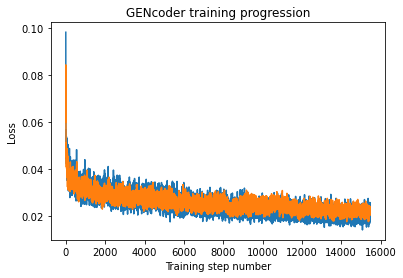

In [44]:
y = range(19*500)
fig, ax = plt.subplots()

ax.set_title("GENcoder training progression")
ax.set_ylabel('Loss')
ax.set_xlabel('Training step number')

ax.plot(loss_log["val"])
ax.plot(loss_log["training"])

plt.savefig("gencoder_progress.png")

In [ ]:
loss_log["val"]